# Section 5: deep reinforcement learning with the openai gym

Reinforcement learning is the process of teaching an autonomous agent how to behave in an environment. Rather than telling the agent what action to execute at each moment you let the agent decide for himself what to do, and you give it rewards based on how it performs. 

Recently there is a lot of attention on reinforcement learning. One reason is that the company [OpenAI](https://en.wikipedia.org/wiki/OpenAI) released a set of environments you can use to train your agent. The environment we will be using is the OpenAI gym. There are many tasks in this package which have defined how much reward you get for each action. Take a look at the [environments that are included with the OpenAI gym](https://gym.openai.com/envs/). As you can see there are classic control problems, but OpenAI also has a lot of Atari games you can try to master!

# Video 1: getting started with the OpenAI gym
### Installing the OpenAI gym
There are multiple ways you can install the OpenAI gym environment: 

##### In our Docker image
It is already installed in our Docker image. This means you don't have to do anything to include it, and you can start playing immediately. The downside of this is that there is no screen attached to our Docker image, which gives a bit of hassle inline. 

##### On your own pc. 
If you do want to see a screen with your game you would have to install everything locally. This means you have your own version of Python, TensorFlow, Matplotlib, etc. installed. If this is all fine you can install the OpenAI gym with these commands: 
> `git clone https://github.com/openai/gym.git`

> `cd gym`

> `pip install -e .`

For more information: see [this site](https://github.com/openai/gym#installing-everything). 

### Starting an environment
Let's start by loading some libraries we want to use during this section. They are the normal ones you expect by now (TensorFlow, NumPy, etc...). We also load gym!

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

from ipywidgets import widgets
from IPython.display import display

import gym

## Set logging dir for Tensorboard
logging_dir_n = 141


To load an environment you call the `gym.make` function and pass the name of the environment you want to load. After you reset you get the observation. If you installed gym on your local pc you can get a screen with the state of your environment using the command `env.render()`. As I will be doing everything from this Docker image we render the frame as RGB array and display it with Matplotlib...

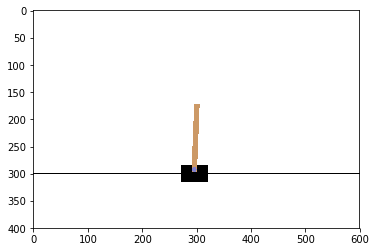

In [2]:
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
plt.imshow(firstframe)

### Performing (random) actions
With the function `env.action_space.sample()` you get a random action that's possible for this action space. Please take some time to figure out what kind of commands are possible, and what env.step does. 

In the following code we execute a few actions, plot the frames, and print what the environment tells us about the current state of the environment...

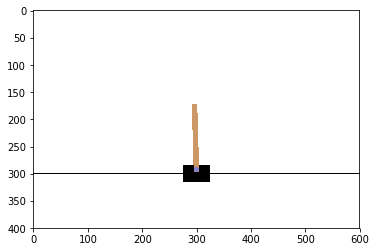

Observation: [-0.00141784 -0.17046153 -0.03062711  0.33002142] reward: 1 done: 0 info: {}


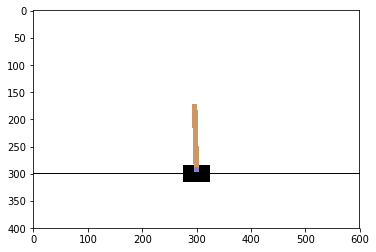

Observation: [-0.00482707  0.02508272 -0.02402668  0.02783965] reward: 1 done: 0 info: {}


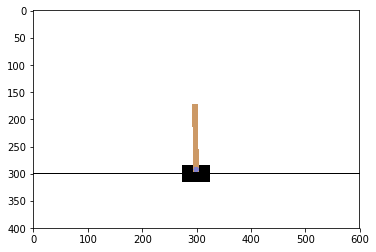

Observation: [-0.00432541  0.22054084 -0.02346989 -0.27232608] reward: 1 done: 0 info: {}


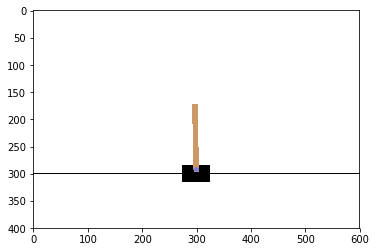

Observation: [  8.54019533e-05   2.57615081e-02  -2.89164096e-02   1.28629394e-02] reward: 1 done: 0 info: {}


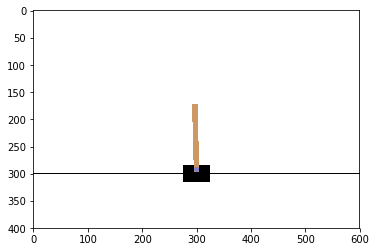

Observation: [ 0.00060063  0.22128597 -0.02865915 -0.28880138] reward: 1 done: 0 info: {}


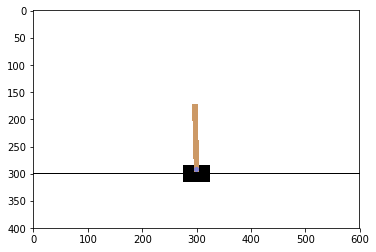

Observation: [ 0.00502635  0.41680463 -0.03443518 -0.59038358] reward: 1 done: 0 info: {}


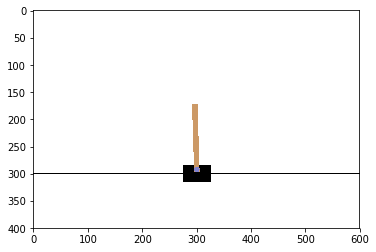

Observation: [ 0.01336244  0.61239137 -0.04624285 -0.89371171] reward: 1 done: 0 info: {}


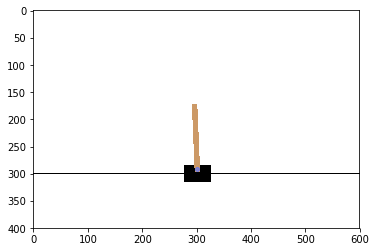

Observation: [ 0.02561027  0.80810894 -0.06411708 -1.20056478] reward: 1 done: 0 info: {}


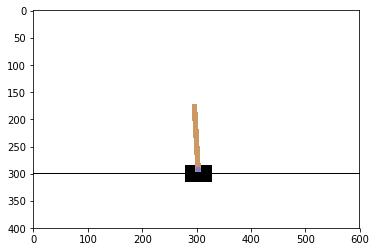

Observation: [ 0.04177245  1.00399897 -0.08812838 -1.51263355] reward: 1 done: 0 info: {}


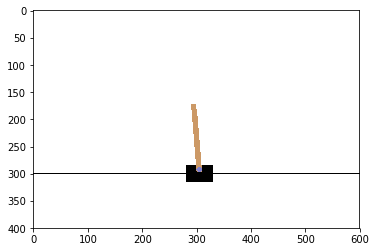

Observation: [ 0.06185243  1.20007067 -0.11838105 -1.83147595] reward: 1 done: 0 info: {}


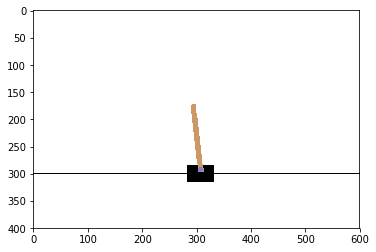

Observation: [ 0.08585384  1.39628779 -0.15501057 -2.15846449] reward: 1 done: 0 info: {}


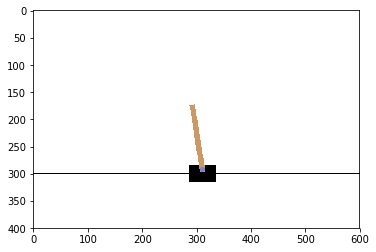

Observation: [ 0.1137796   1.20298886 -0.19817986 -1.91738343] reward: 1 done: 0 info: {}


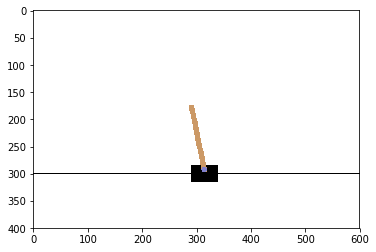

Observation: [ 0.13783938  1.01047514 -0.23652753 -1.69214931] reward: 1 done: 1 info: {}


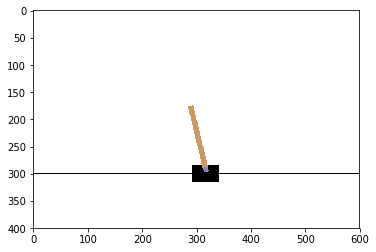

You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Observation: [ 0.15804888  1.20741825 -0.27037051 -2.04823141] reward: 0 done: 1 info: {}


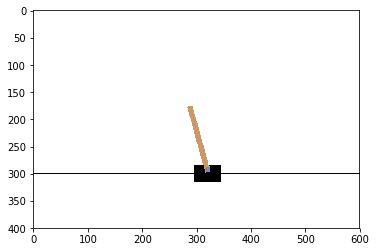

Observation: [ 0.18219724  1.01589412 -0.31133514 -1.84990577] reward: 0 done: 1 info: {}


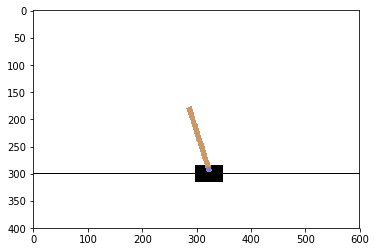

Observation: [ 0.20251513  0.82524051 -0.34833326 -1.66773472] reward: 0 done: 1 info: {}


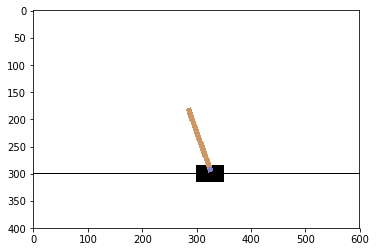

Observation: [ 0.21901994  0.63541183 -0.38168795 -1.50044404] reward: 0 done: 1 info: {}


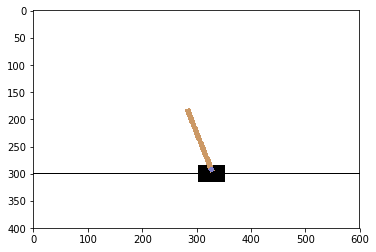

Observation: [ 0.23172817  0.44634874 -0.41169683 -1.34676898] reward: 0 done: 1 info: {}


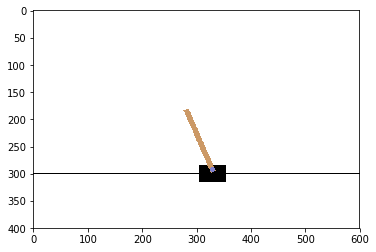

Observation: [ 0.24065515  0.25798515 -0.43863221 -1.2054807 ] reward: 0 done: 1 info: {}


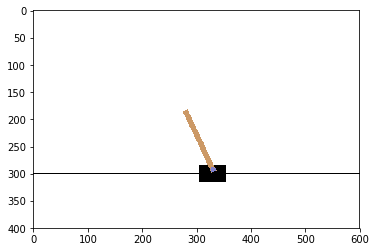

Observation: [ 0.24581485  0.45541359 -0.46274183 -1.5984508 ] reward: 0 done: 1 info: {}


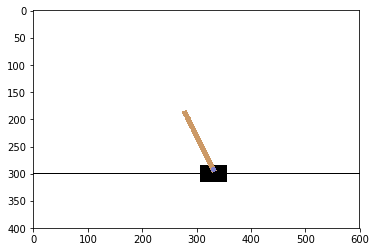

Observation: [ 0.25492312  0.26764553 -0.49471084 -1.47766209] reward: 0 done: 1 info: {}


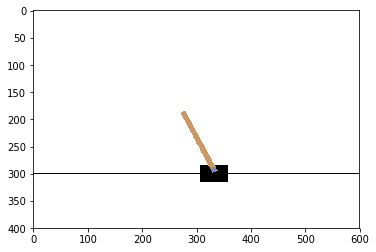

Observation: [ 0.26027603  0.46450186 -0.52426408 -1.87712824] reward: 0 done: 1 info: {}


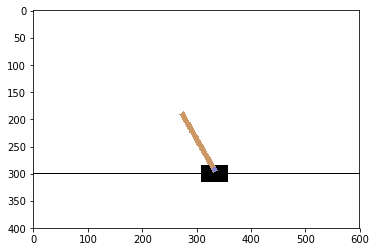

Observation: [ 0.26956607  0.66052376 -0.56180665 -2.27883966] reward: 0 done: 1 info: {}


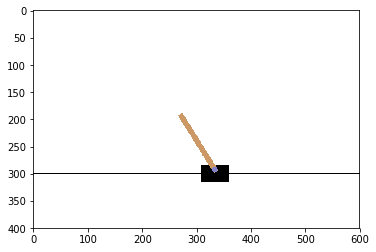

Observation: [ 0.28277655  0.4730611  -0.60738344 -2.19748535] reward: 0 done: 1 info: {}


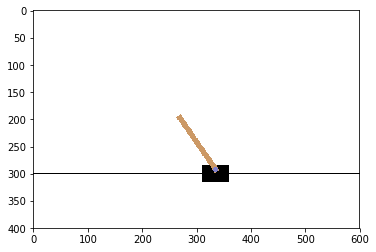

Observation: [ 0.29223777  0.28641971 -0.65133315 -2.13538807] reward: 0 done: 1 info: {}


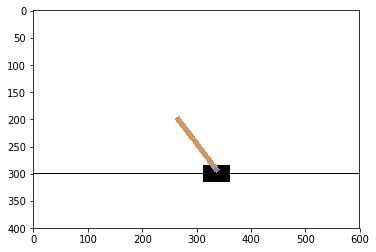

Observation: [ 0.29796616  0.48053877 -0.69404091 -2.54519215] reward: 0 done: 1 info: {}


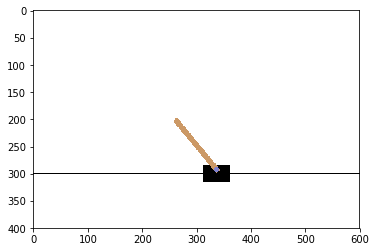

Observation: [ 0.30757694  0.67291032 -0.74494475 -2.95505347] reward: 0 done: 1 info: {}


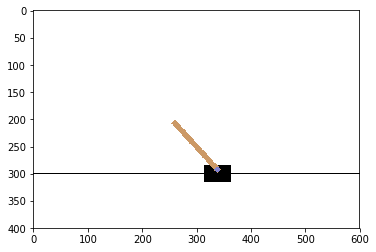

Observation: [ 0.32103514  0.86301119 -0.80404582 -3.36398719] reward: 0 done: 1 info: {}


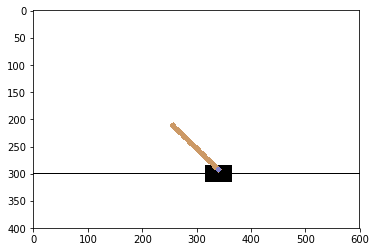

Observation: [ 0.33829537  1.05024259 -0.87132557 -3.77056822] reward: 0 done: 1 info: {}


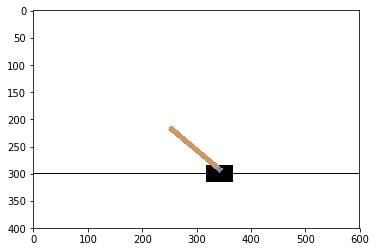

Observation: [ 0.35930022  0.85973406 -0.94673693 -3.81155429] reward: 0 done: 1 info: {}


In [3]:
observation = env.reset()
for _ in range(30):
    frame = env.render(mode = 'rgb_array')
    plt.imshow(frame)
    plt.show()
    observation, reward, done, info = env.step(env.action_space.sample()) 
    print("Observation: %s reward: %d done: %d info: %s" % (str(observation), reward, done, info))

### Input and output 

Let's take a look at what we can use to train an autonomous agent: 

##### Observation
The observation consists of the angle of the pole, turn velocity of the pole, the location of the base, and the movespeed of the base. Other environments have different inputs. Some environments (the Atari games) simply give you an image, other environments give a representation of the state. 

##### Reward
Reward is the reward our environment gives us each frame. For cartpole the reward is 1.0 while we managed to keep the stick in less than a small angle. After we reached this angle the reward will change to 0.0 while we did not reset the environment. 

Other environments give different rewards. Mountaincar for example gives a reward of 0.0 while we did not reach the top, and 1.0 once we reached it. Whenever you try a new environment make sure you know when your algorithm receives a reward as this is vital for learning something. 

##### Done
If this boolean is True it means you probably want to reset your network. In the case of cartpole it means the cart can't get anymore points: either by:
- failing to keep the pole at less than a certain angle
- failing to keep the base at less than a certain distance
- succeeding at this for more than 200 frames!

Other environments end when your lives are gone, others end after a certain amount of iterations.

#### Actions
What actions you can perform depend on the environment of you agent. In this environment you can only perform two actions: apply a force to the left of the base, or to the right of the base. In other environments, like the Atari environment, you can press several buttons!

### Playing yourself
Now you are able to play a pretty boring game with a text-interface...

In [4]:
# observation = env.reset()
# done = False
# while not done:
#     frame = env.render(mode = 'rgb_array')
#     plt.imshow(frame)
#     plt.show()
    
#     useraction = -1
#     while useraction < 0:
#         try:
#             useraction = int(input("Left (0) or right (1)?"))
#         except:
#             pass
        
        
#     observation, reward, done, info = env.step(useraction) 
# print("You are dead..")

## Video 2: Random search
One way you could approach this problem is with a very simple single-layer neural network that takes the input and has weights to two actions. You can imagine that this neural network makes sure the left action is chosen if the stick is too far to the left, and the right action is chosen if the stick is too far to the right. 

Let's start with this simple single-layer neural network. As code I took the example from [this website](http://kvfrans.com/simple-algoritms-for-solving-cartpole/). If you like and have time I would definitely explore all samples of that blogpost as it gives a lot of insight in reinforcement learning and the cartpole problem!

For now it is enough to say that we can construct a single-layer neural network by having a matrix multiplication of the state with a 4x1 matrix (if the result is smaller than 0 we push left!). To get this matrix we are going to do generate A LOT of random matrices and see which ones perform best. This technique, random search, is described on the blog I linked to earlier. You can copy-paste the code from the blog, and change it however you like it. 


In [5]:
def run_episode(env, parameters):  
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward


bestparams = None  
bestreward = 0  
for iteration in range(10000):  
    parameters = np.random.rand(4) * 2 - 1
    reward = run_episode(env,parameters)
    if reward > bestreward:
        bestreward = reward
        bestparams = parameters
        # considered solved if the agent lasts 200 timesteps
        if reward == 200:
            print("WOW! FOUND A SOLUTION TO THIS PROBLEM USING RANDOM SEARCH AT ITERATION %d!" % (iteration))
            break
    print("Solution not yet found")

Solution not yet found
Solution not yet found
Solution not yet found
Solution not yet found
Solution not yet found
Solution not yet found
Solution not yet found
Solution not yet found
Solution not yet found
WOW! FOUND A SOLUTION TO THIS PROBLEM USING RANDOM SEARCH AT ITERATION 9!


Try to understand what is happening in the run_episode function, and what is happening in the search function above. After we did this it's time to visualise the best, winning, parameters: 


In [6]:
observation = env.reset()
frames = list()
for _ in range(200):
    action = 0 if np.matmul(bestparams,observation) < 0 else 1
    observation, reward, done, info = env.step(action)
    
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    
    if done:
        break

Now that we have a list with frames we can render them as a GIF. I use the following function to construct the gif and show it inline in our Jupyter notebook: 


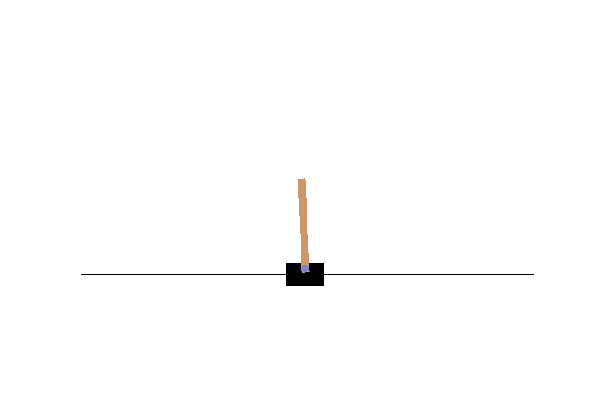
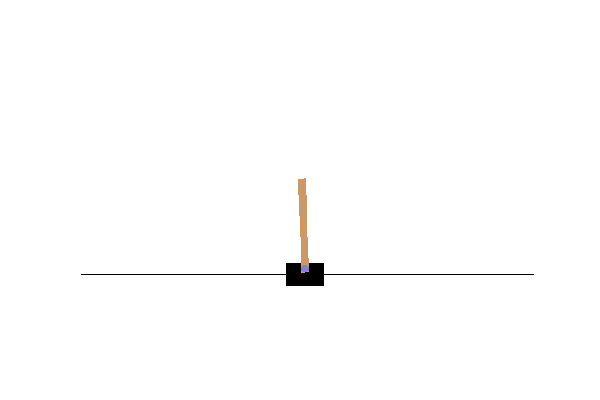
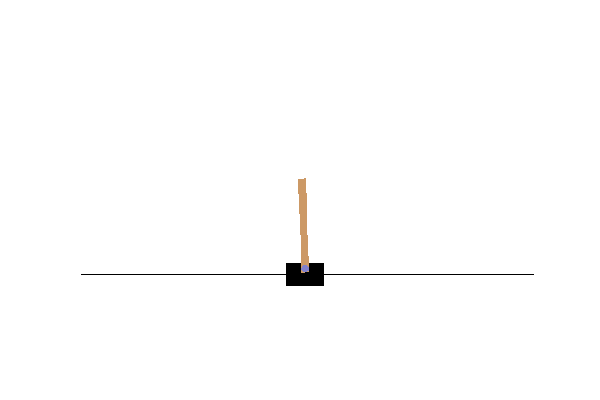
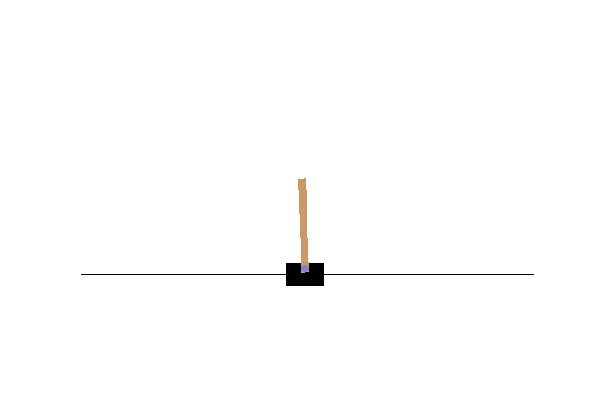
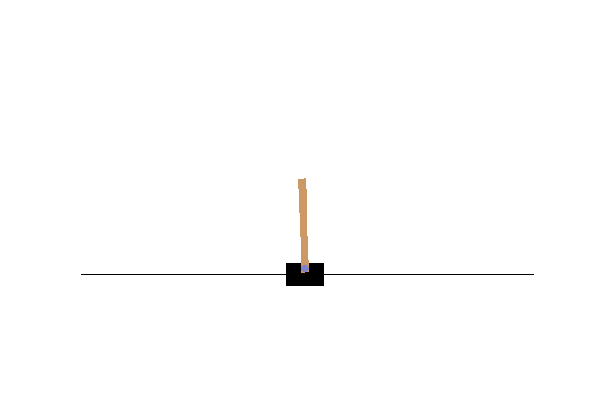
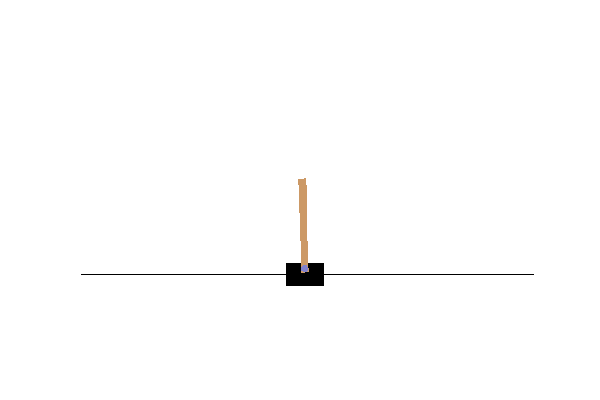
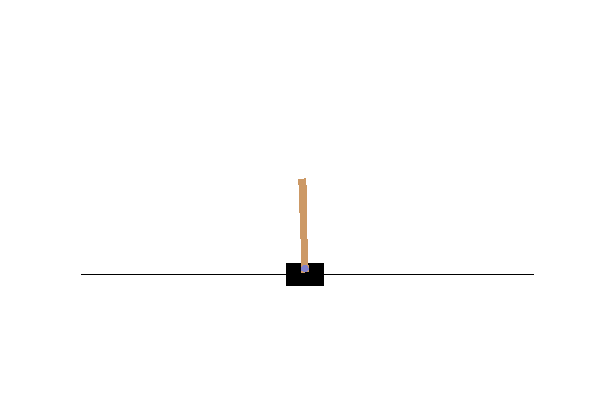
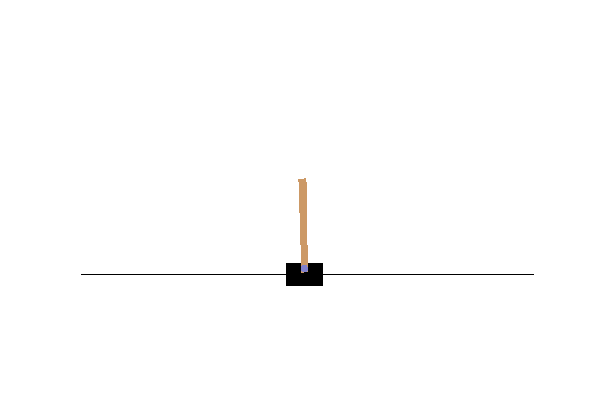
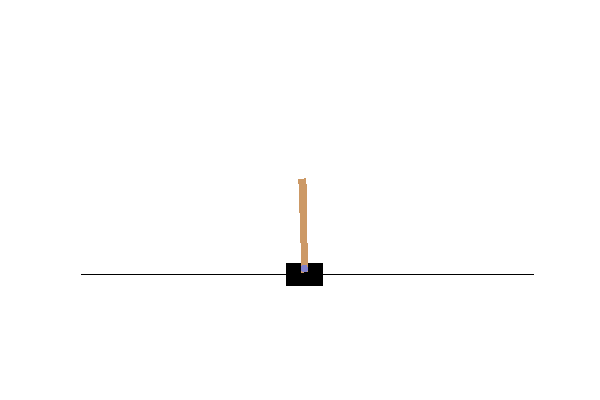
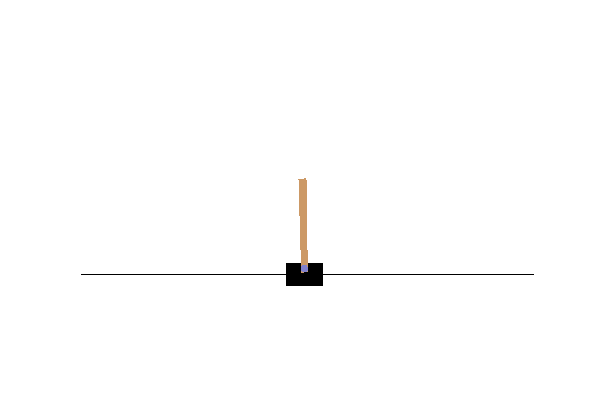
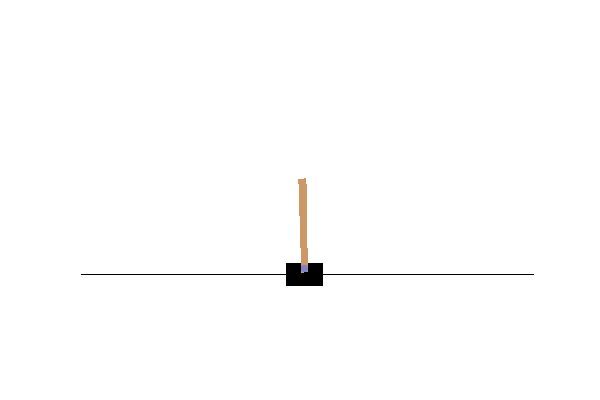
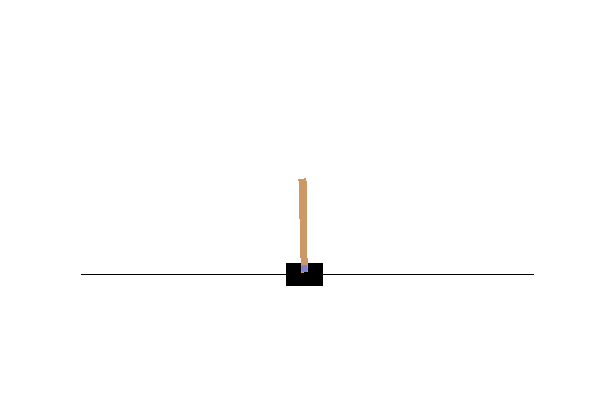
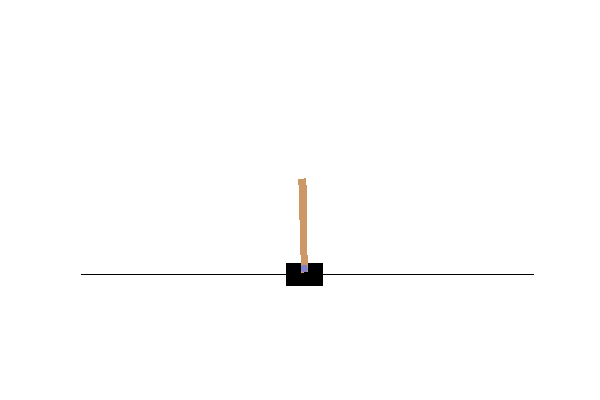
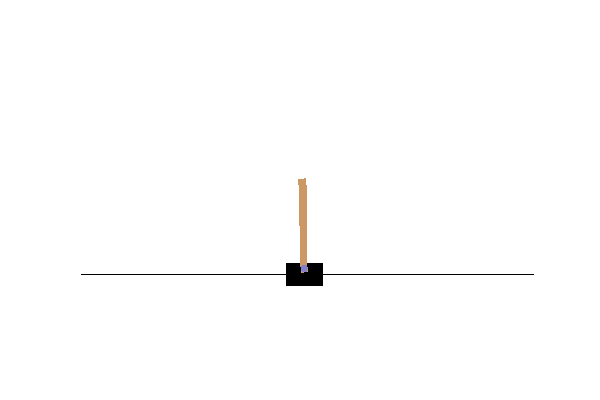
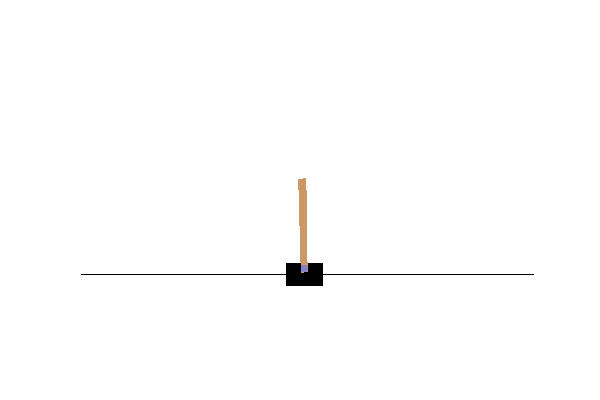
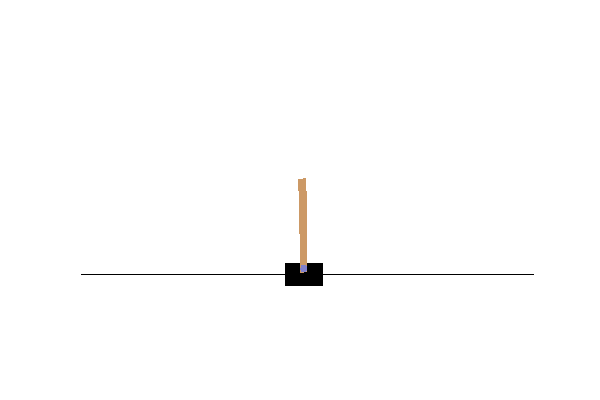
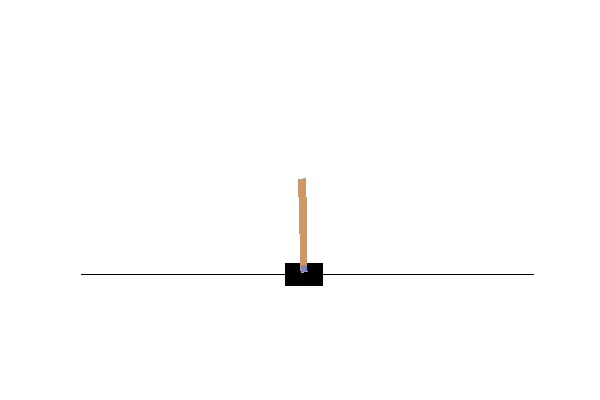
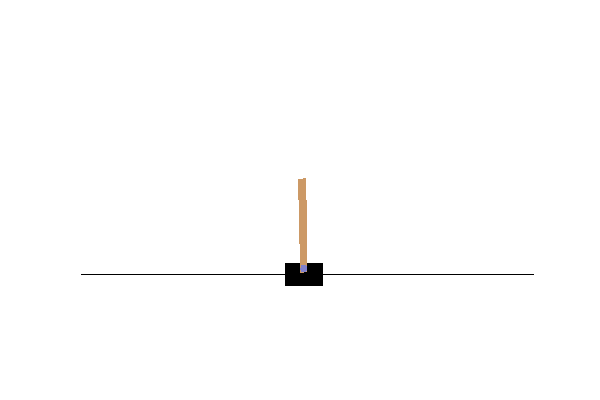
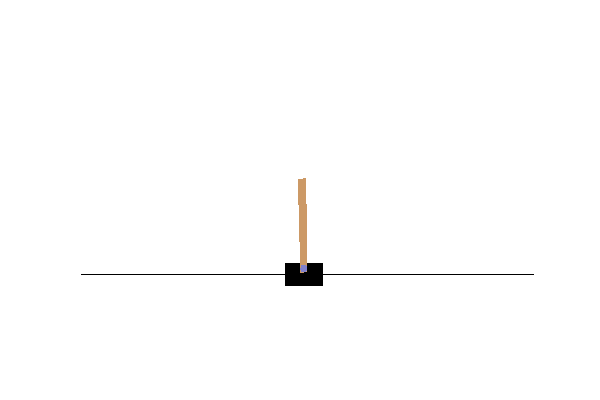
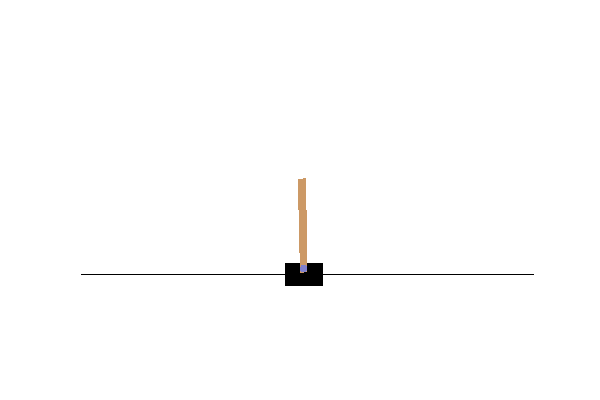
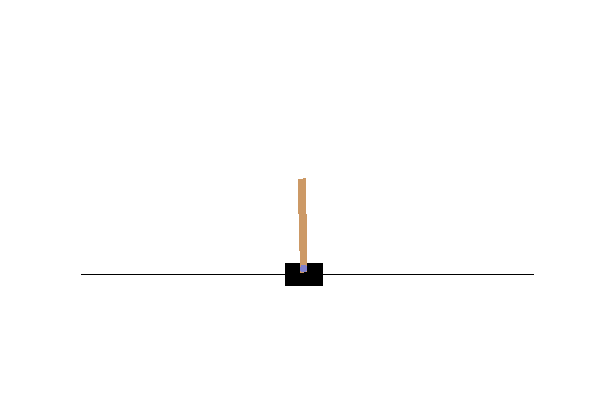
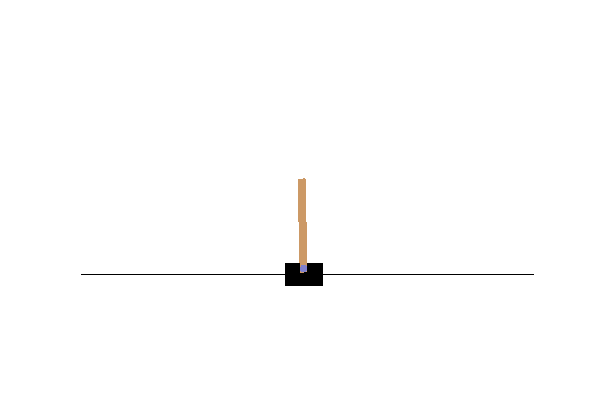
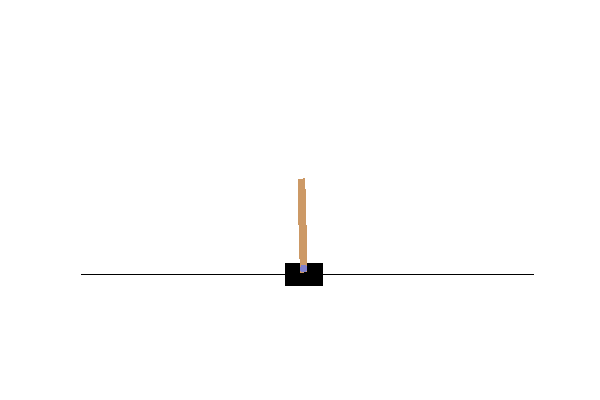
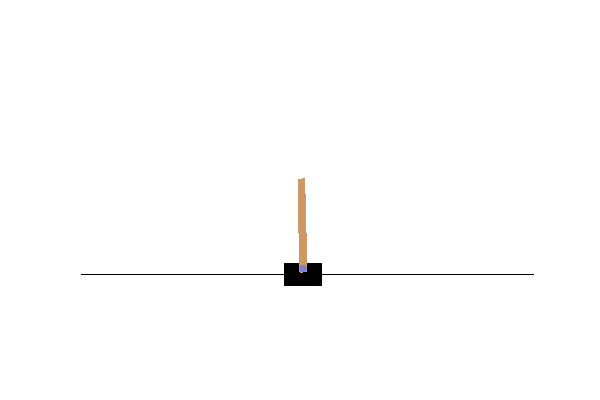
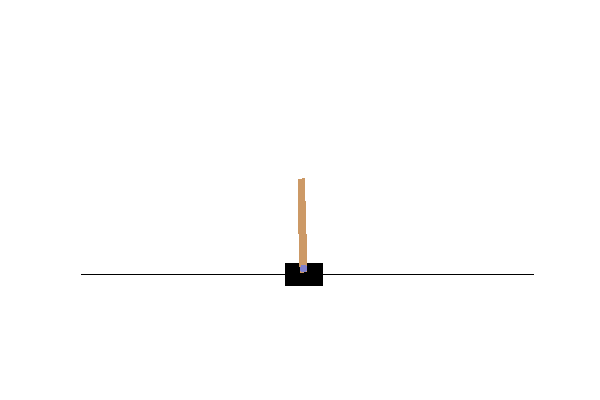
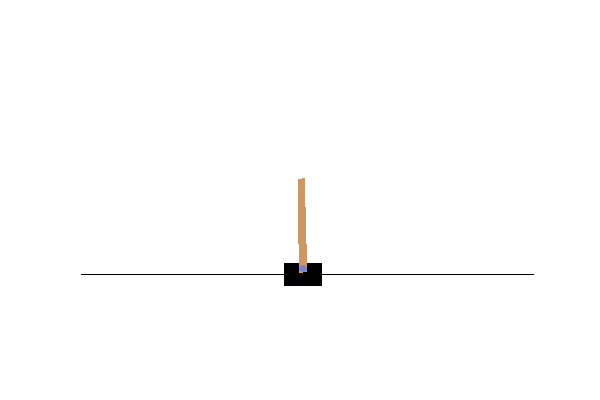
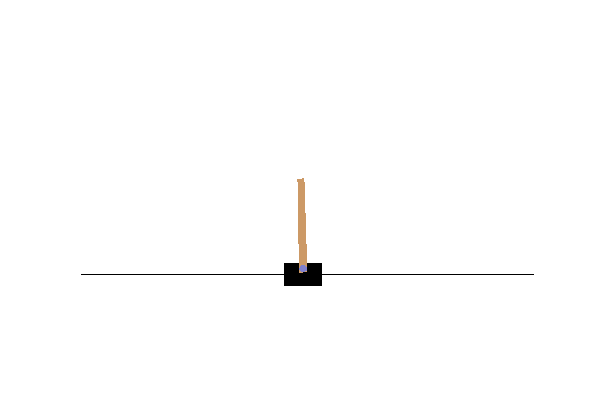
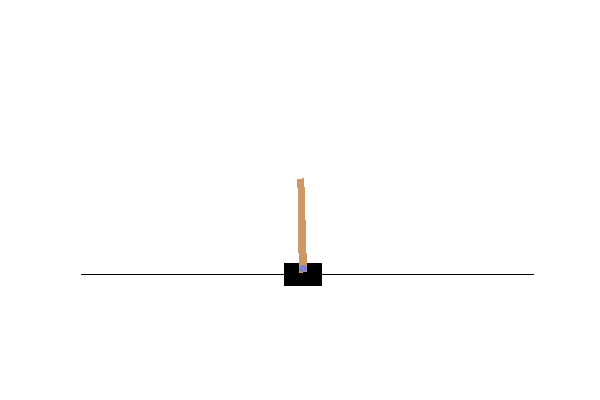
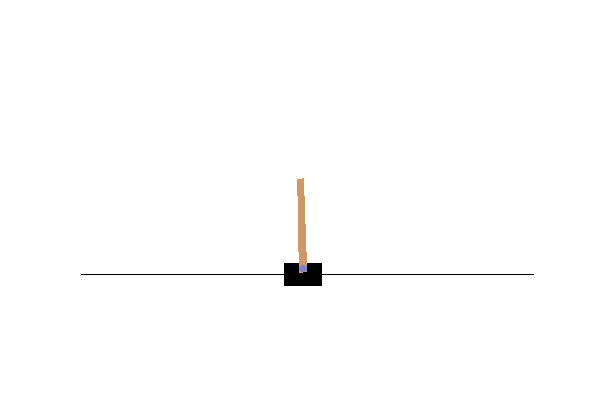
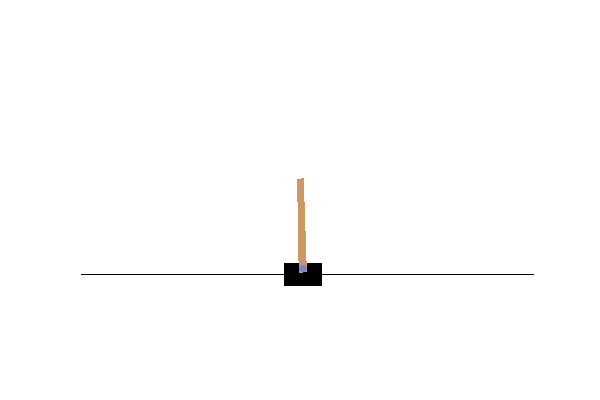
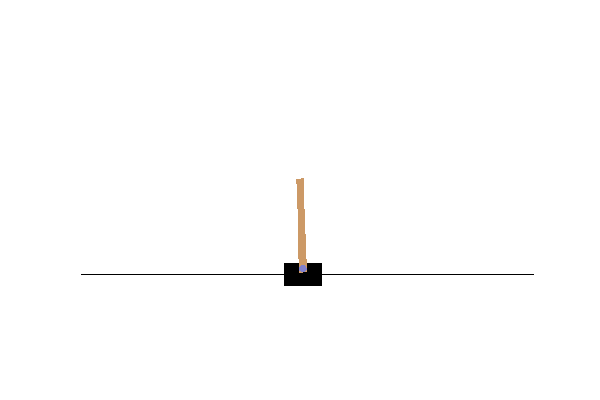
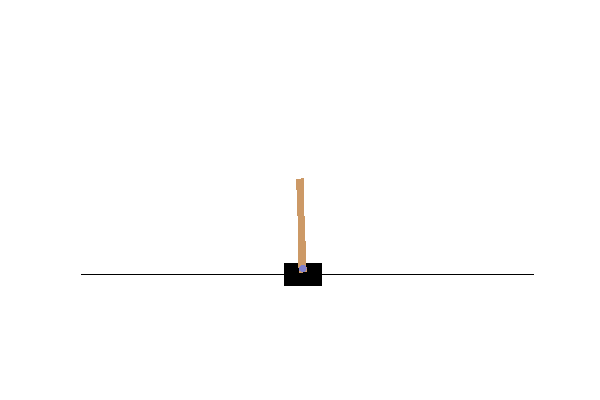
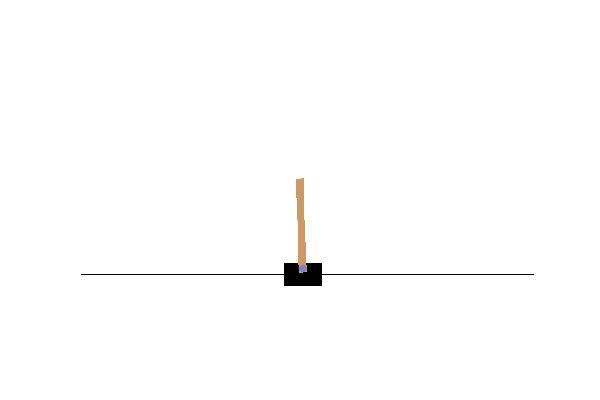
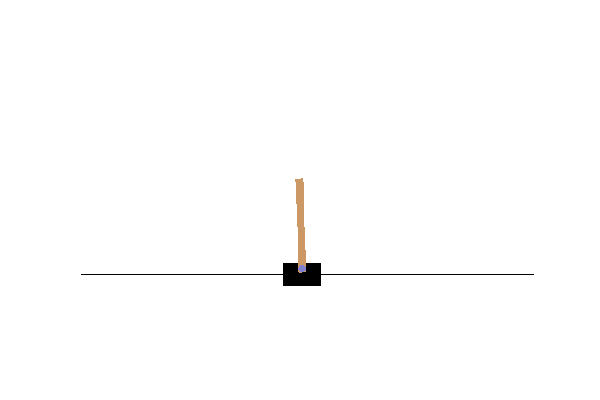
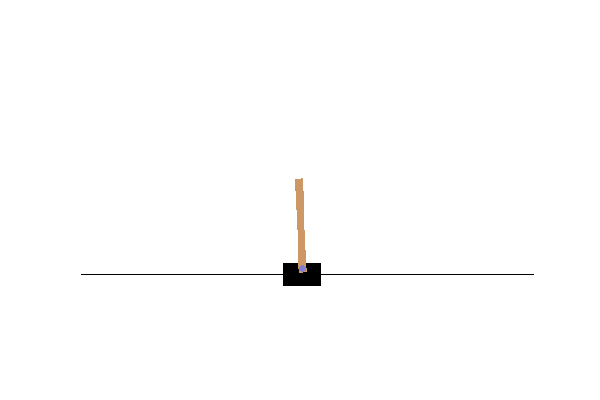
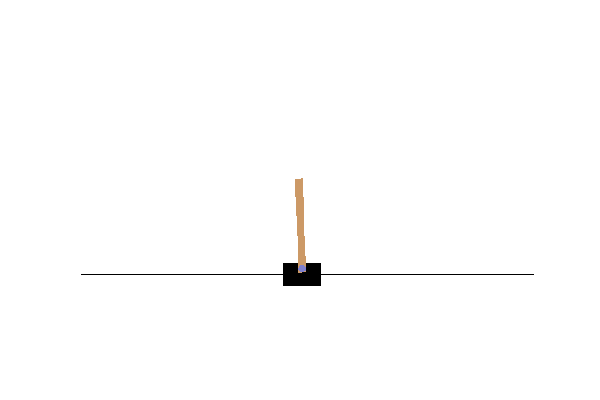
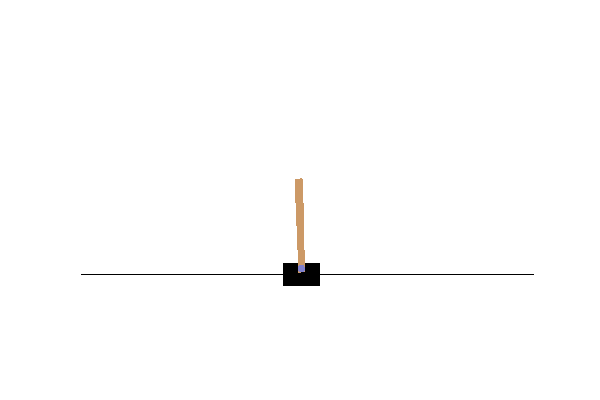
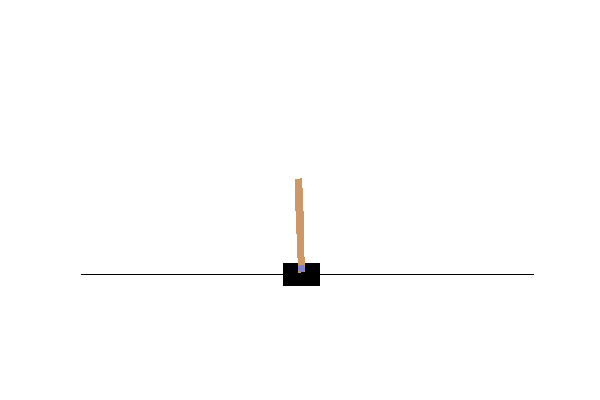
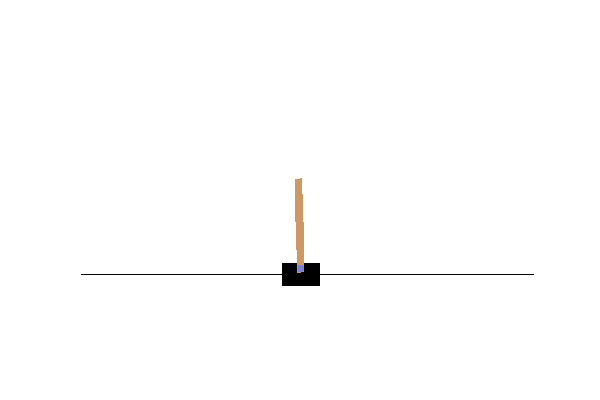
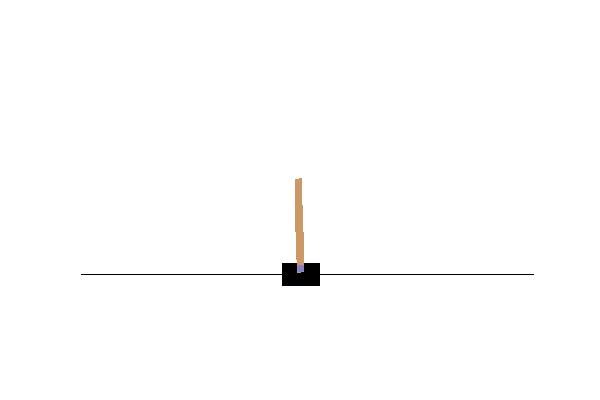
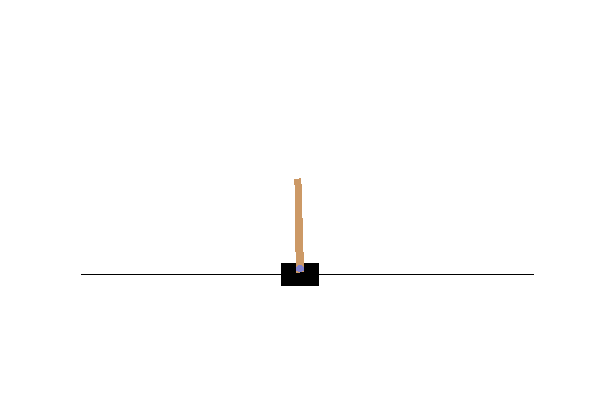
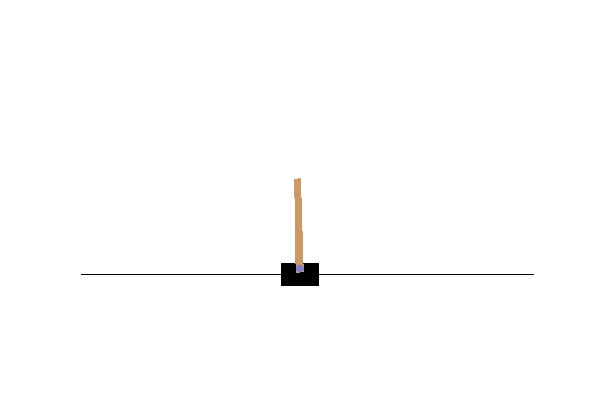
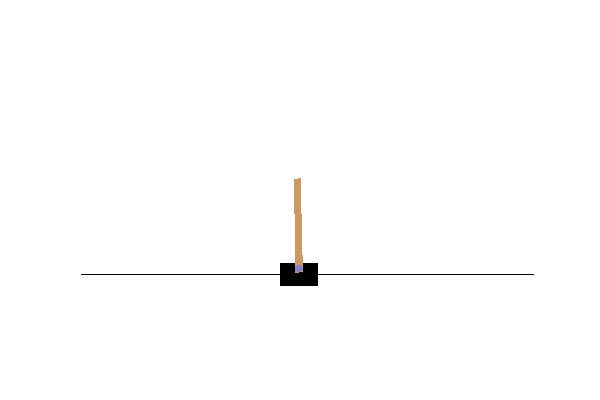
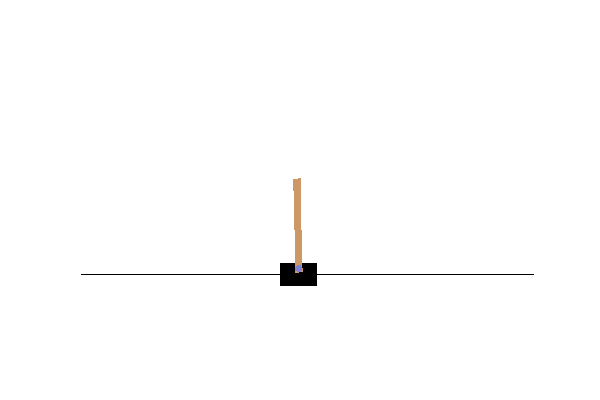
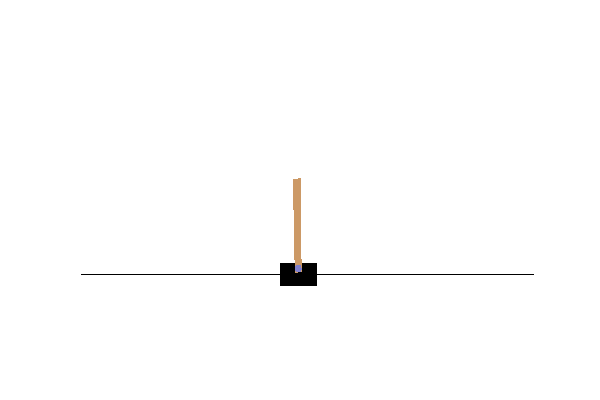
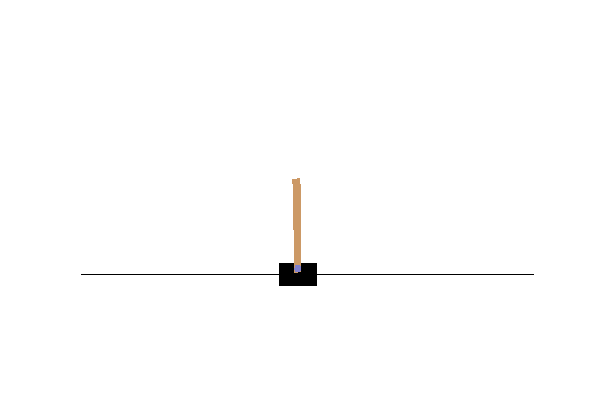
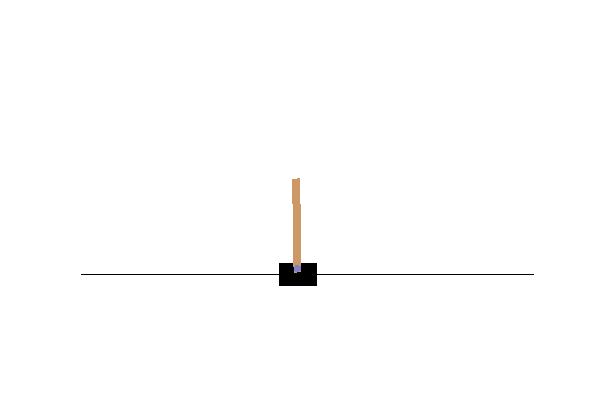
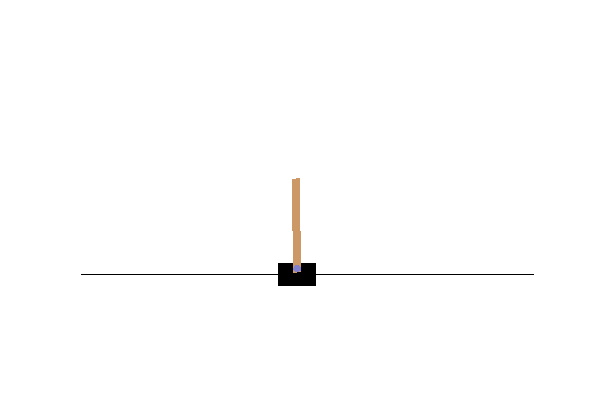
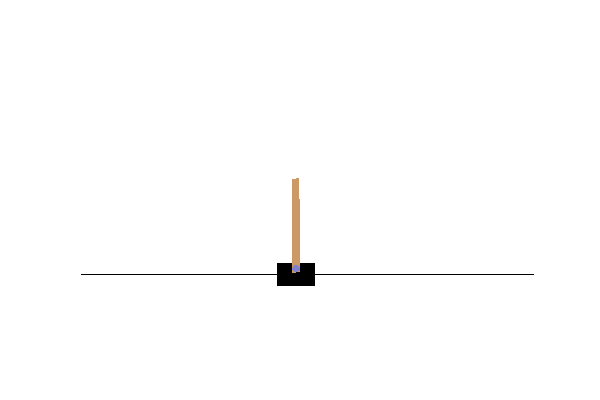
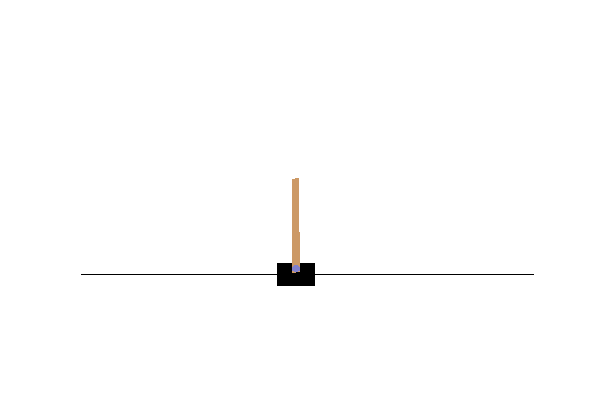
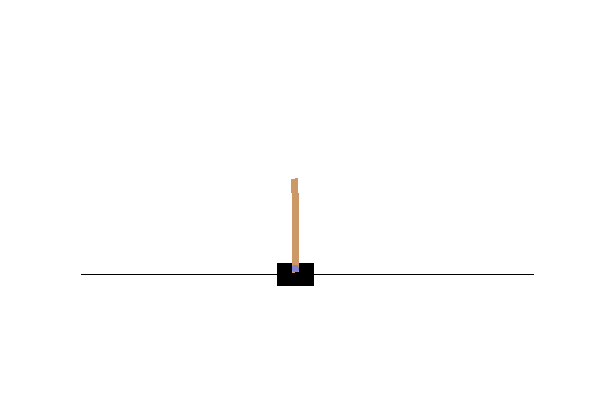
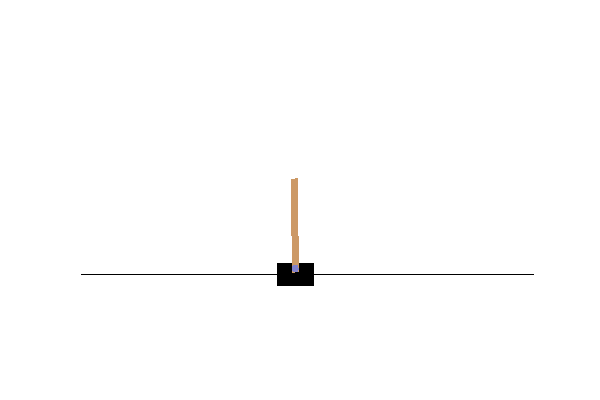
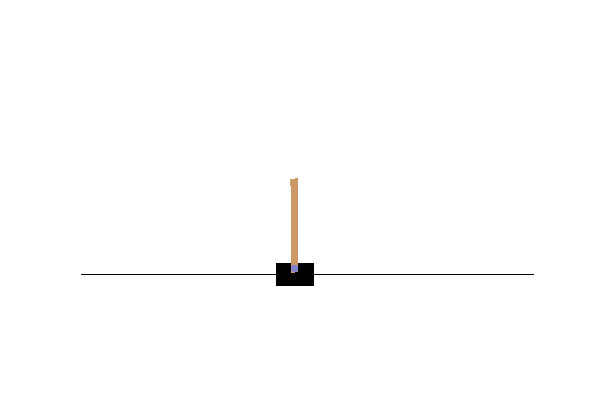
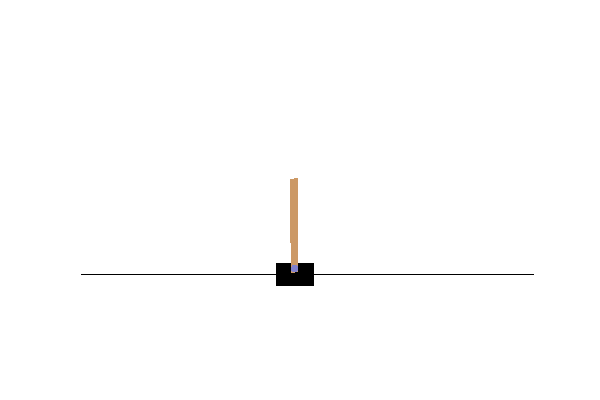
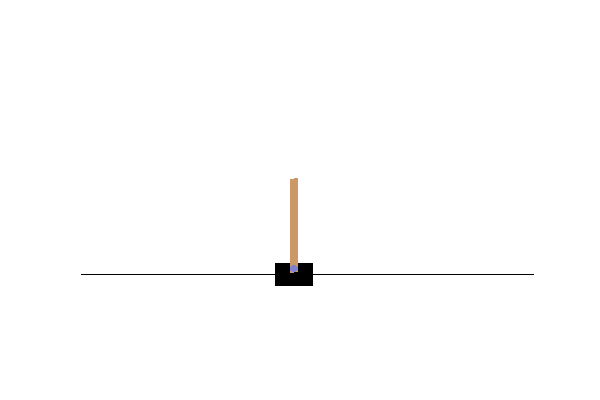
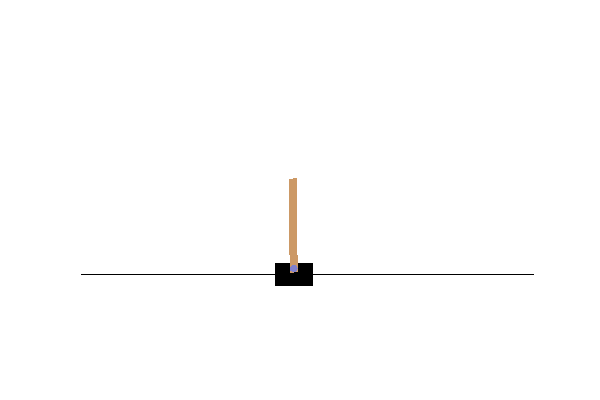
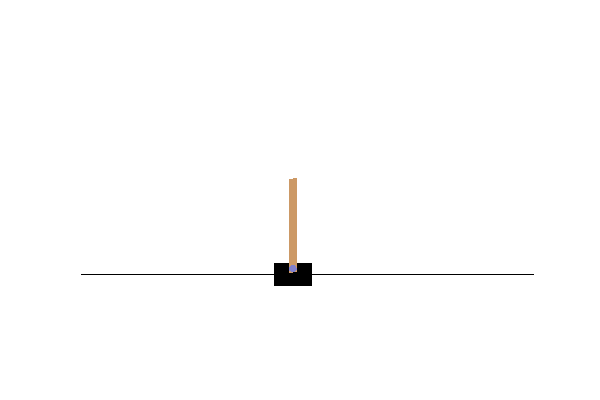
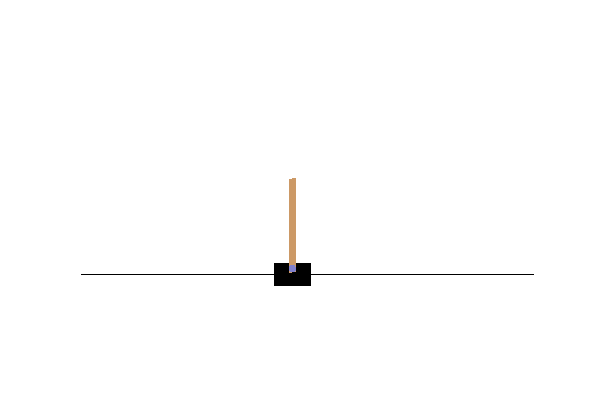
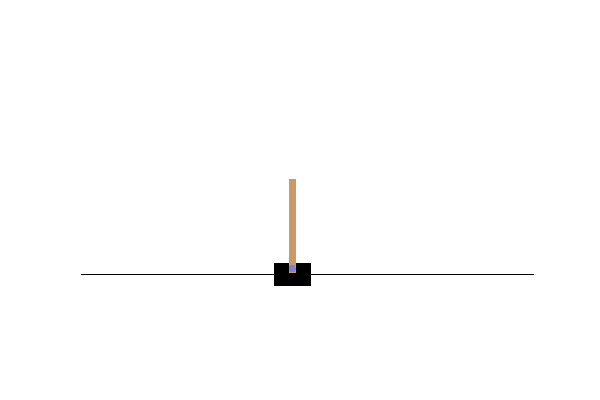
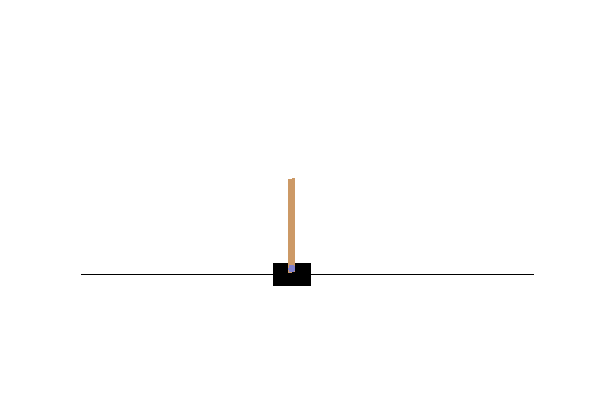
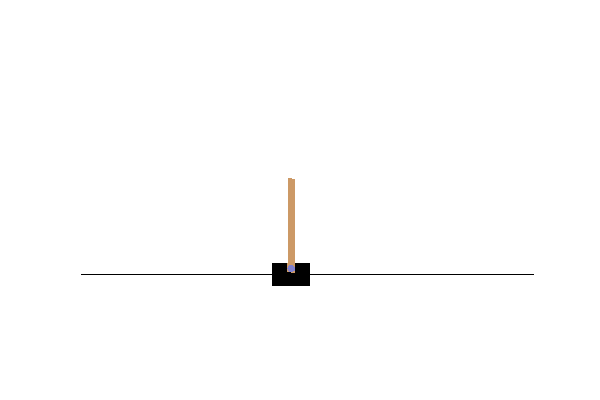
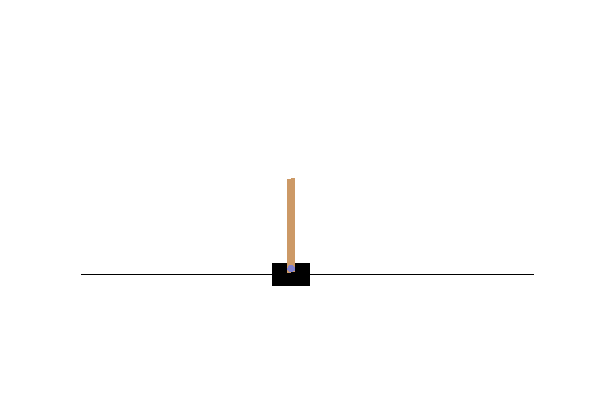
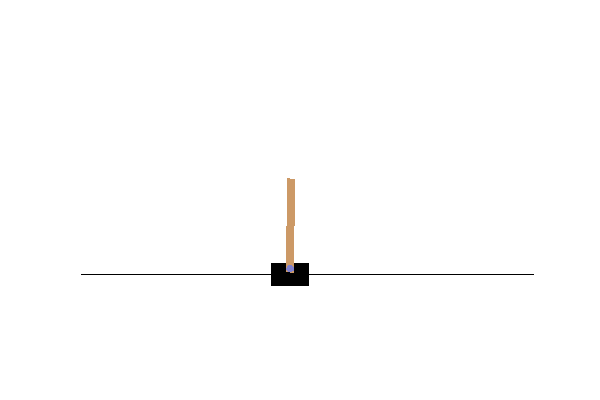
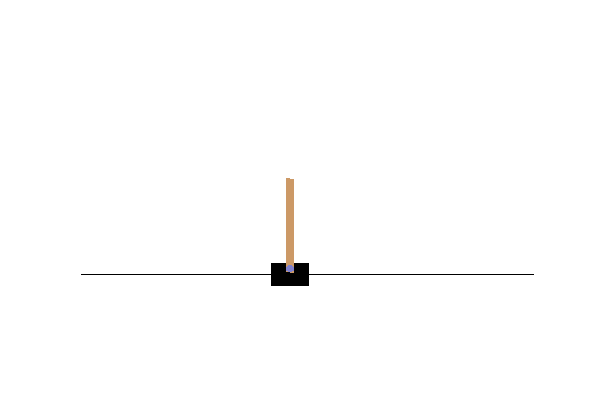
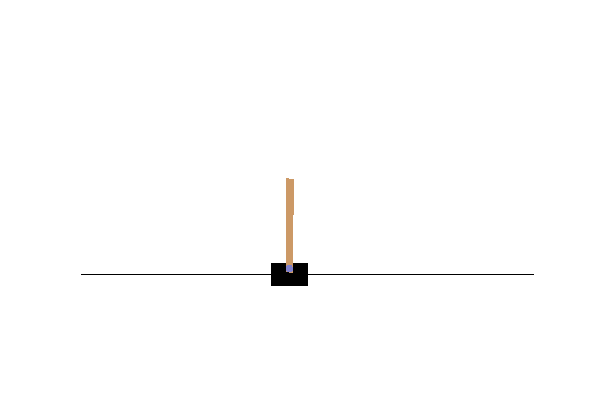
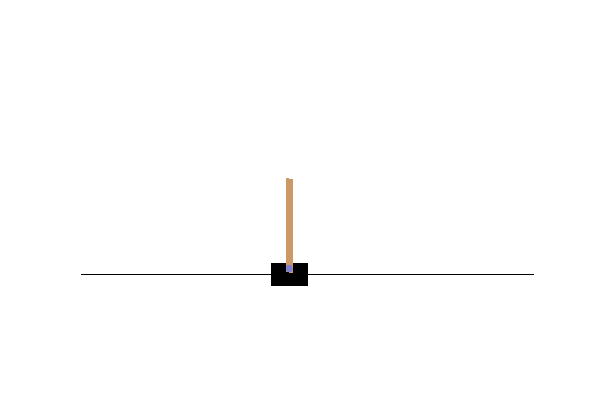
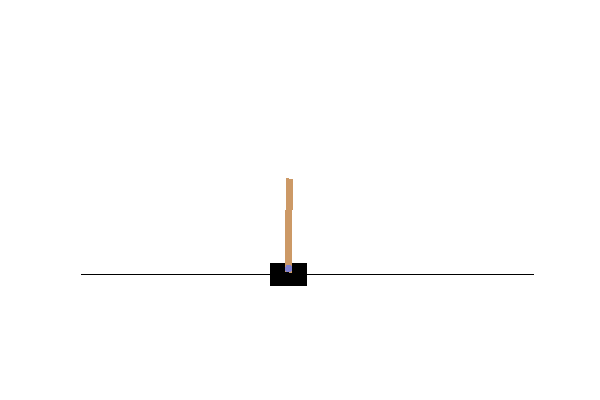
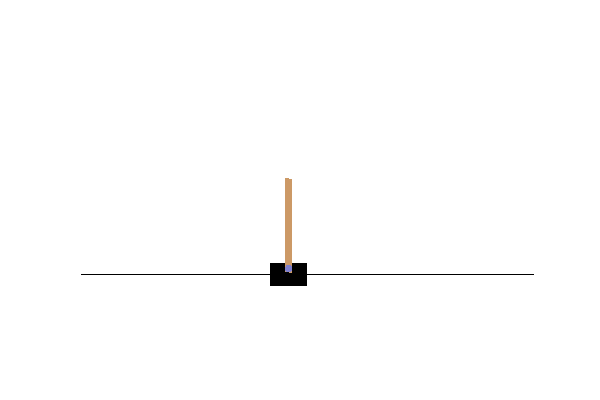
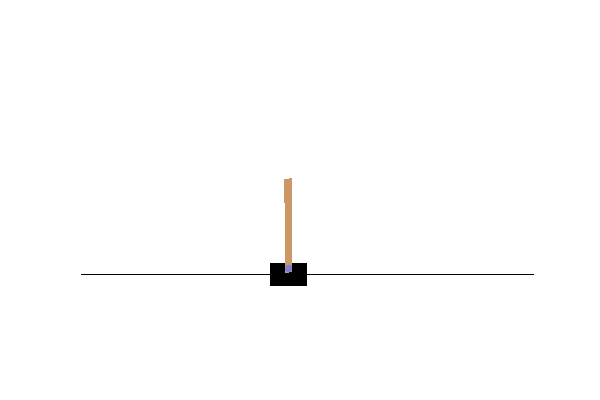
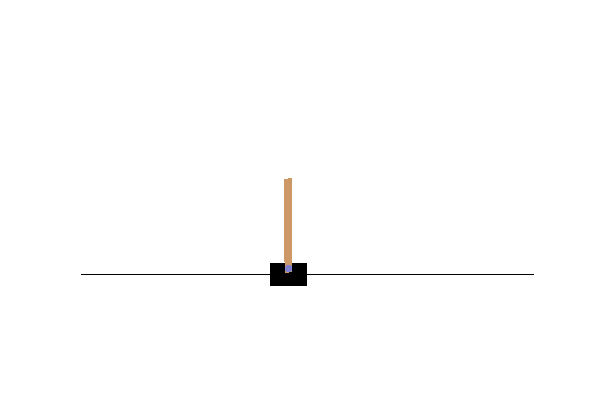
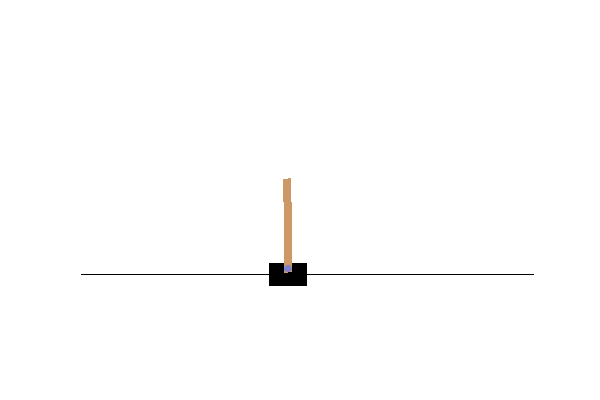
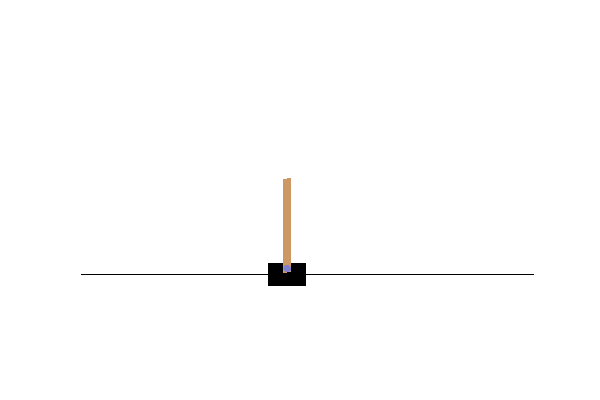
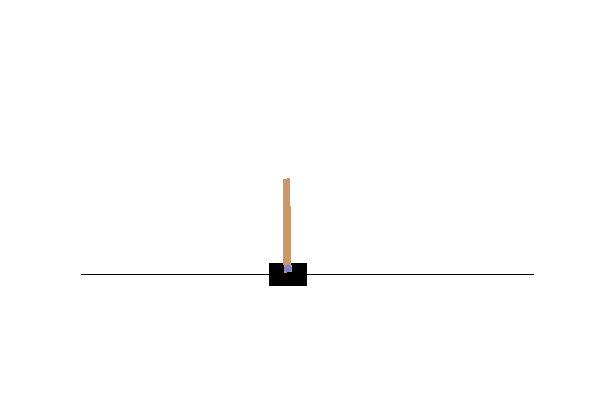
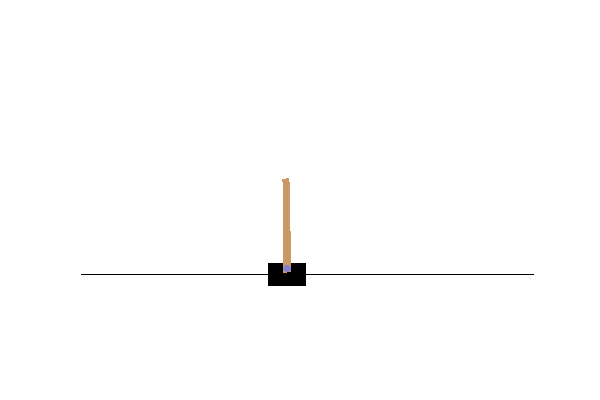
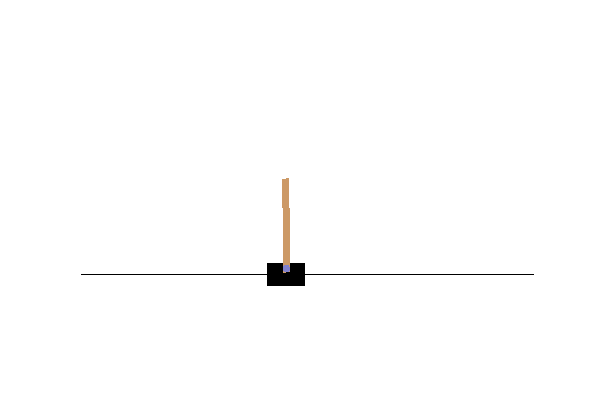
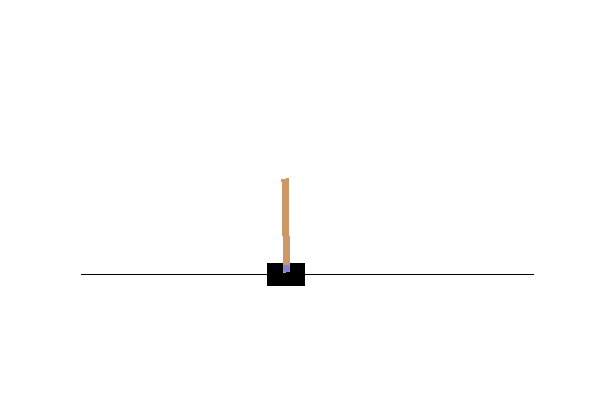
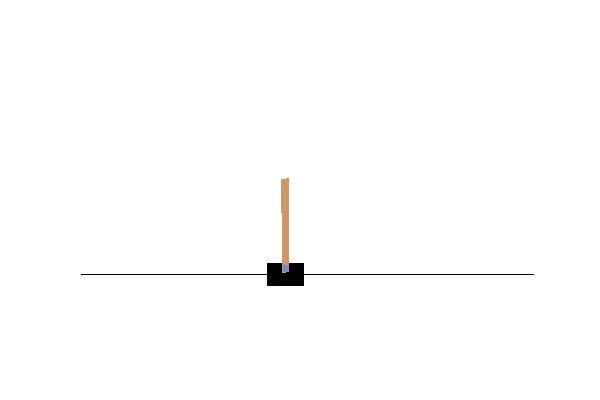
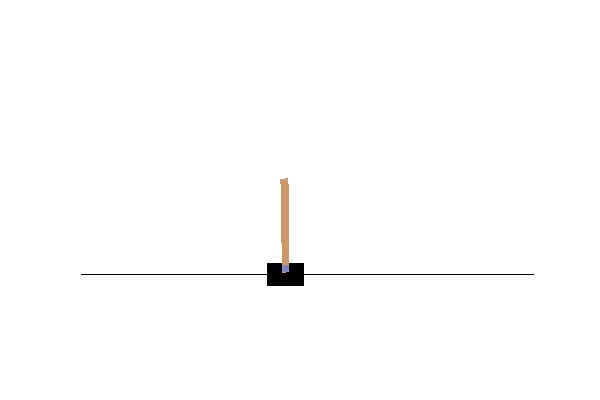
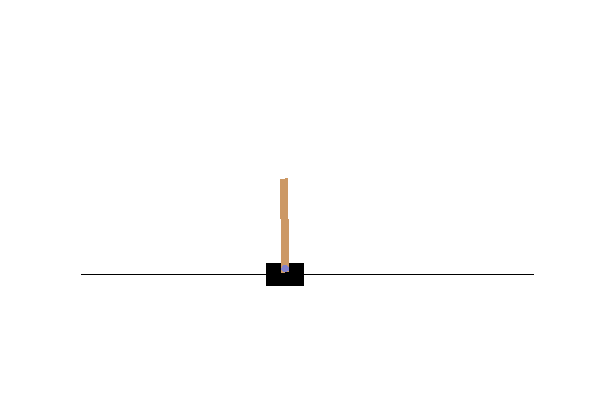
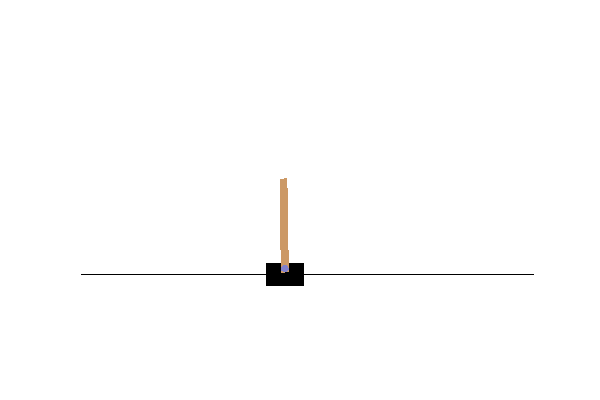
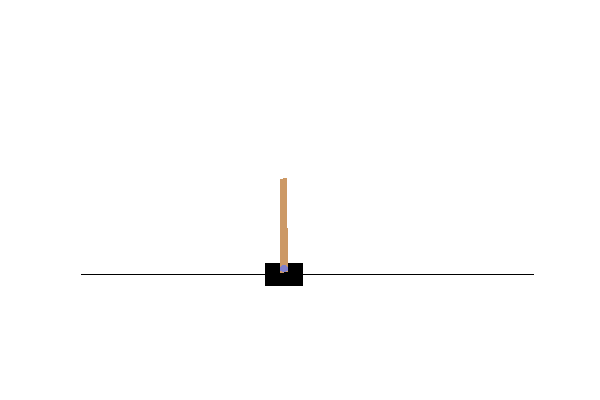
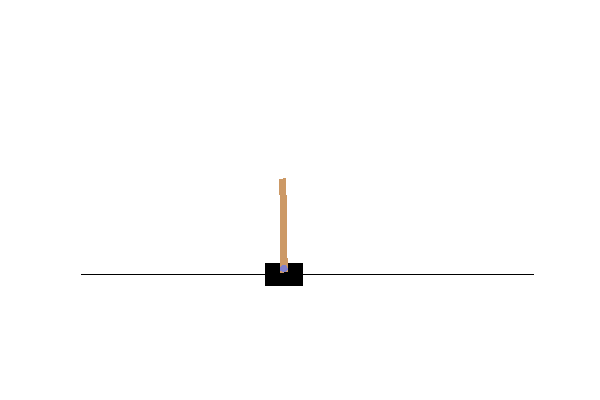
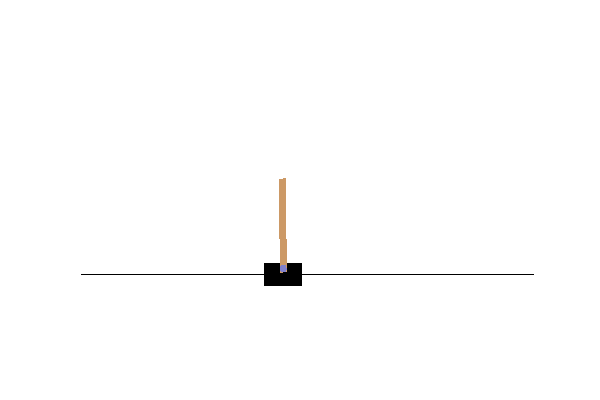
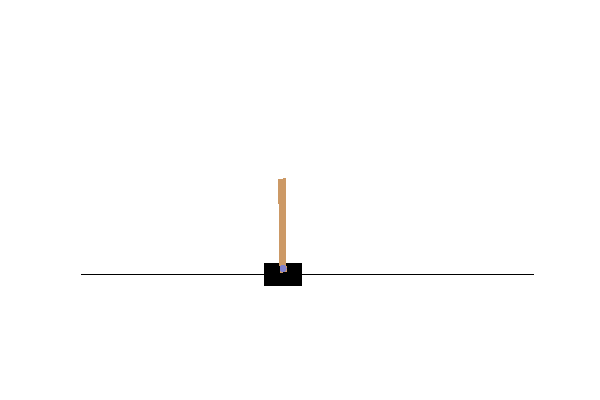
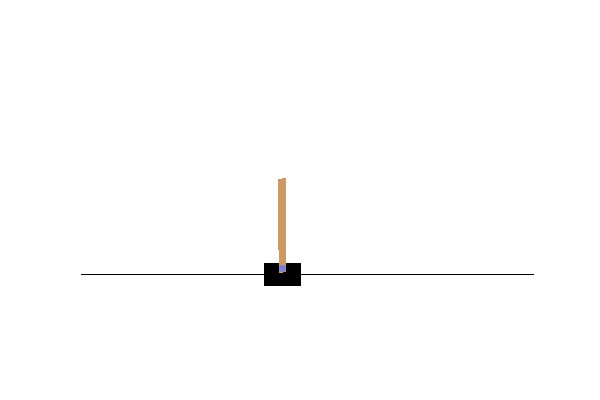
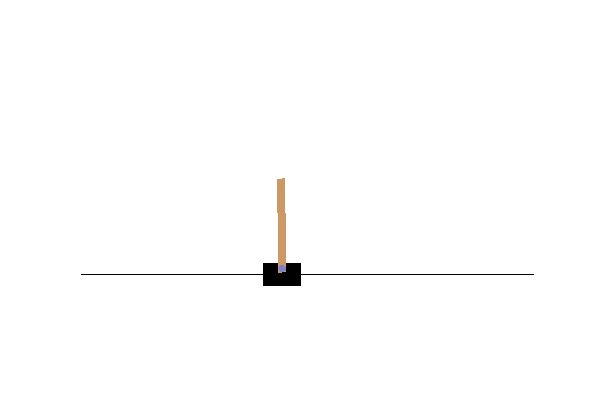
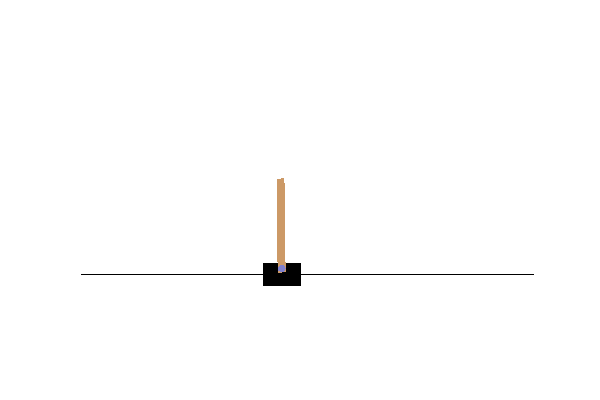
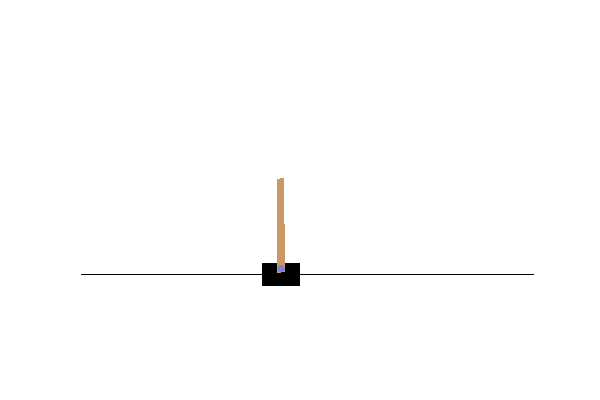
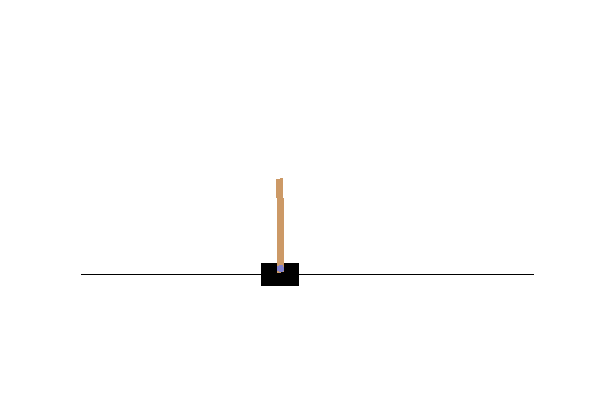
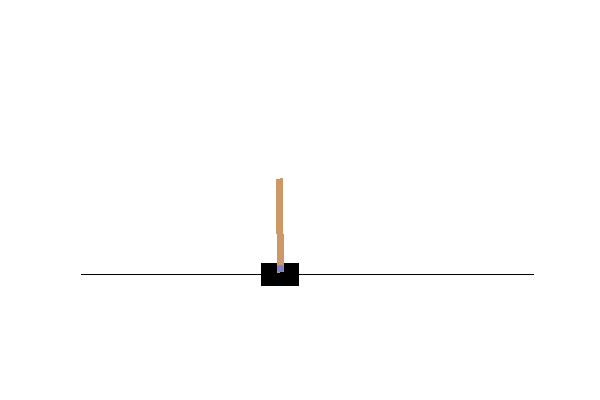
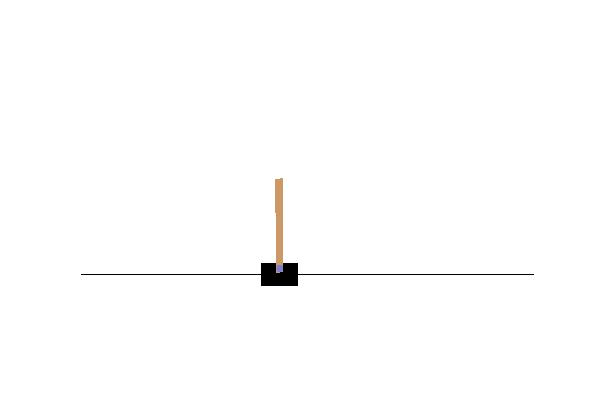
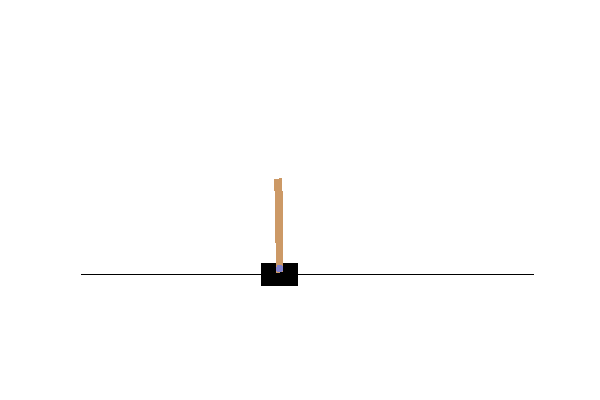
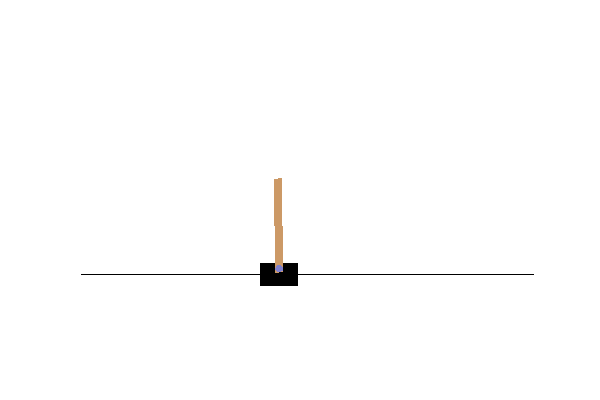
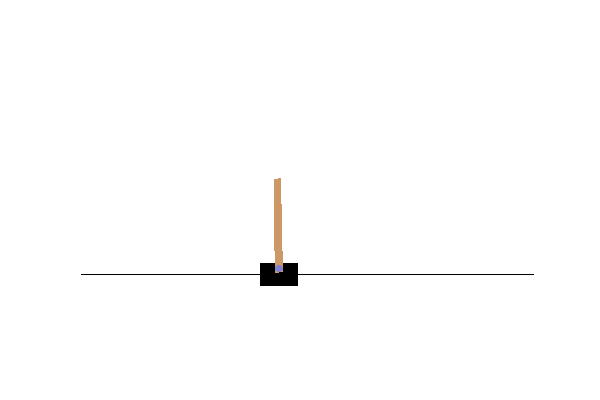
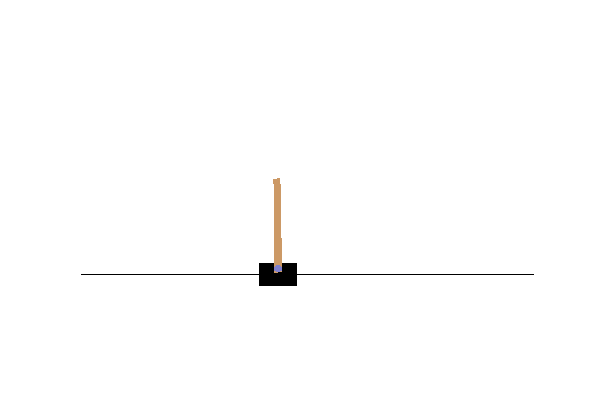
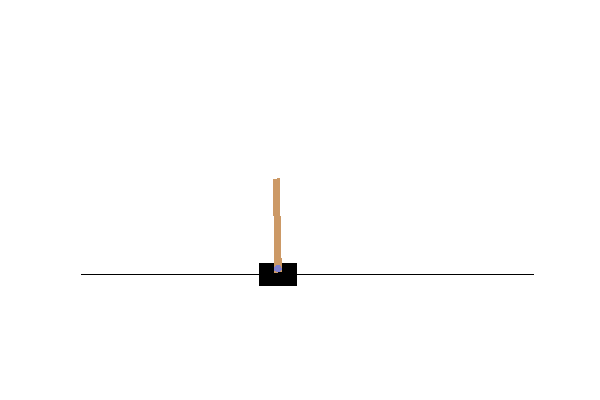
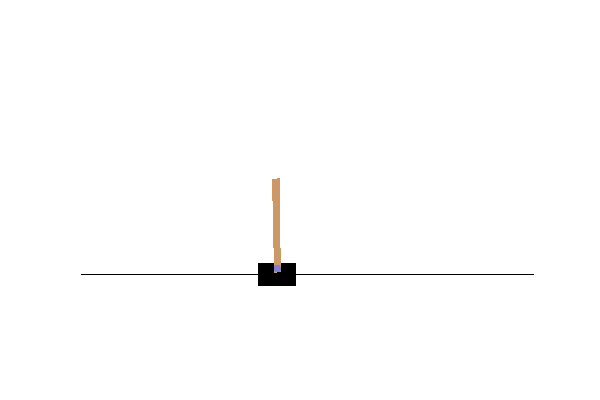
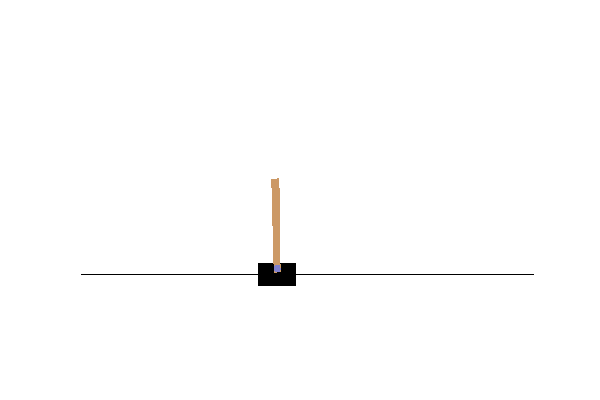
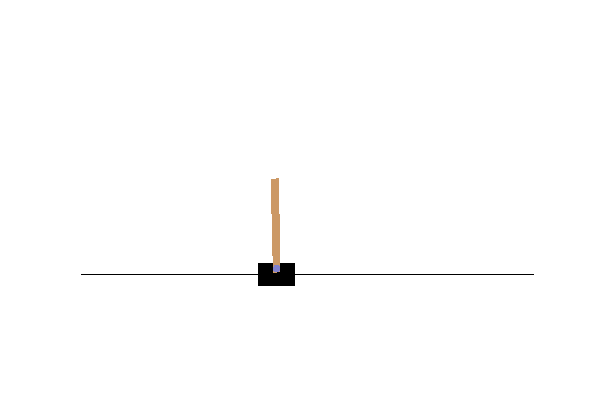
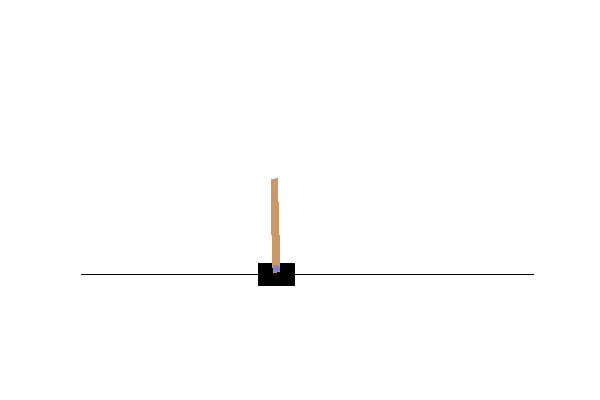
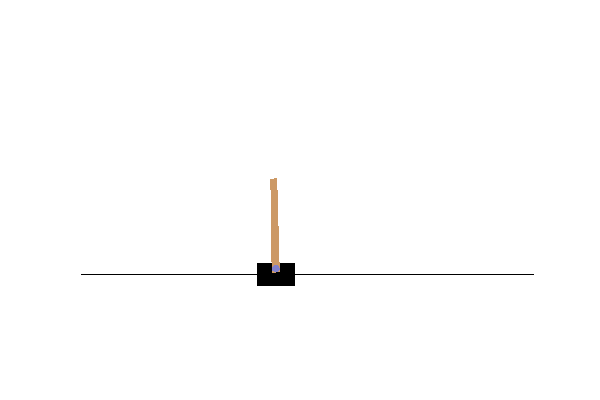
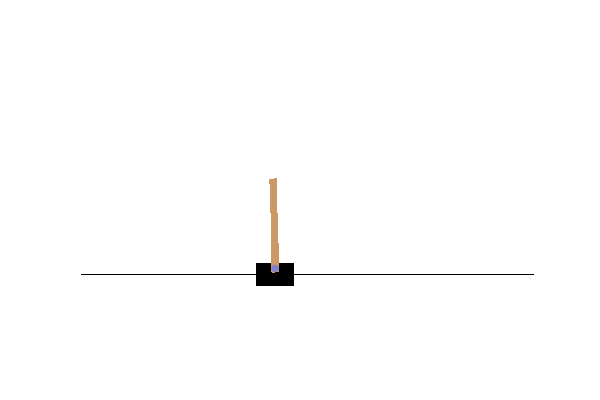
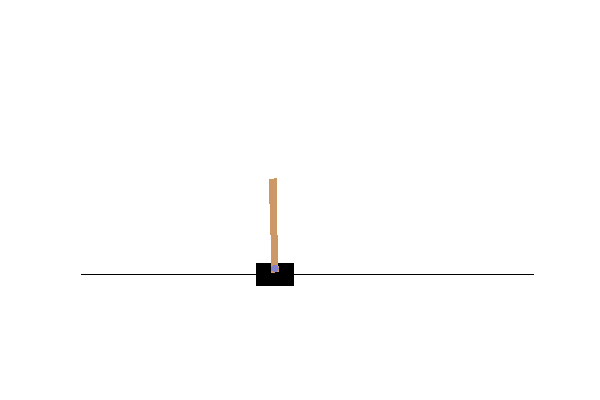
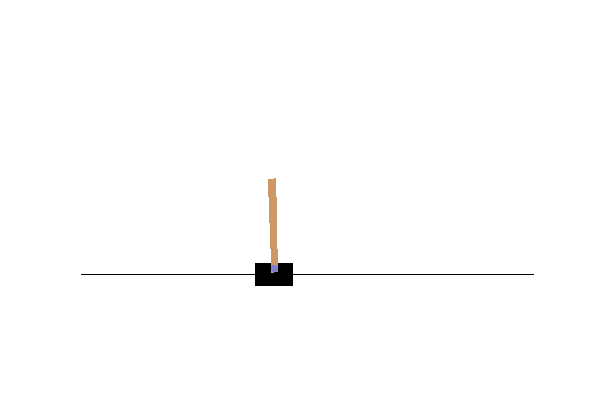
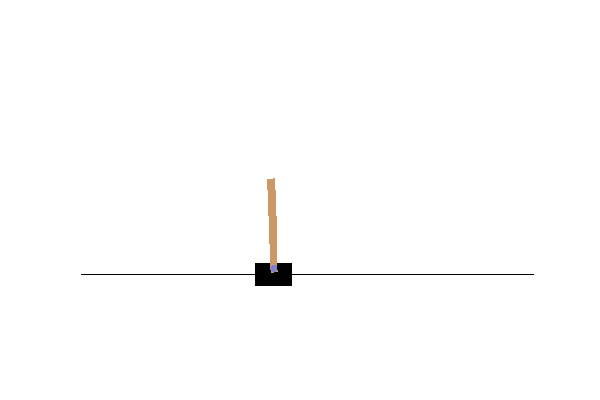
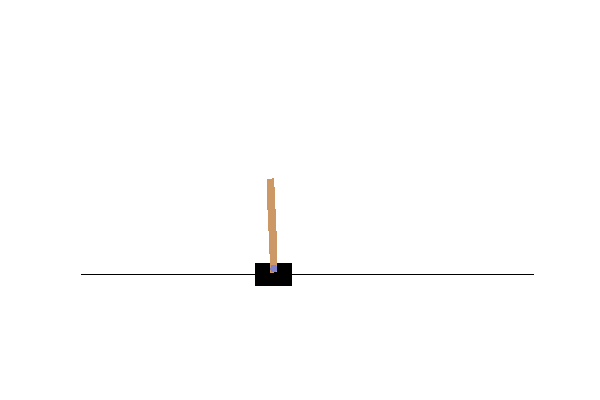
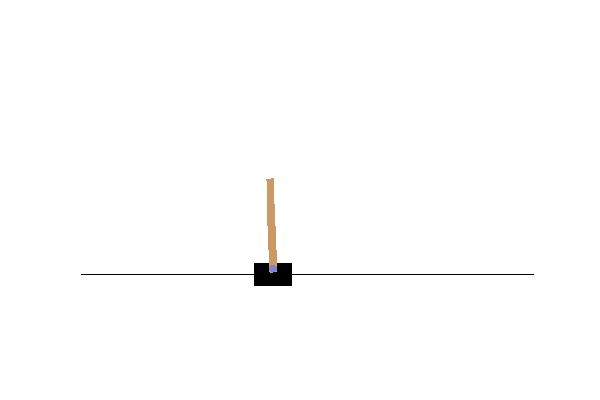
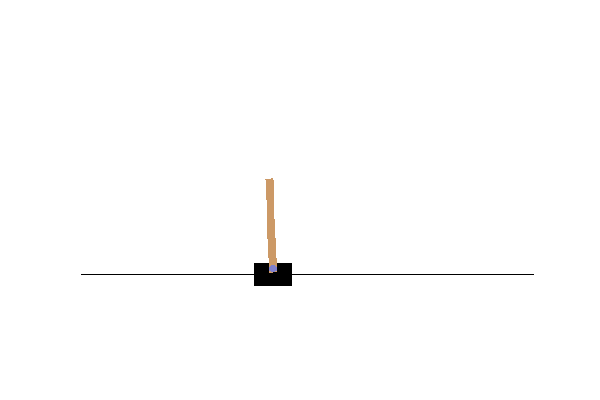
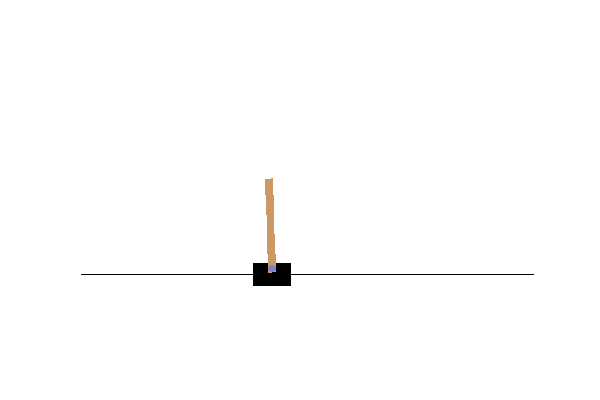
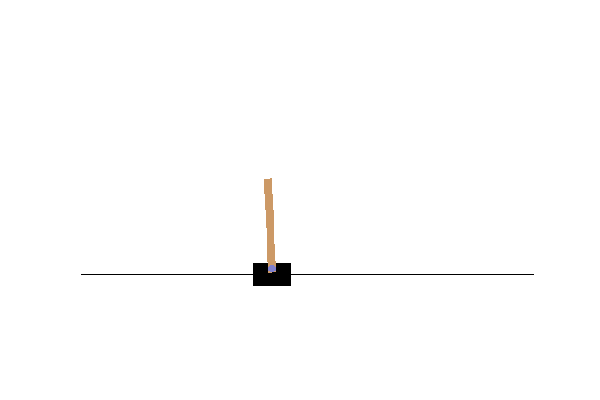
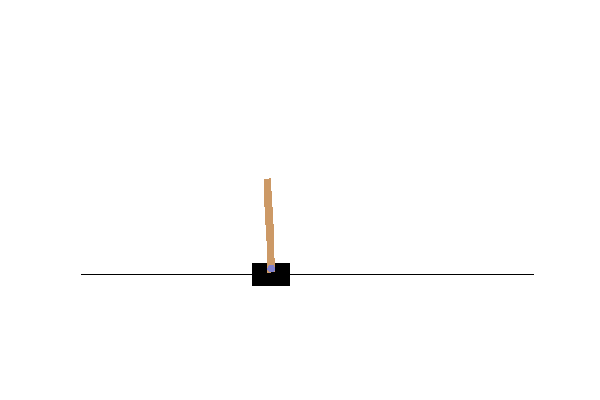
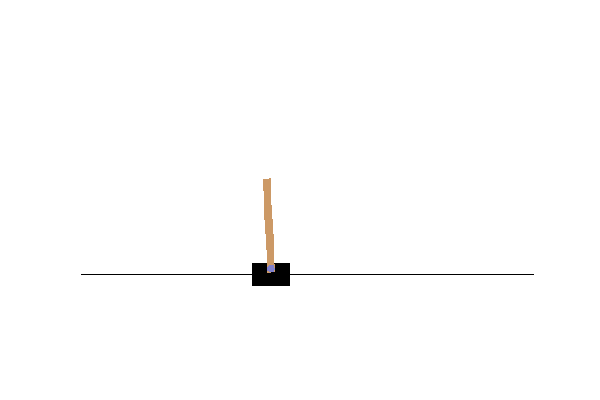
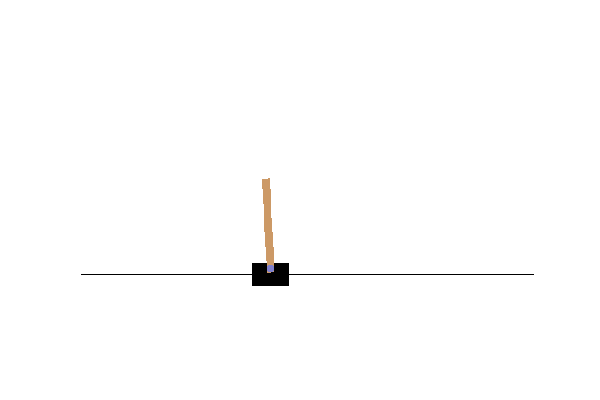
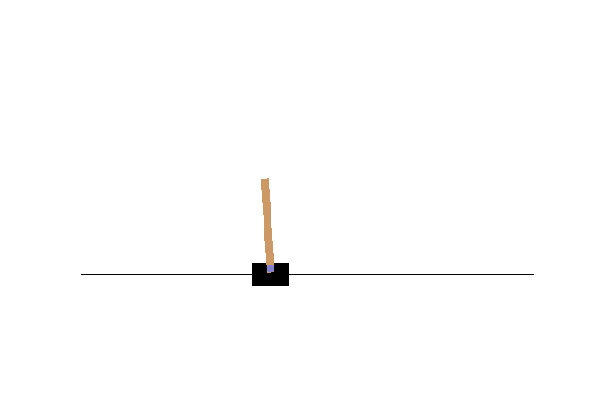
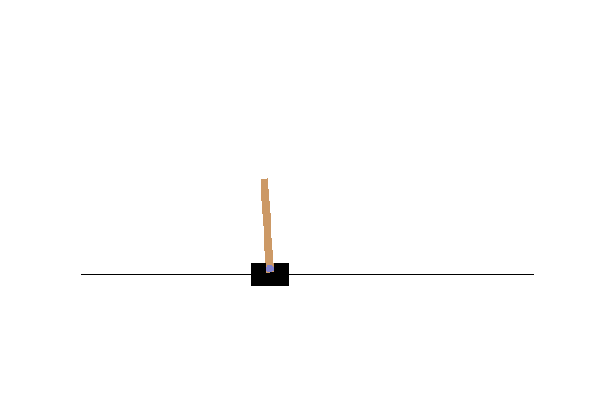
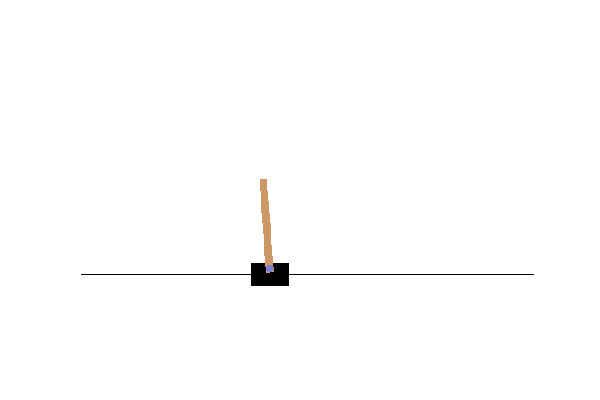
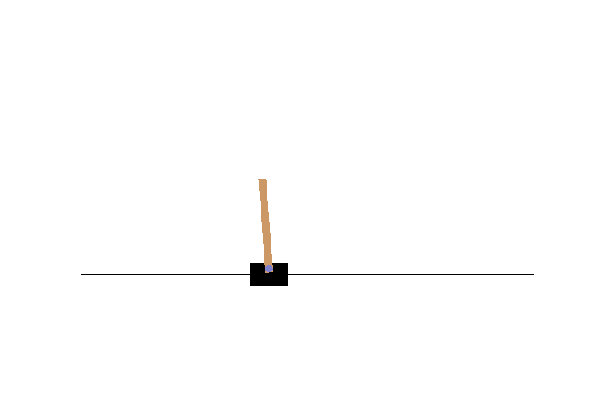
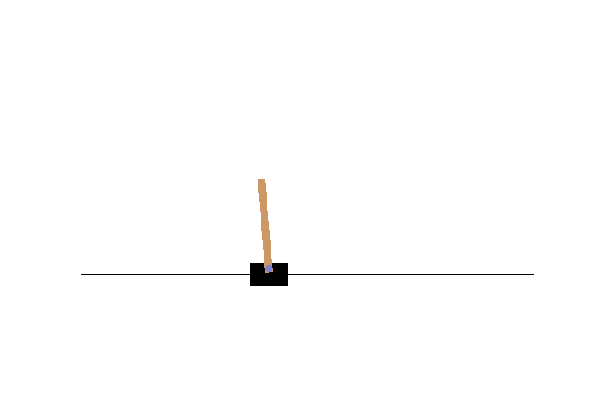
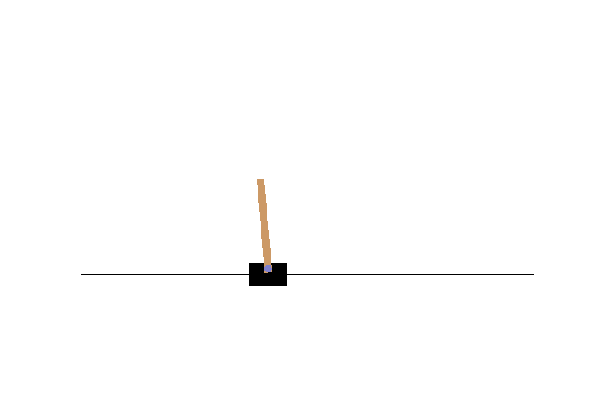
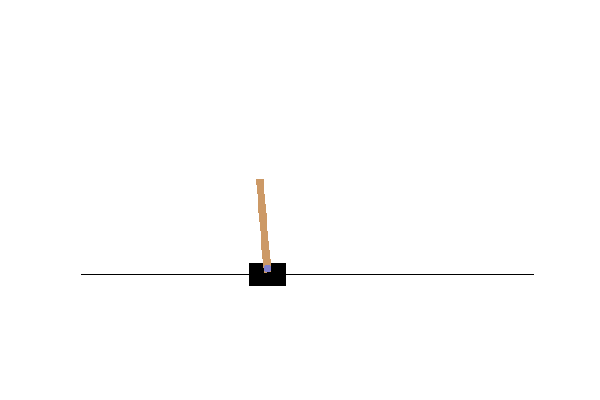
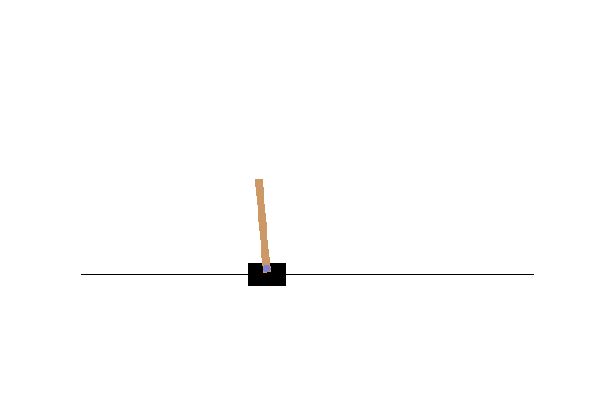
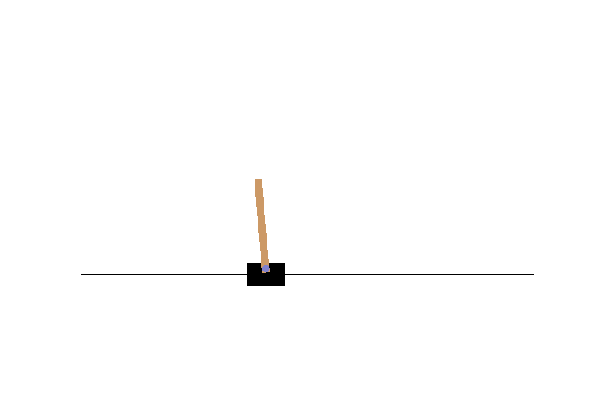
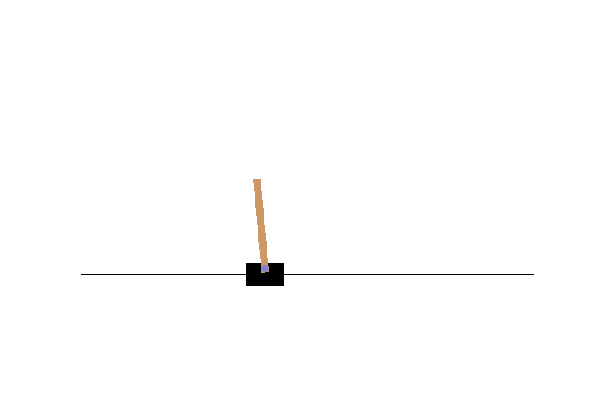
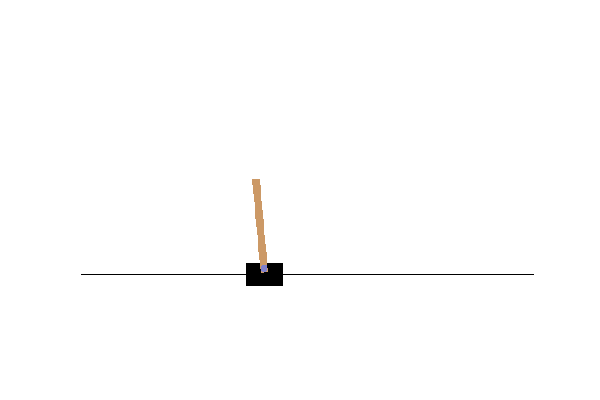
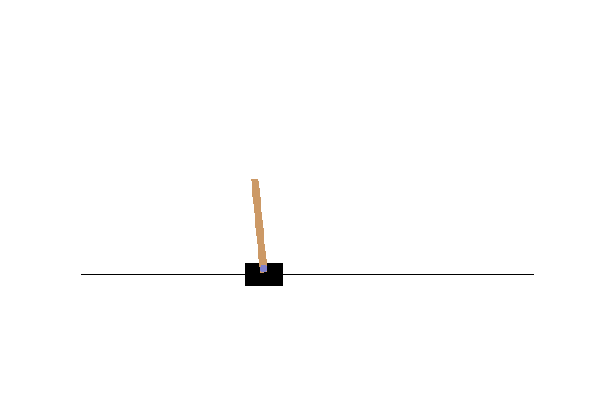
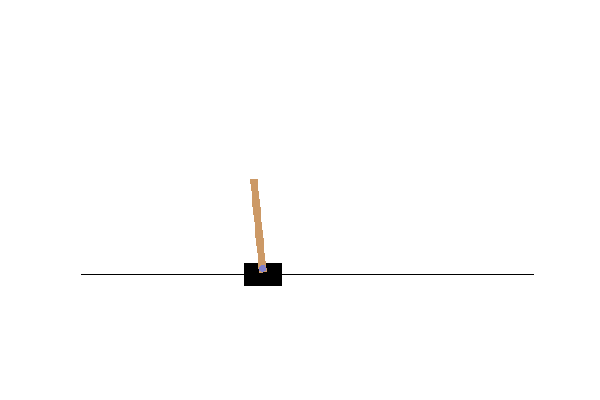
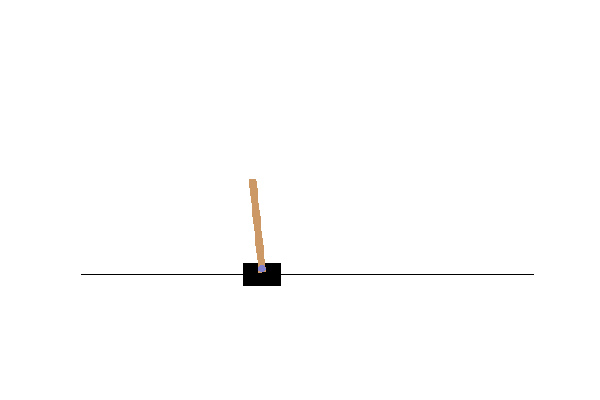
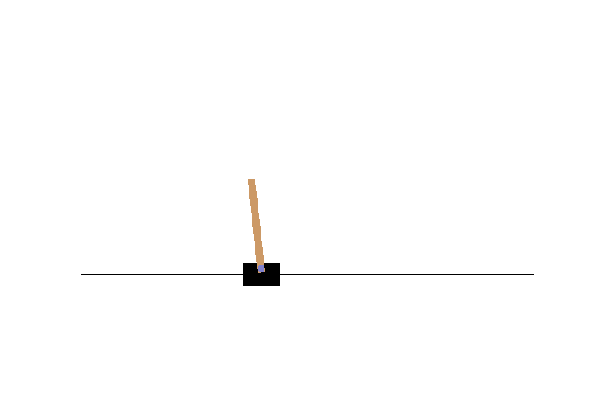
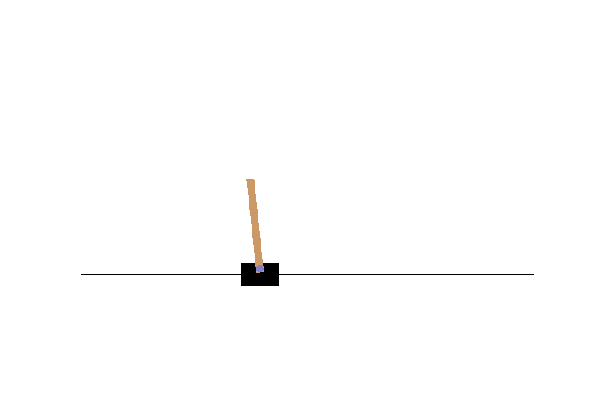
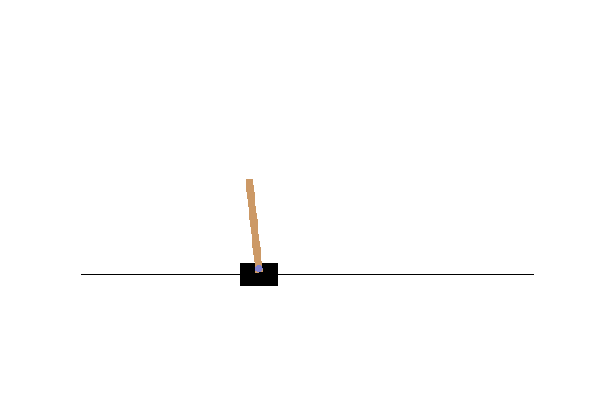
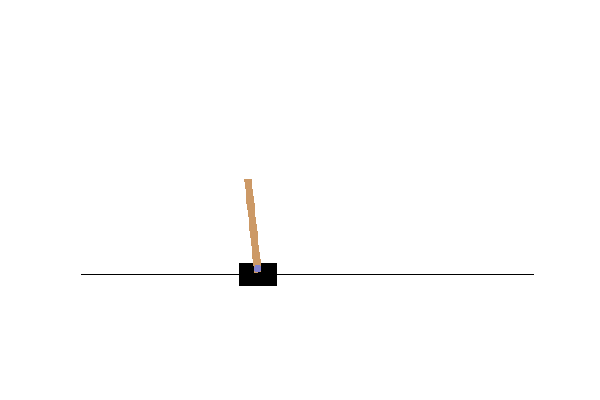
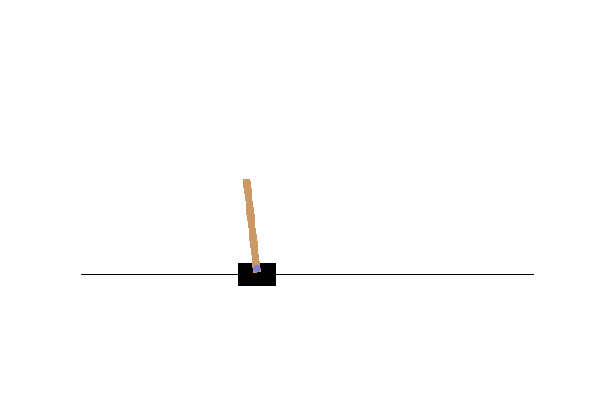
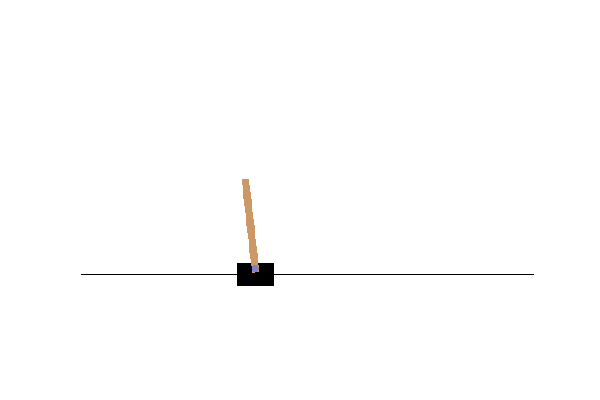
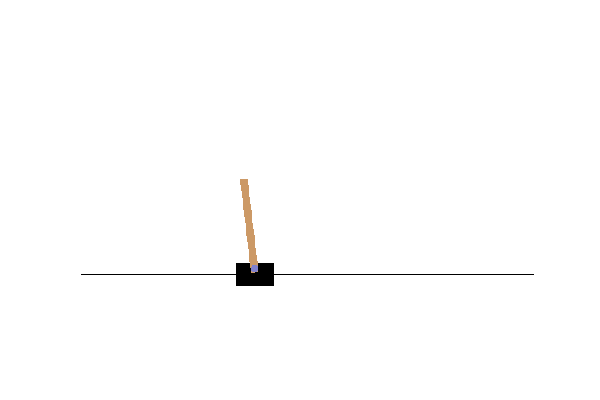
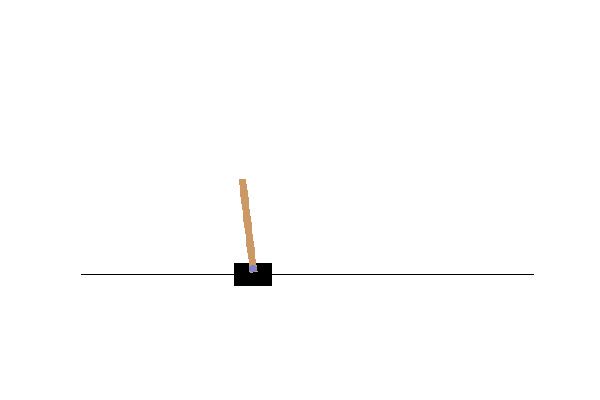
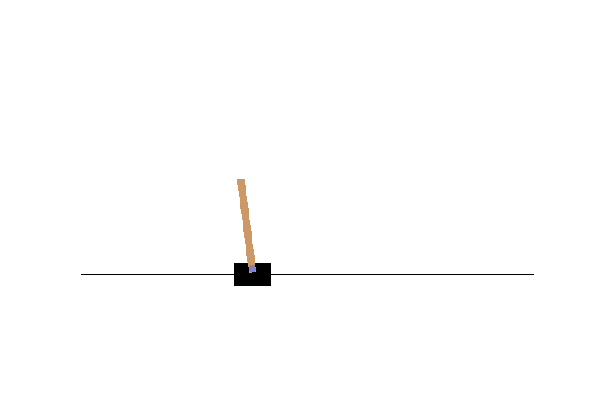
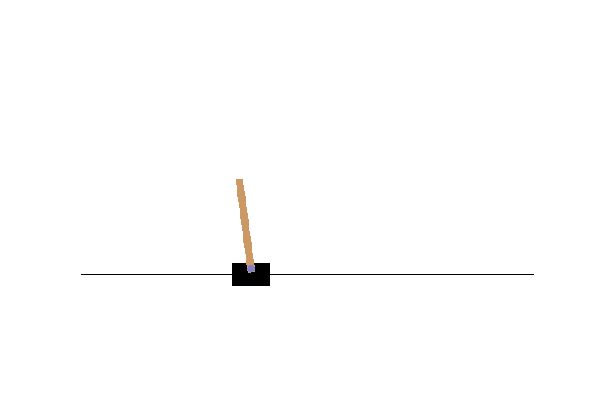
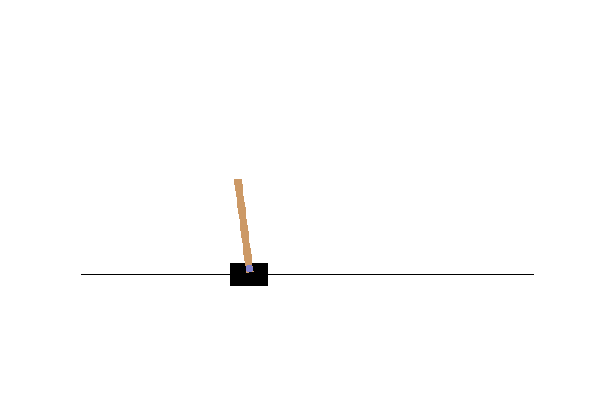
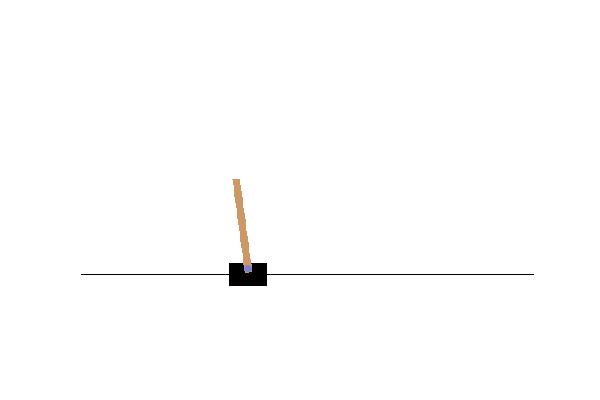
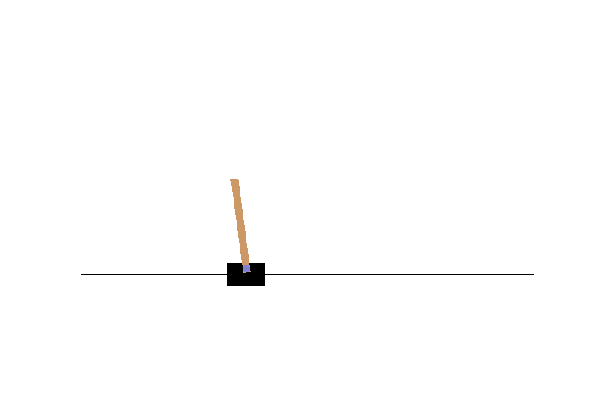
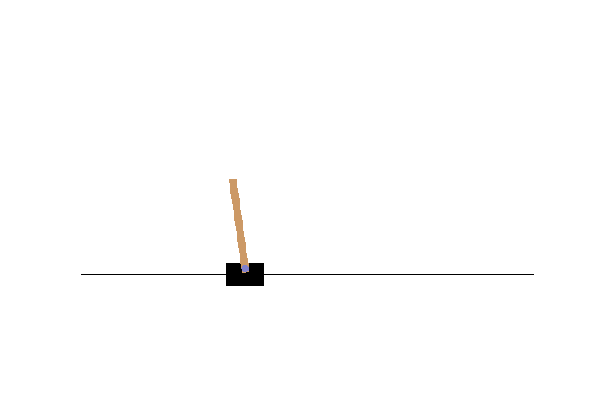
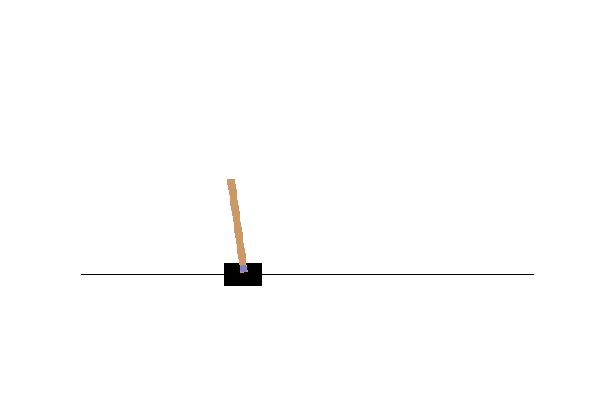
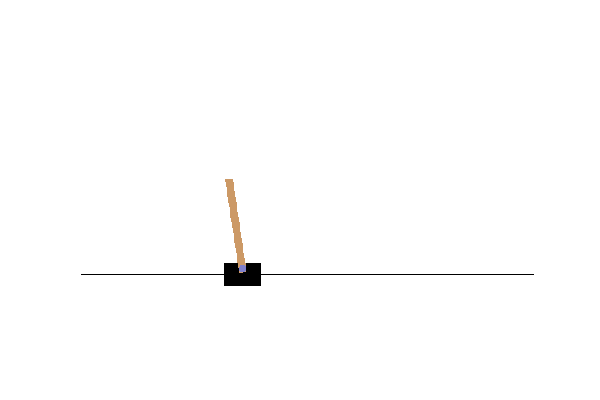
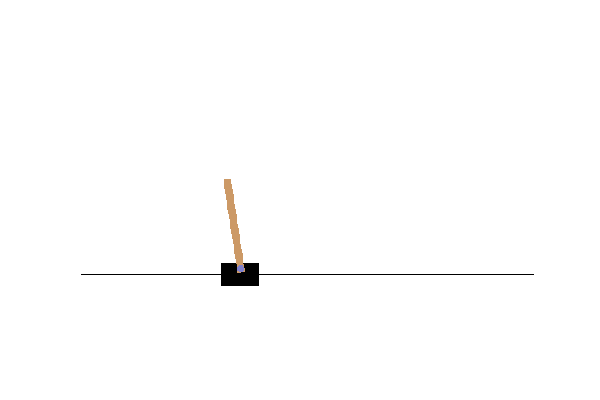
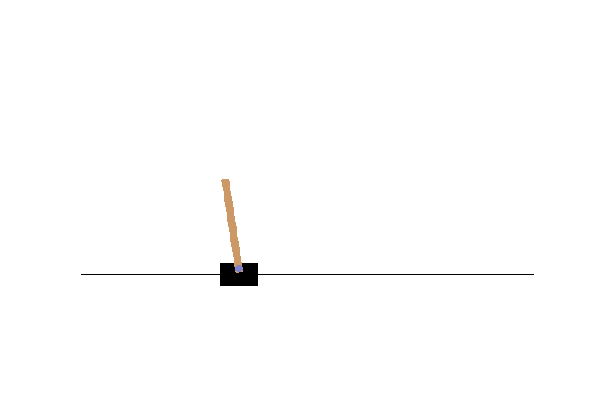
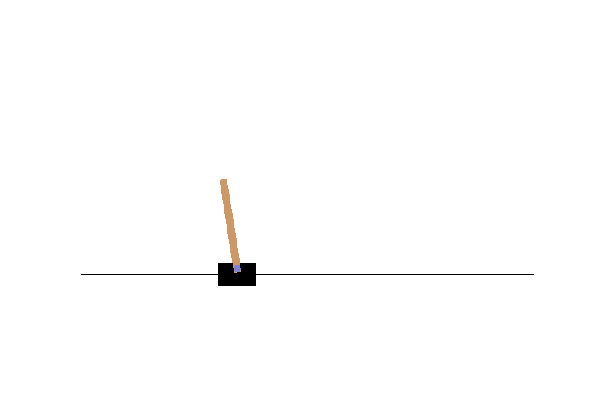
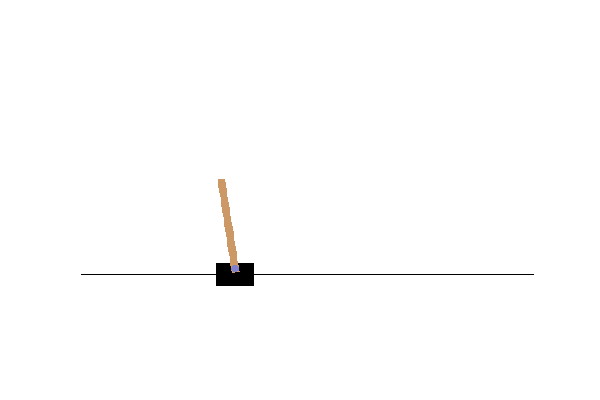
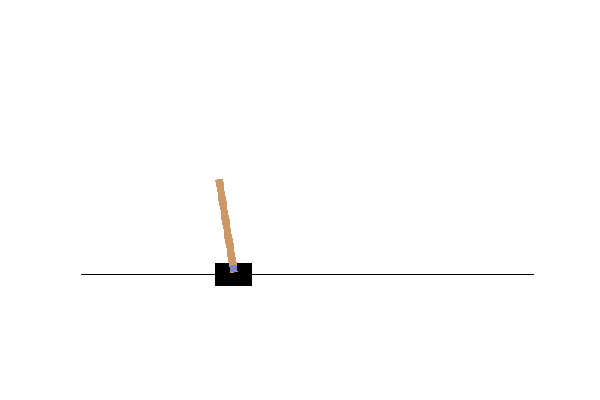
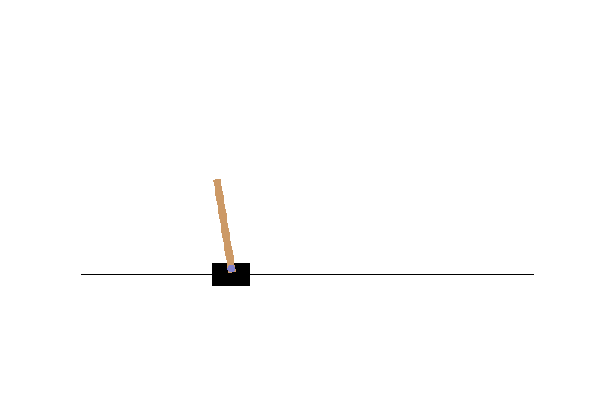
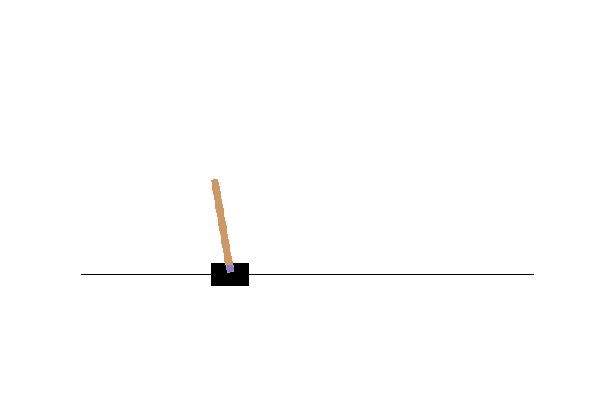
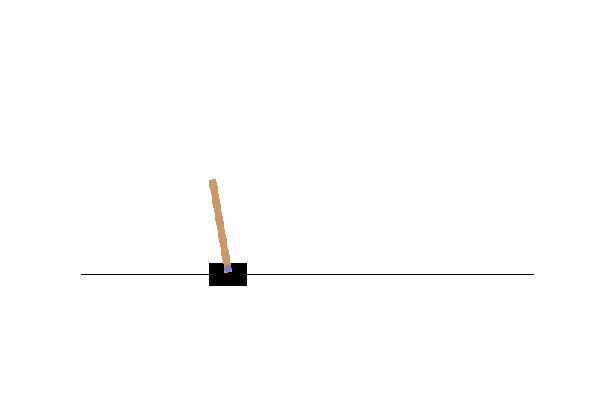
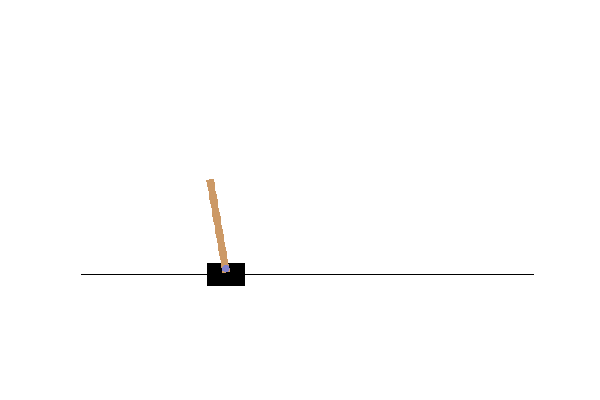
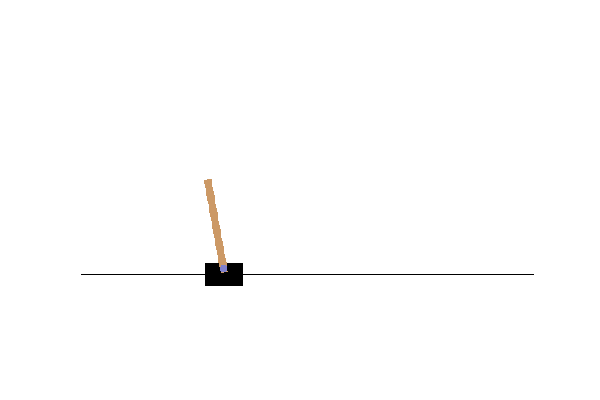
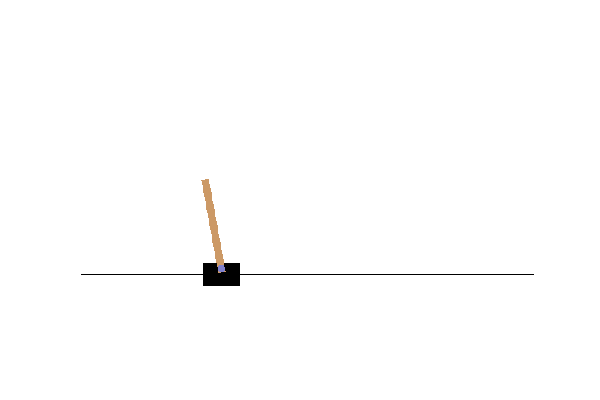
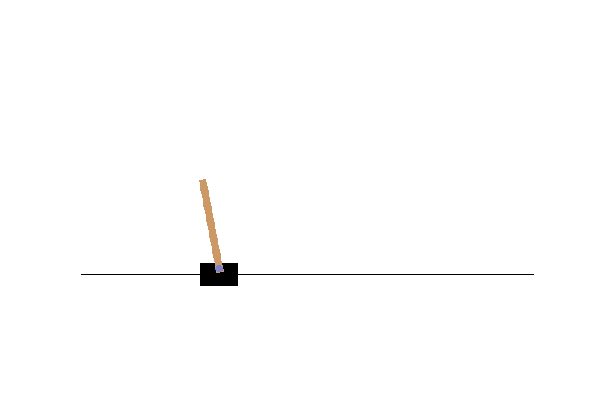
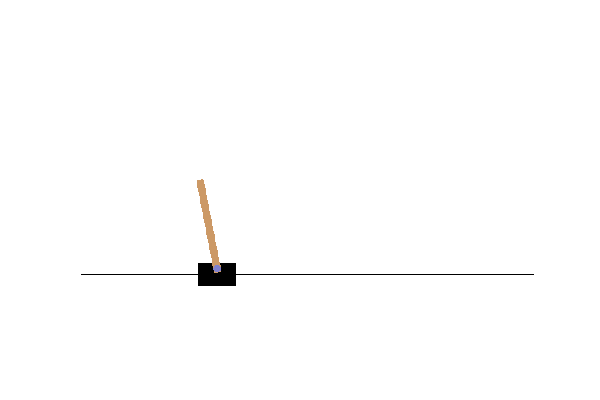
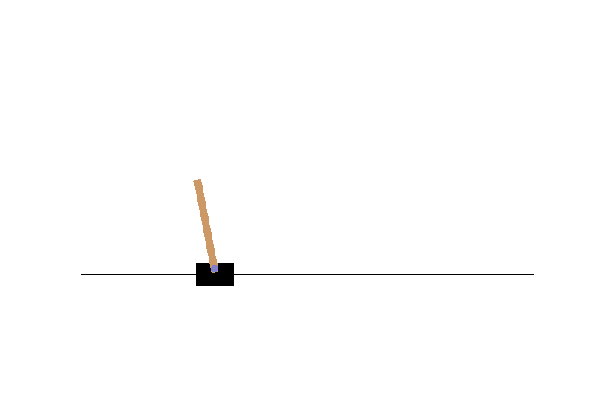
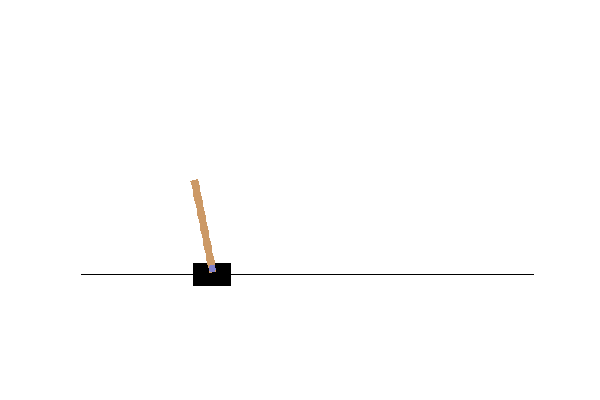
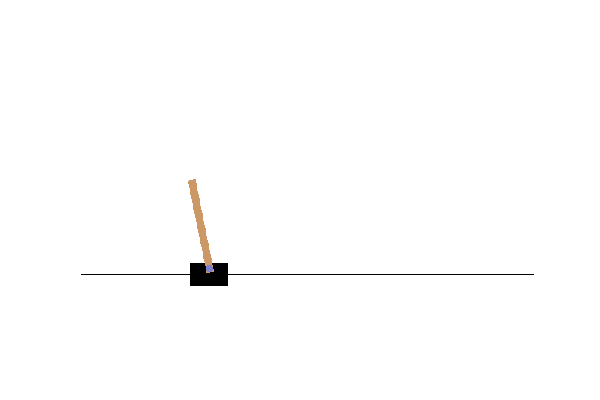
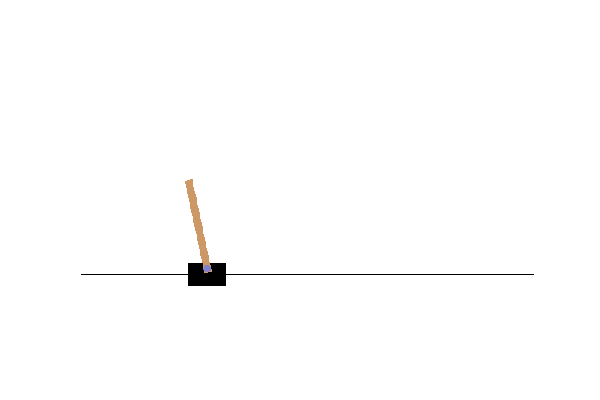
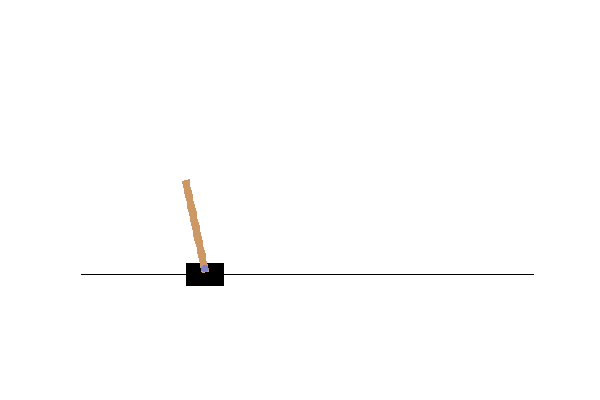

In [7]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

    
display_frames_as_gif(frames)


## Video 3: Reinforcement learning explained
Now that we are able to find the best parameters for this simple problem we can also realize that this approach is not going to work on a more interesting problem. That's why we are going to learn what [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), and specifically [q-learning](https://en.wikipedia.org/wiki/Q-learning), can do!

Imagine that you are playing a game of super mario brothers. This game gives you certain rewards when you: 
- Grab a coin
- Kill a goomba
- Finish a level

It also gives you penalties whener you fall off a cliff or walk against an enemy... 

The first time you played the game you simply pressed random buttons, and learned after you got penalties and rewards after you accidentally performed something good. 

The idea of reinforcement learning is letting an agent perform random actions and learn from them. To do this we construct a function that can determine the quality of a state-action pair. 

Let's say you are in a certain state. For each action you can estimate the reward you expect to get performing that action. In addition to this estimated reward we want to be able to obtain a high reward in the long term. Jumping off a cliff to grab that one extra coin is not worth it if you can walk a bit further and gain a lot of coins without dying!

The function that estimates the (future) reward for an action and a state is indicated with Q(s,a). We can represent this with a neural network that takes a state as input and estimates the (future) reward of that state for each action. In case of the cartpole environment we take 4 values as input, and estimate two values (two possible actions) as output...

We update this function by looking at what state we reached after performing a certain action. As we now have a new state we assume our function is correct, and the future reward can be estimated with Q(next_s, a), taking the value of a which leads to the highest reward. We multiply the next state with a discount-constant gamma. A high gamma (close to 1) values long-term rewards, while a low gamma (closer to 0) only values short-term rewards...

The mathematical expression we use to update our q-function is: 

![reward fucntion](http://www.pinchofintelligence.com/wp-content/uploads/2017/07/rewardfunction.png)

### Implement it in TensorFlow
There are multiple ways to construct the reward-estimation function. In our case we are going to build a neural network with TensorFlow that estimates the expected (future)reward. 

To do this we need three input placeholders: the state, action our network took, and the reward it eventually got. This reward it eventually got is what we get from the same network! Using the state as input we eventually want to produce a reward for each possible action (remember: there are two possible actions). 

In [9]:
tf.reset_default_graph()
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")

layer1 = tf.layers.dense(networkstate, 16, activation=tf.nn.relu, name="dense1")
layer2 = tf.layers.dense(layer1, 32, activation=tf.nn.relu, name="dense2")
layer3 = tf.layers.dense(layer2, 8, activation=tf.nn.relu, name="dense3")
predictedreward = tf.layers.dense(layer3, 2, name="dense4")


We can only determine a loss based on the action the network took. As loss we can take the mean squared error of our prediction for this action, and the predicted value to the next state...

In [10]:
with tf.name_scope("lossdeterminer"):
    action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")
    qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
    loss = tf.reduce_mean(tf.square(networkreward - qreward))

tf.summary.scalar('loss', loss)
tf.summary.scalar('mean_max_reward', tf.reduce_max(predictedreward))

optimizer = tf.train.AdamOptimizer().minimize(loss)
#optimizer = tf.train.RMSPropOptimizer(0.01).minimize(loss)
merged_summary = tf.summary.merge_all()


### Replay memory
Now we have a network, optimizer, and are logging loss and the mean of the max predicted reward each timeframe we can start training! As you might remember it's 

In [11]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/normal/'+str(logging_dir_n),sess.graph)
logging_dir_n +=1
sess.run(tf.global_variables_initializer())


In [14]:
BATCH_SIZE = 128
GAMMA = 0.9
FRAMES_TO_PLAY = 50001
MIN_FRAMES_FOR_LEARNING = 1000

### Training

In [12]:
def learn(replay_memory):
      ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward
        nextstates = [var[4] for var in experiences]
        pred_reward = sess.run(predictedreward, 
                               feed_dict={networkstate:nextstates})
        
        ### Set the "ground truth": the value our network has to predict:
        for index in range(BATCH_SIZE):
            state, action, reward, terminalstate, newstate = experiences[index]
            predicted_reward = max(pred_reward[index])
            
            if terminalstate:
                delayedreward = reward
            else:
                delayedreward = reward + GAMMA*predicted_reward
            totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in totrain]
        actions = [var[1] for var in totrain]
        rewards = [var[2] for var in totrain]
        _, l, summary = sess.run([optimizer, loss, merged_summary], feed_dict={networkstate:states, networkaction: actions, networkreward: rewards})

        ### Show the progress 
        summary_writer.add_summary(summary, i_epoch)

  

### Running this in our environment
As a first learning program we are going to keep taking random actions, storing them in a replay memory, and learning from this replay memory what is good and what is bad. 

In [16]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select an action and perform this
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)

    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    learn(replay_memory)
    

### Evaluate
Let's see what our agent is able to do if we keep performing the action that is estimated to be the best action at each timestep!



Frames: 80



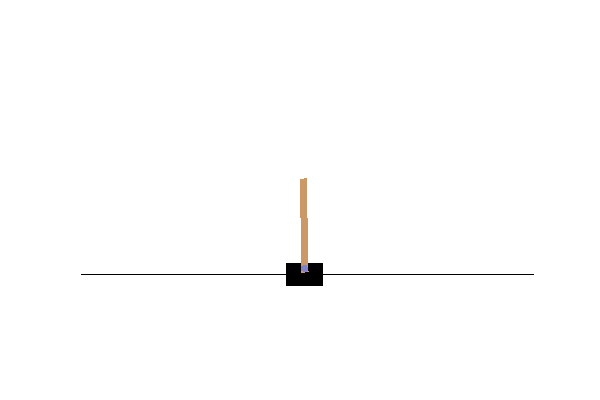
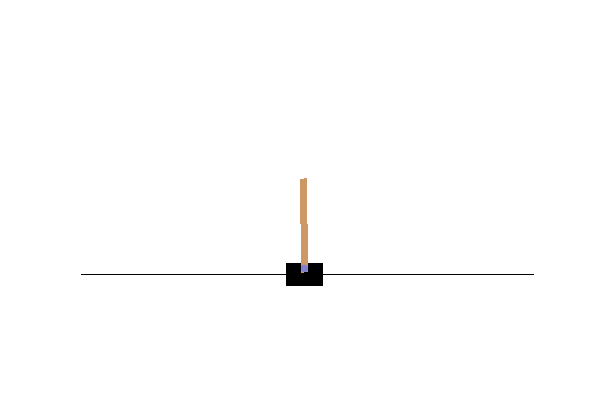
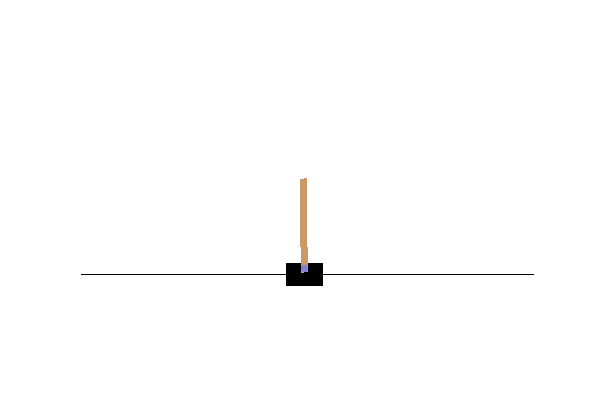
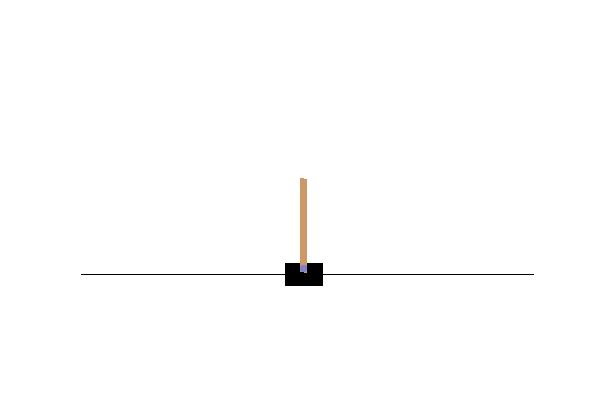
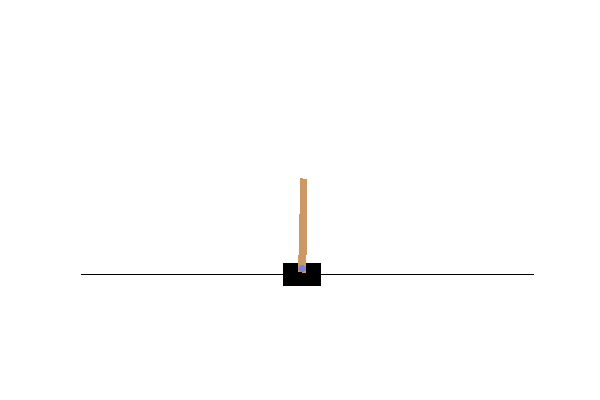
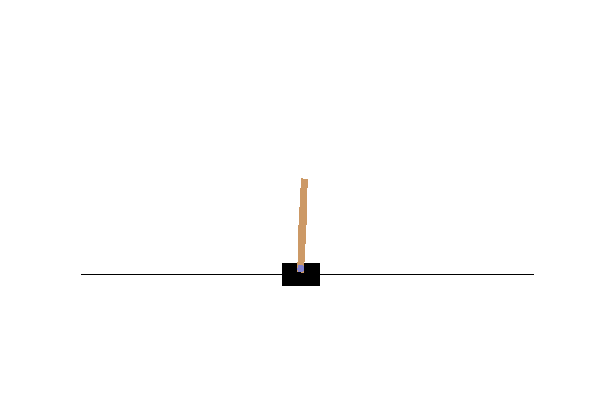
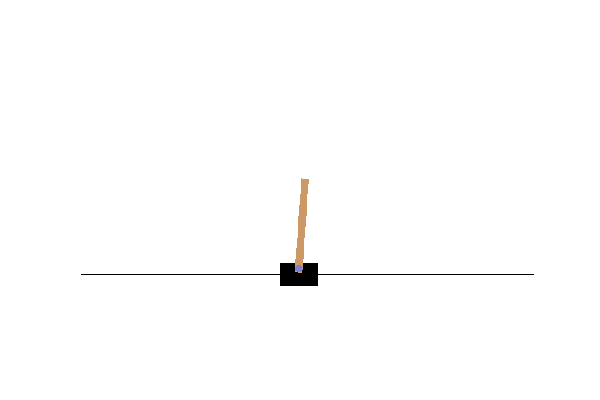
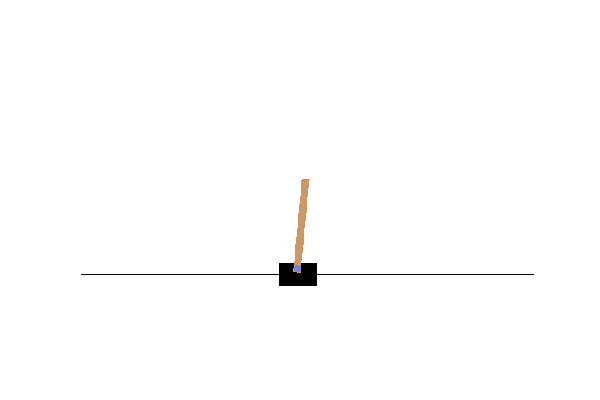
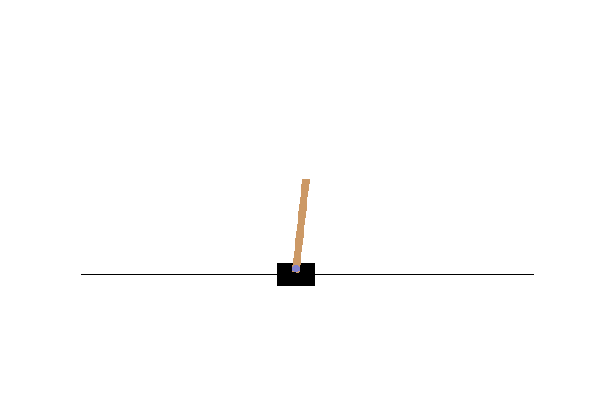
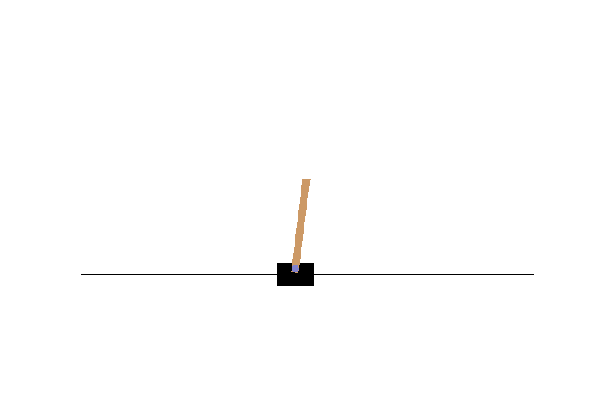
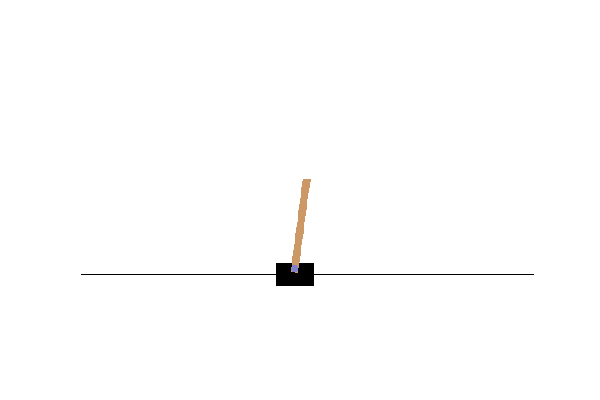
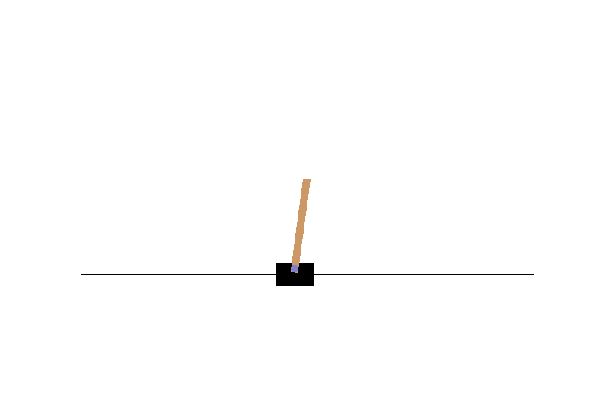
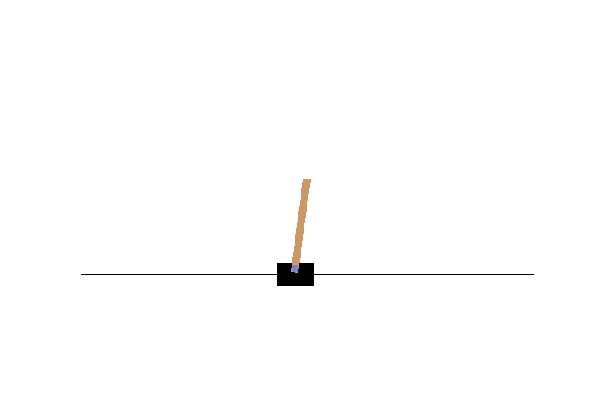
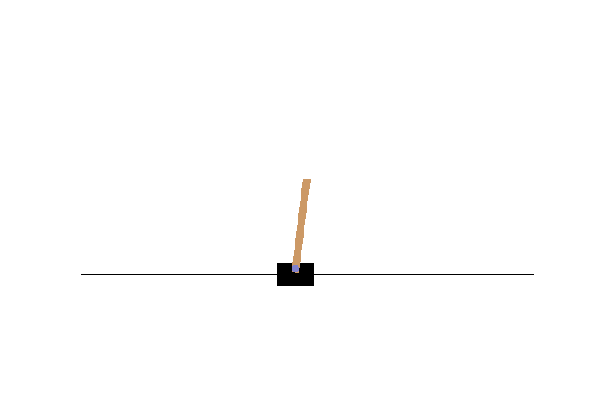
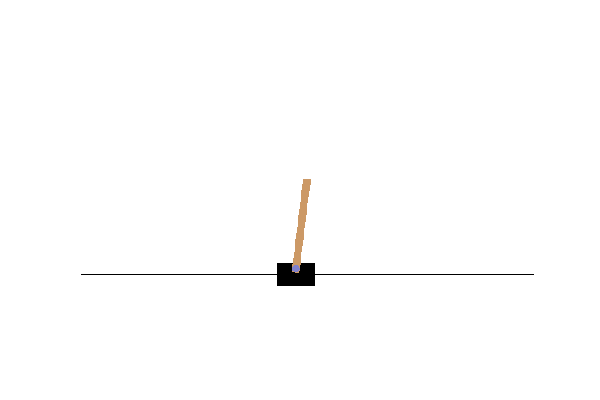
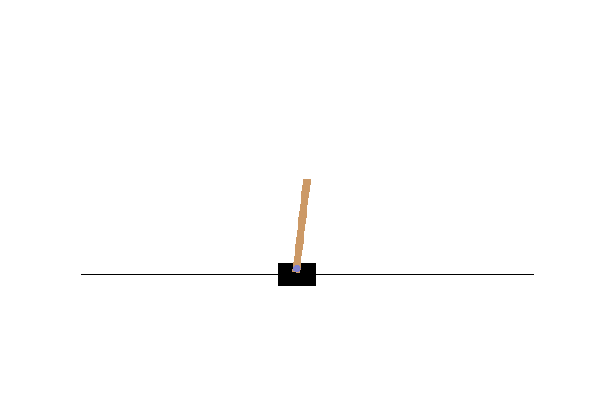
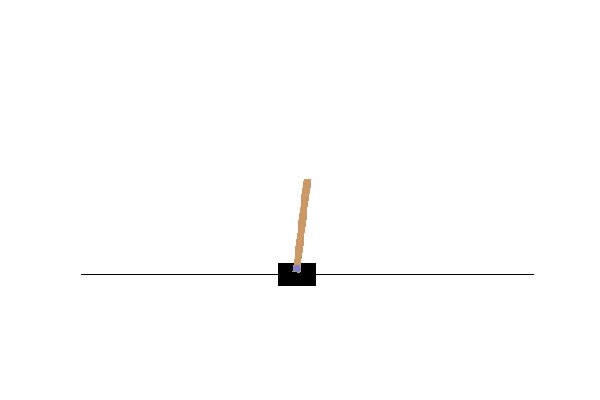
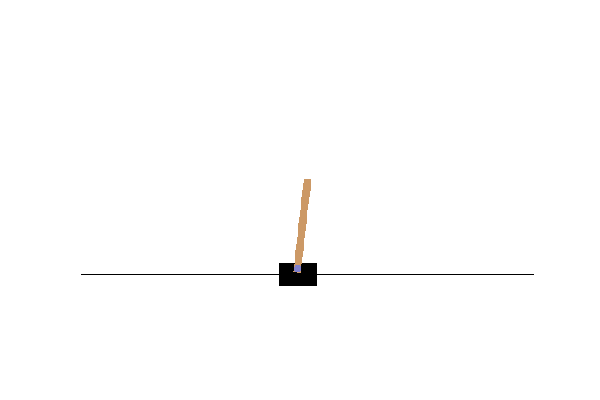
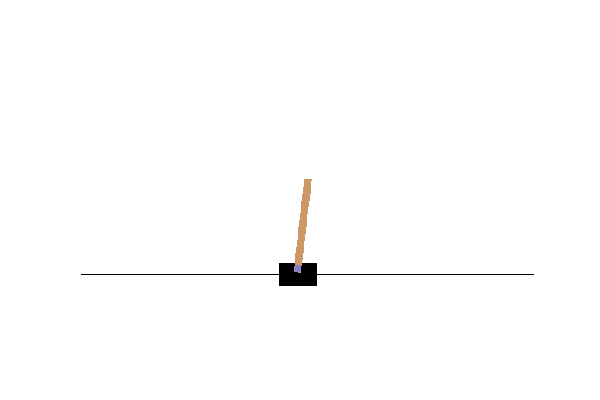
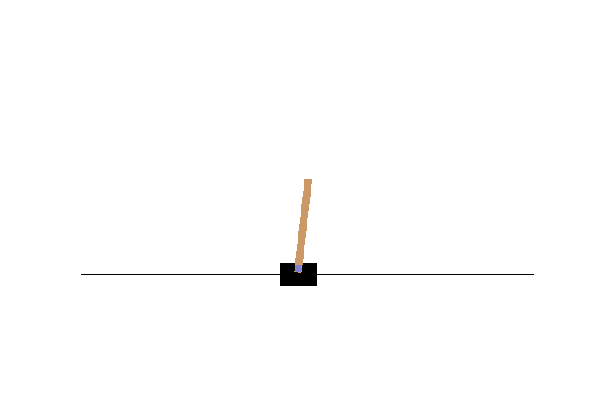
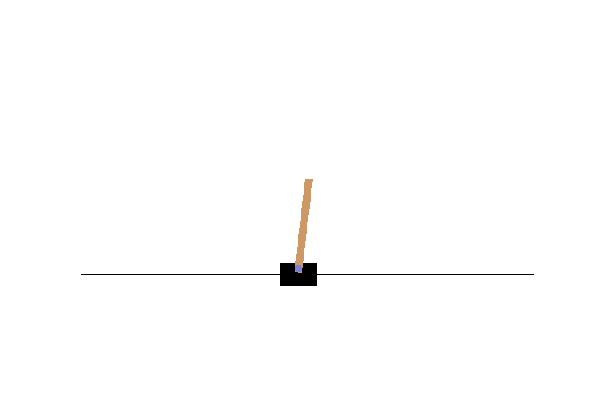
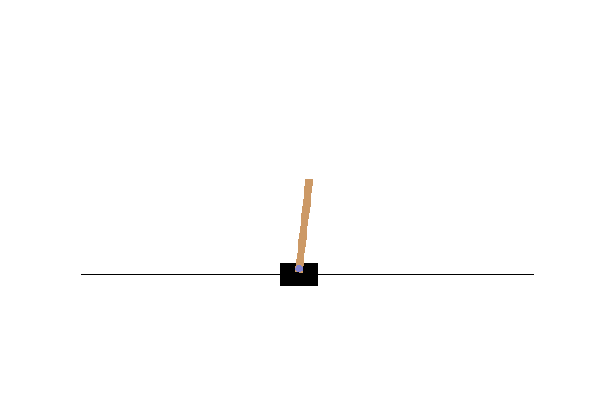
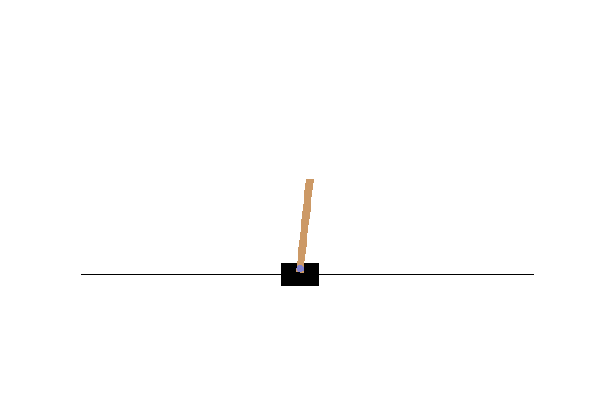
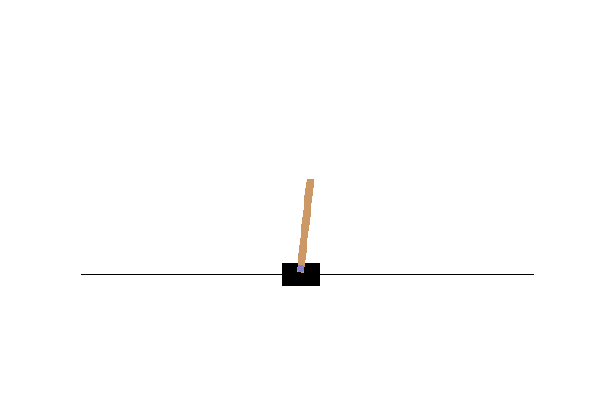
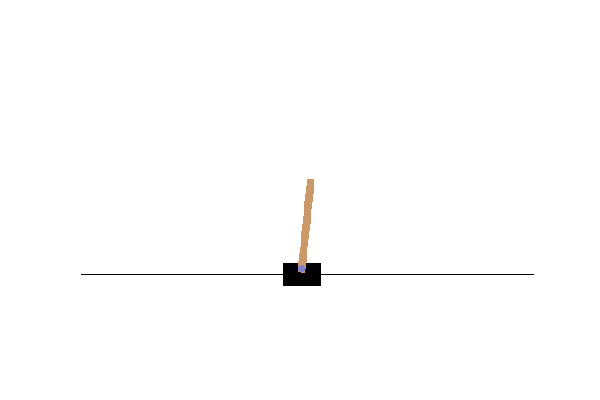
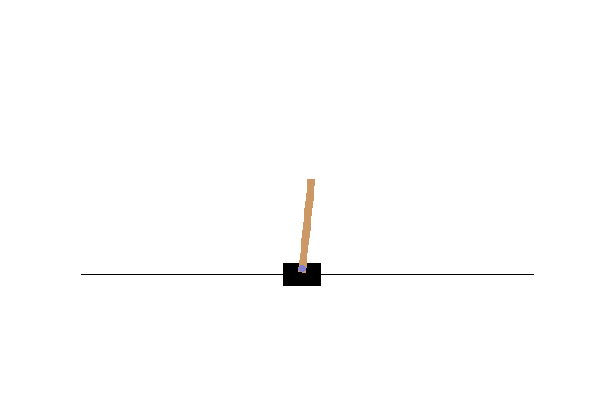
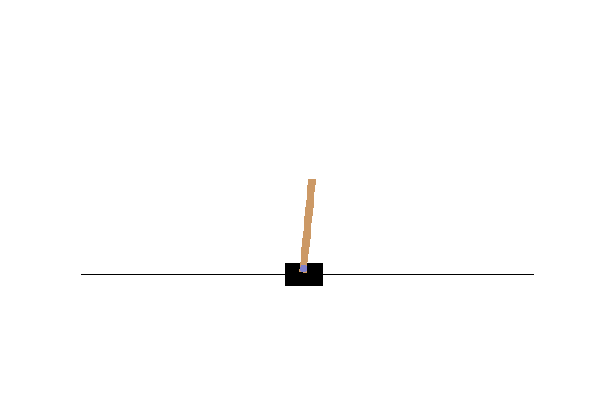
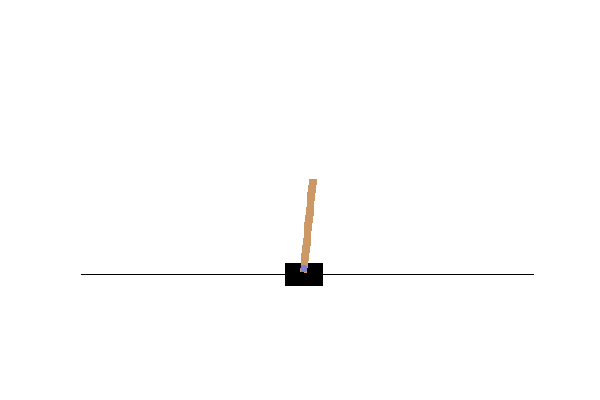
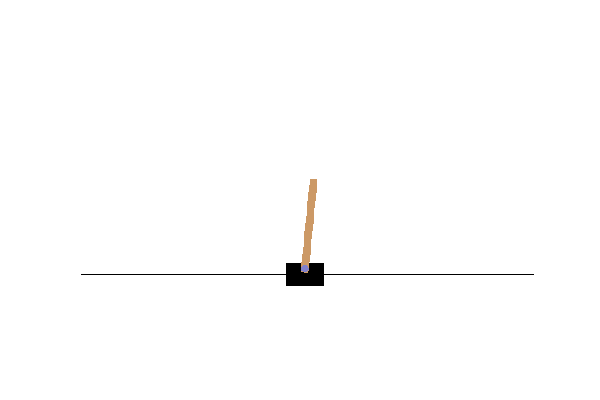
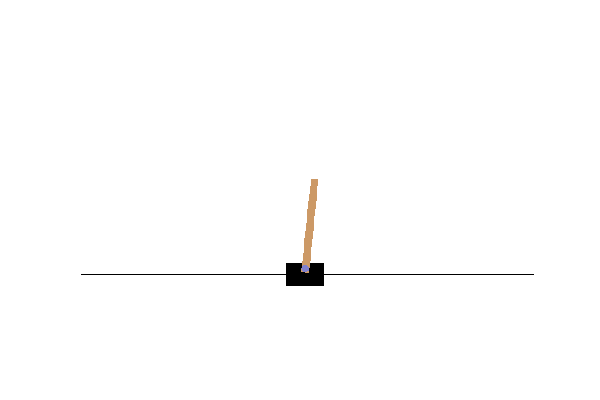
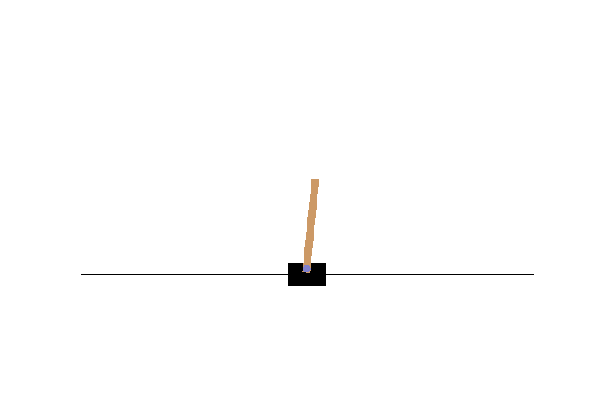
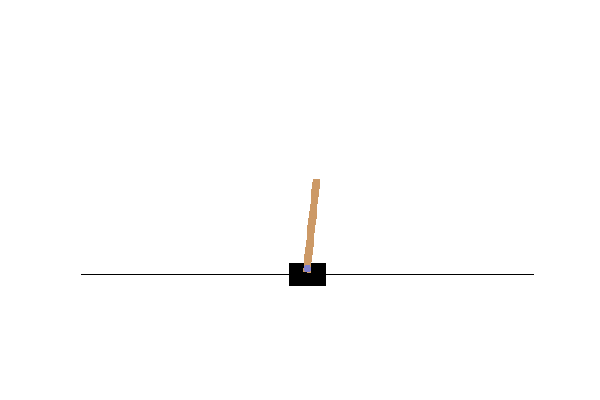
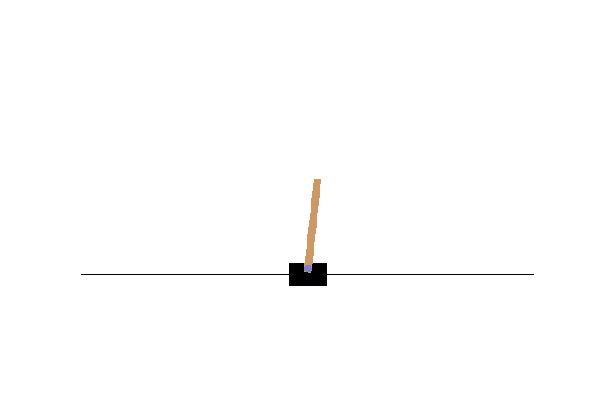
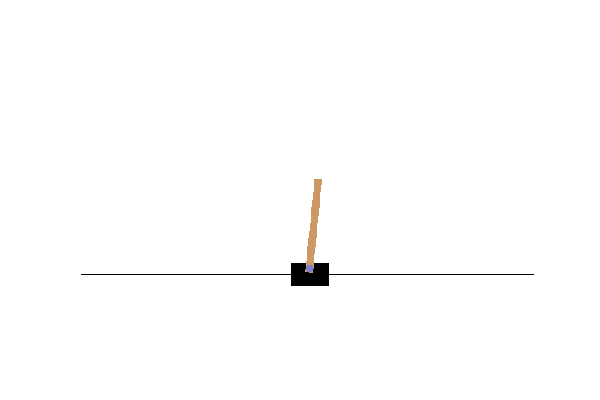
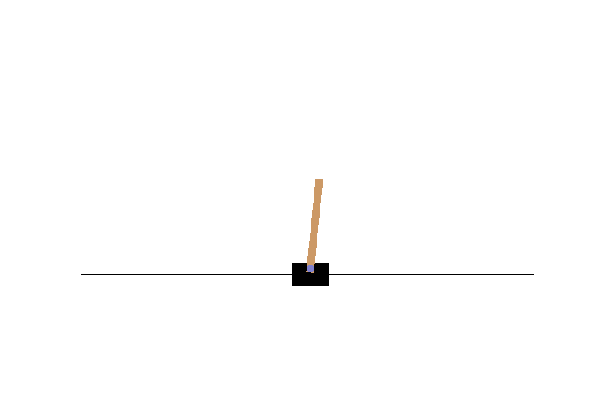
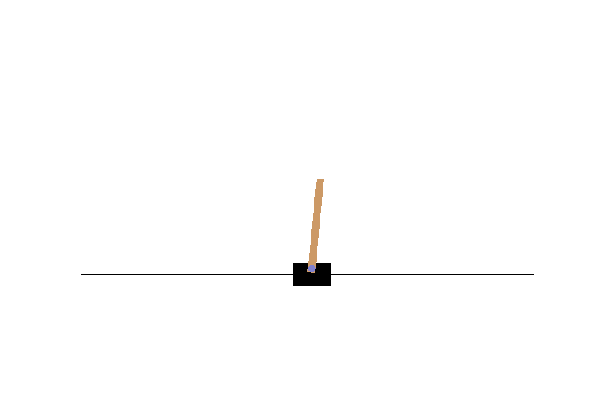
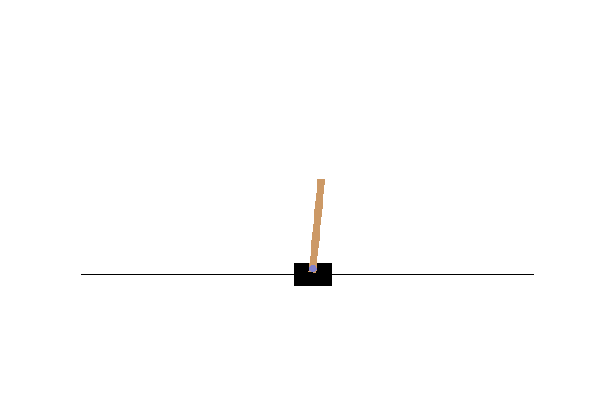
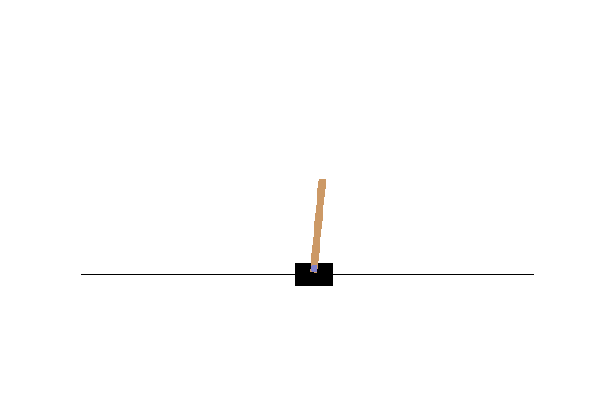
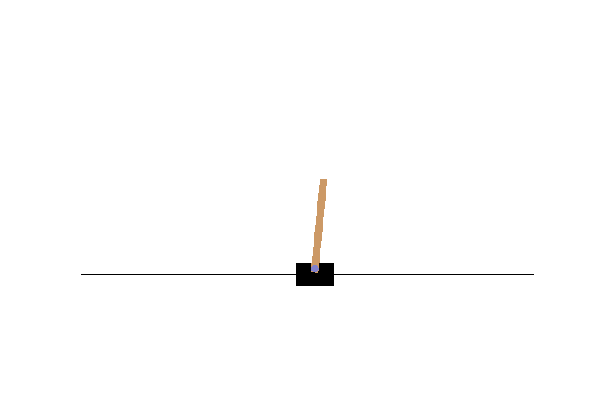
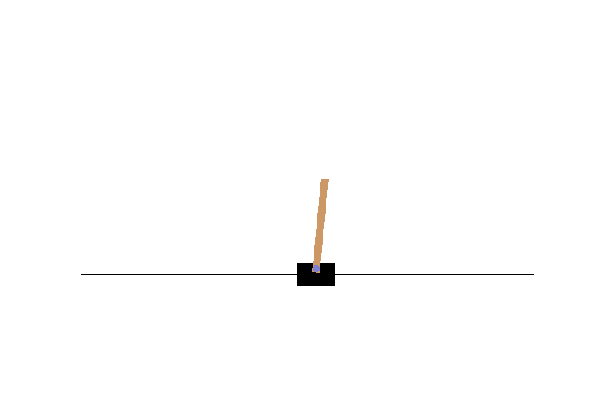
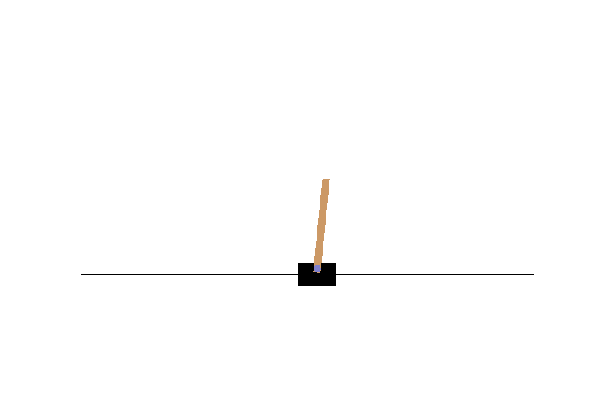
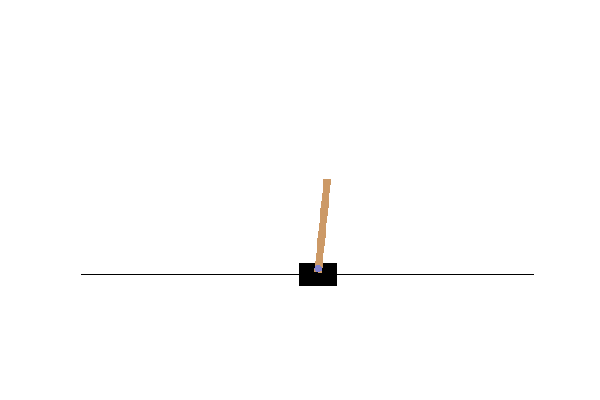
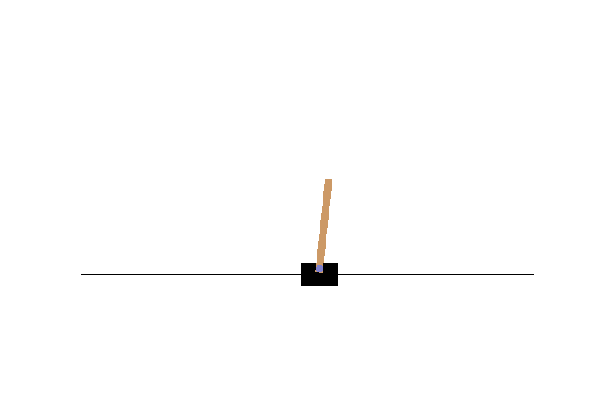
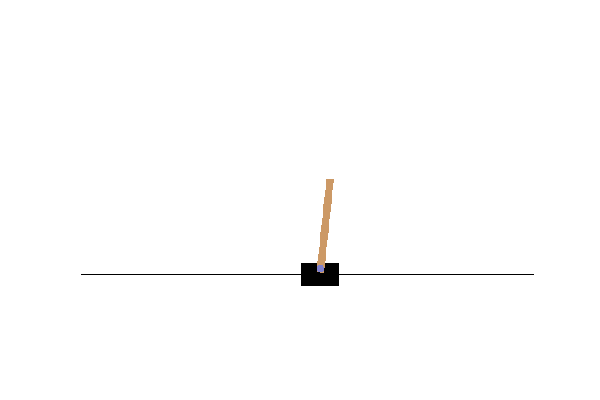
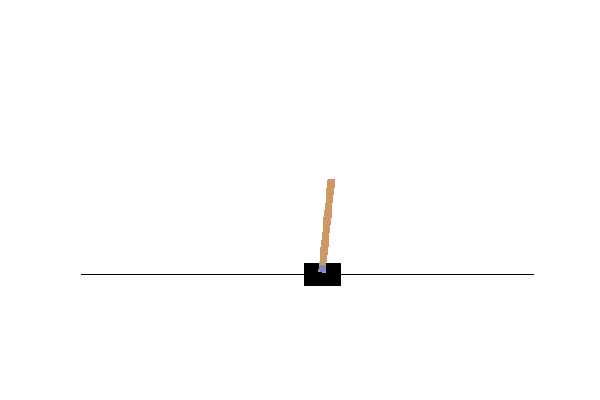
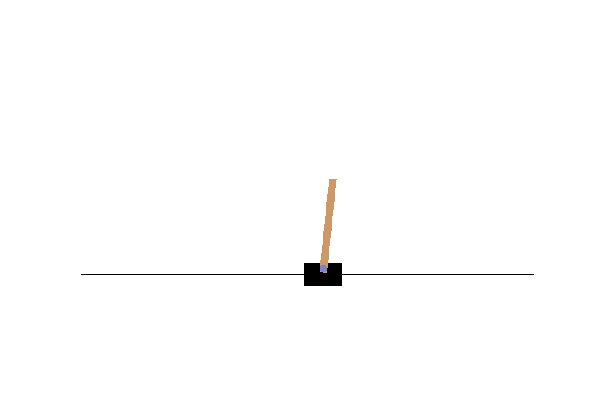
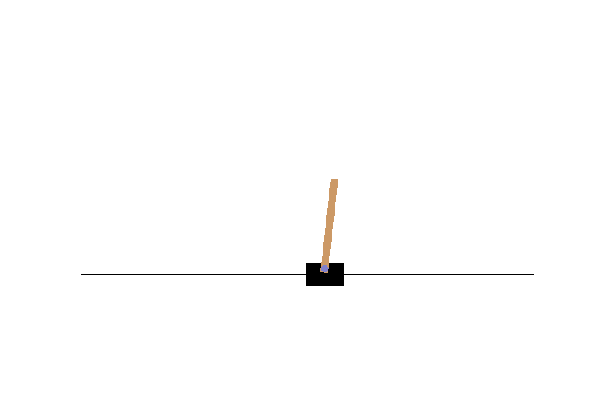
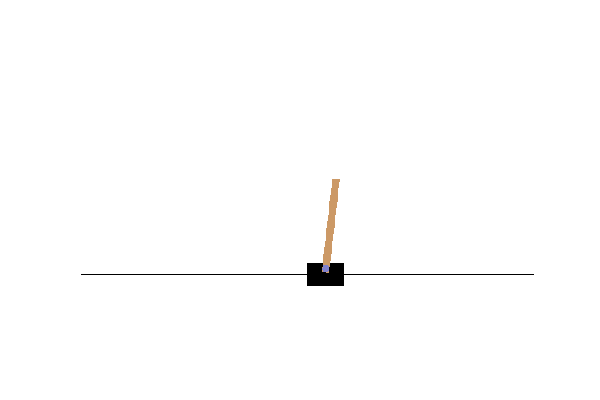
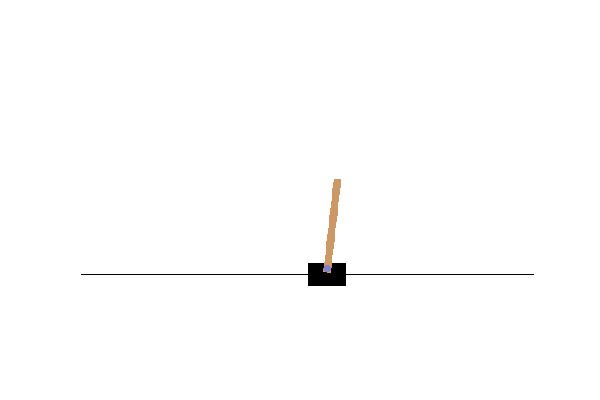
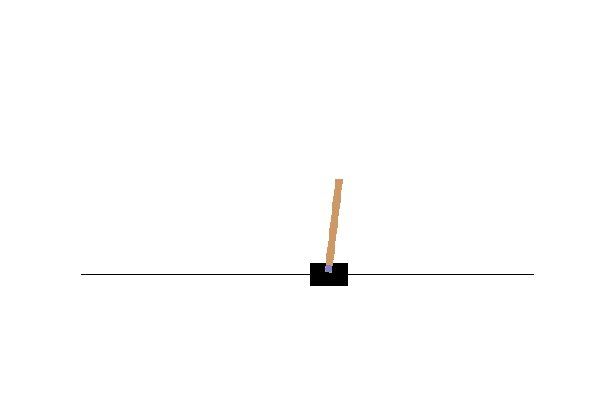
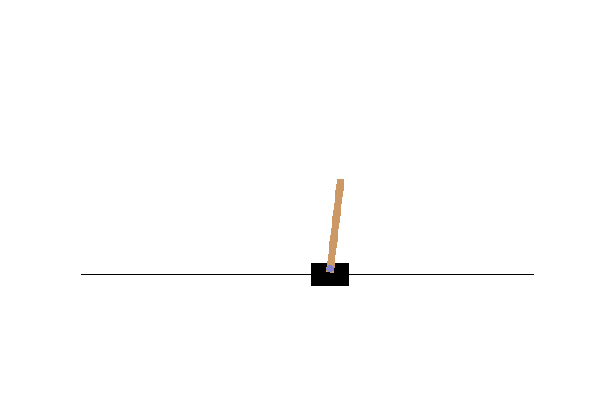
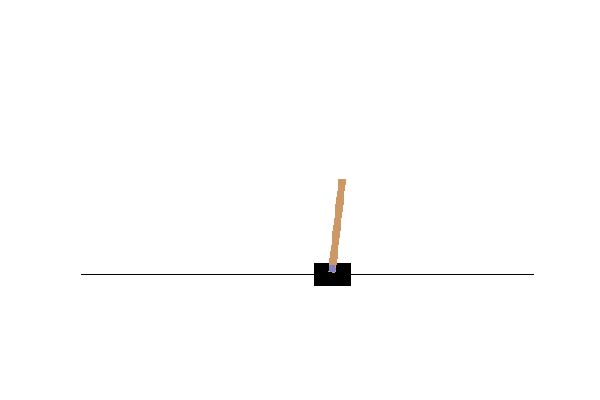
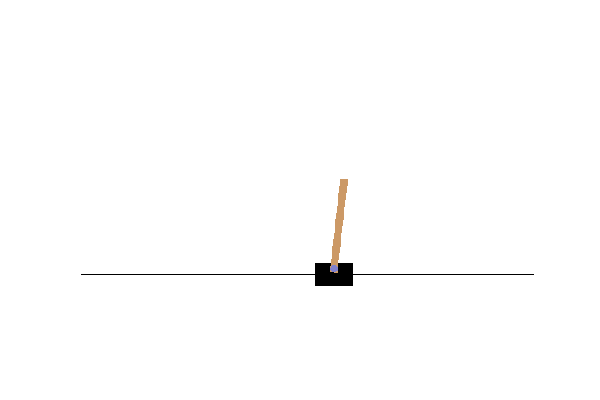
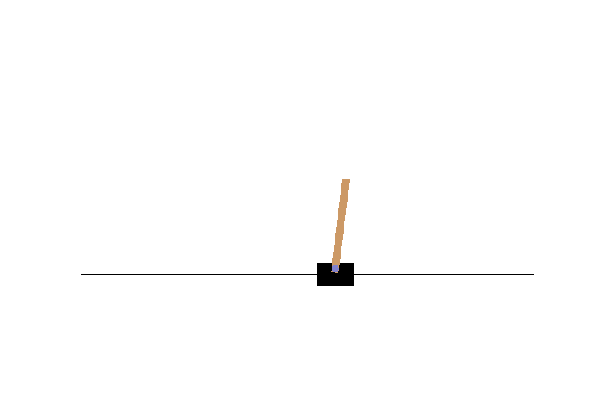
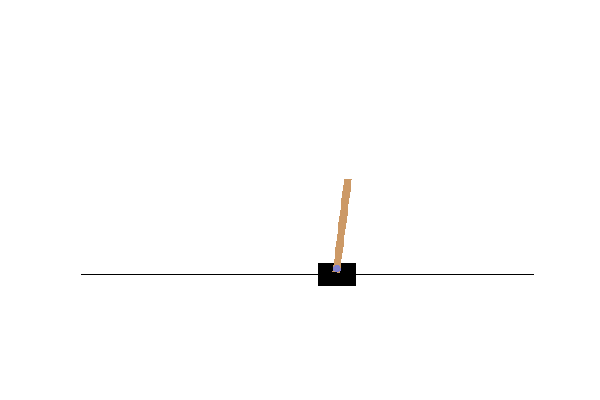
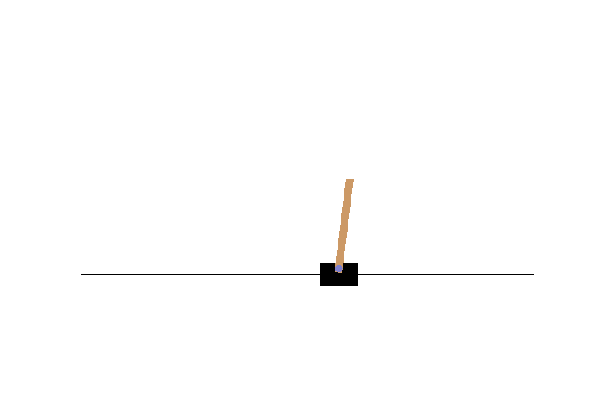
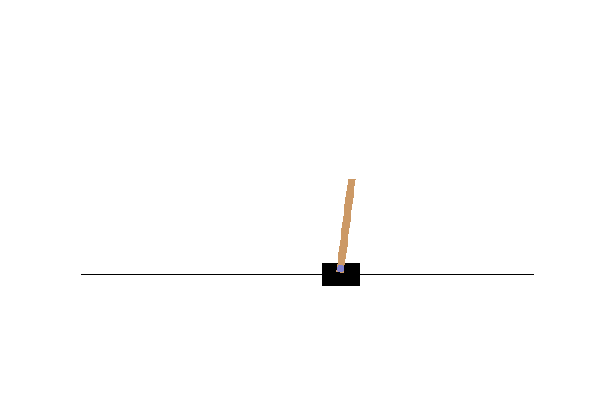
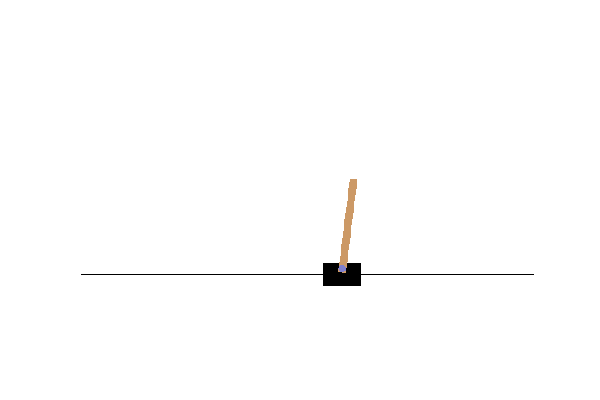
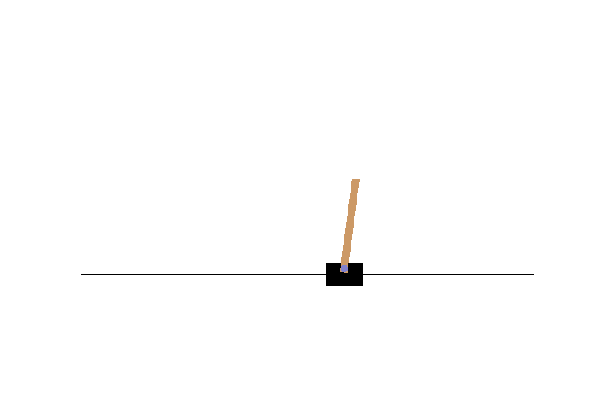
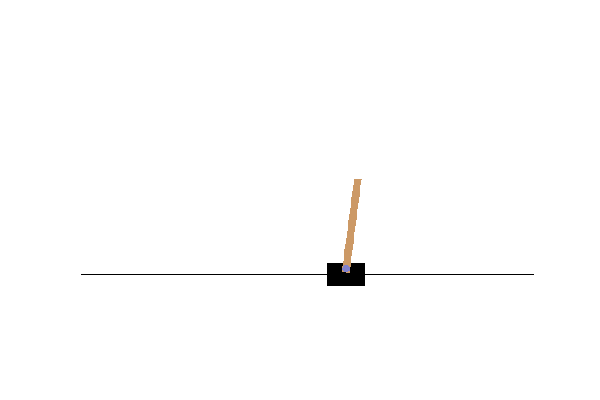
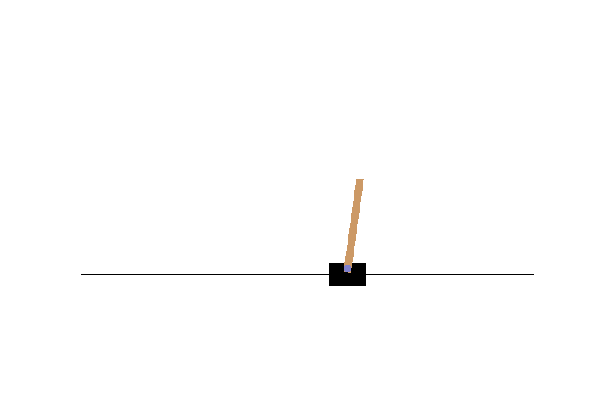
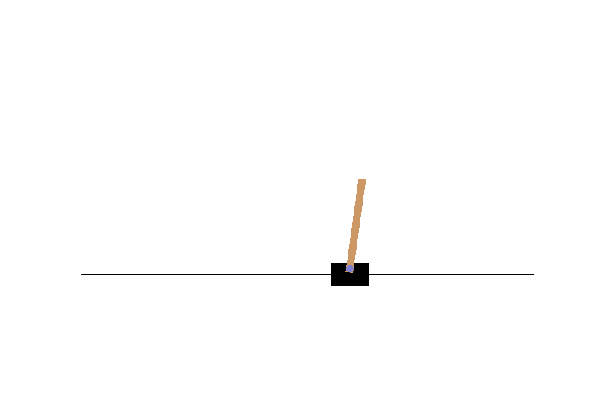
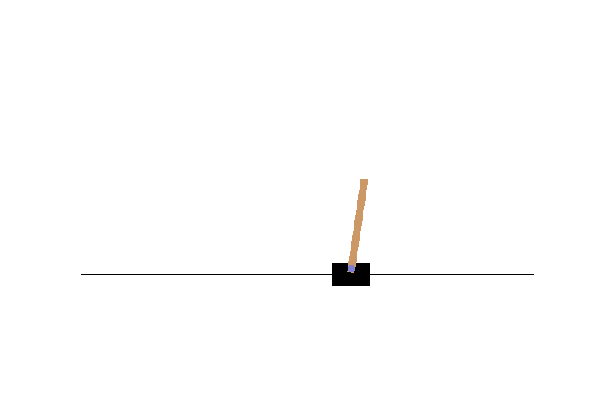
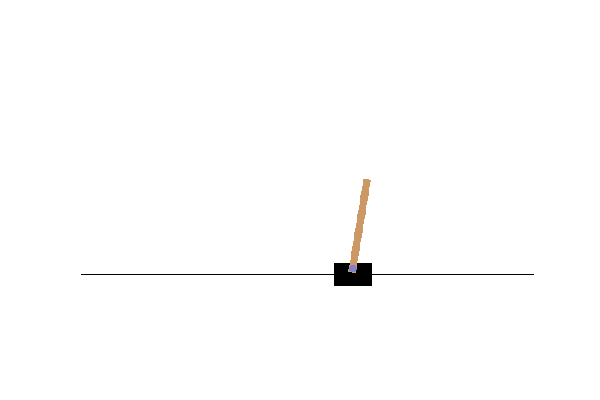
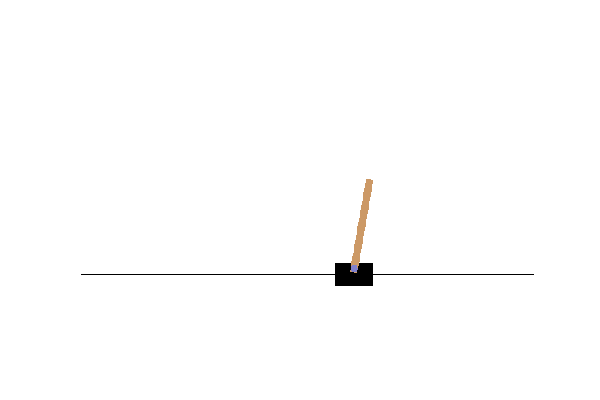
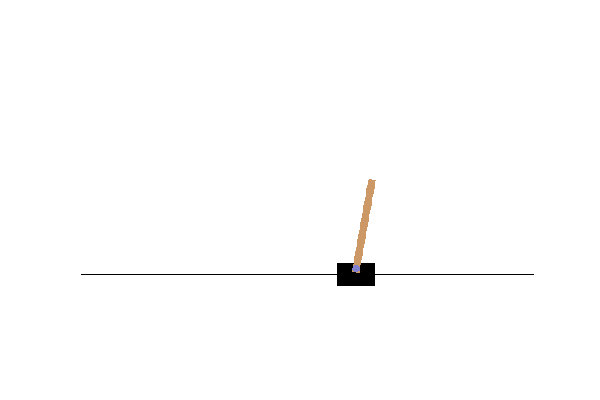
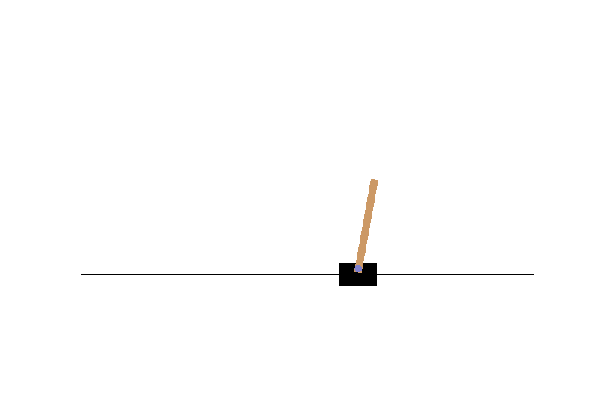
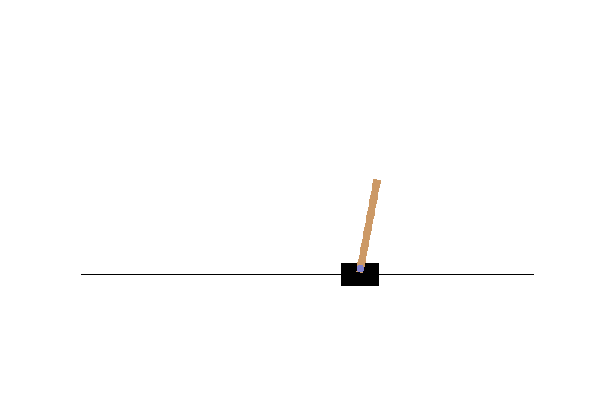
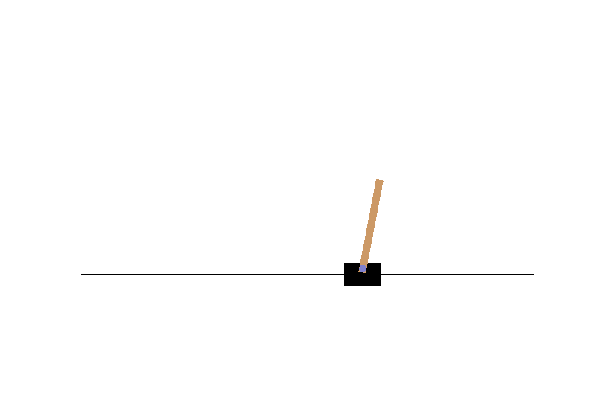
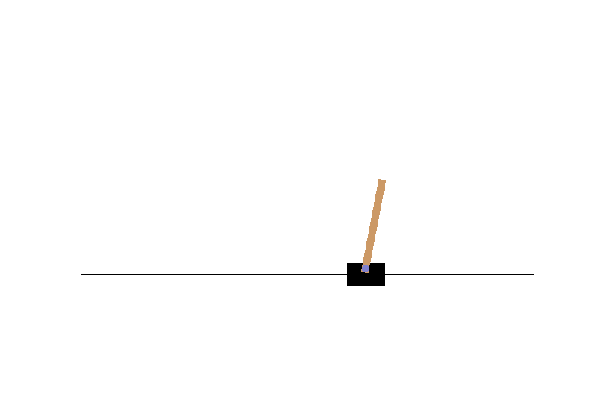
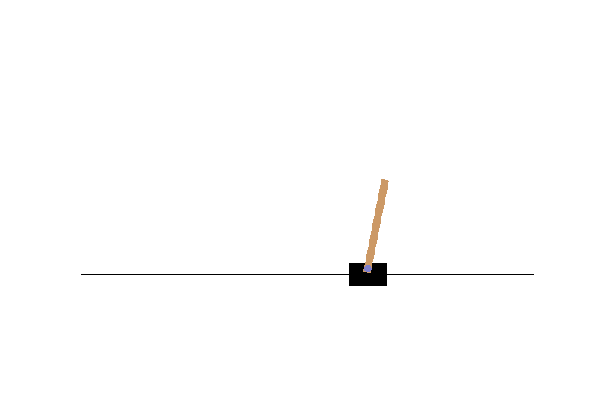
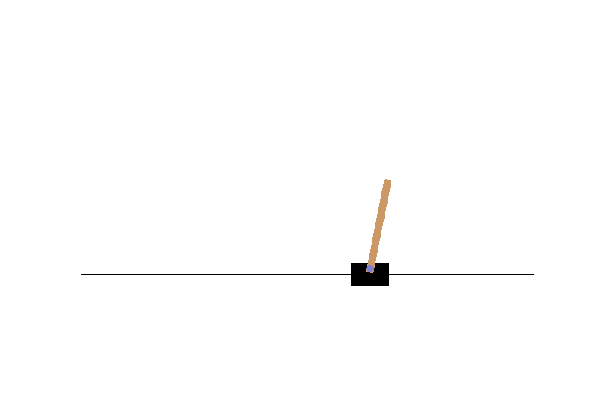
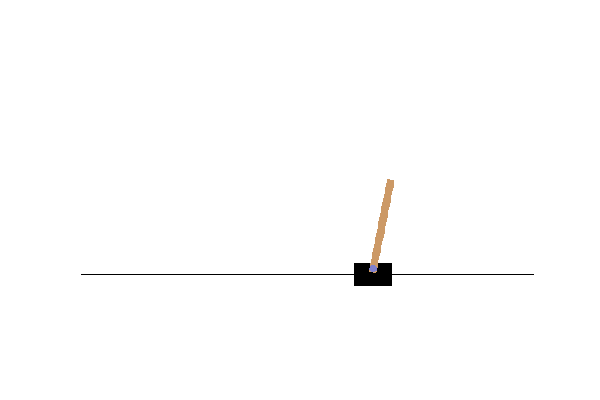
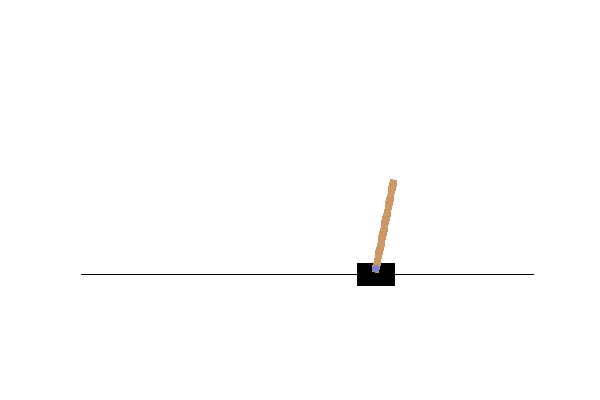
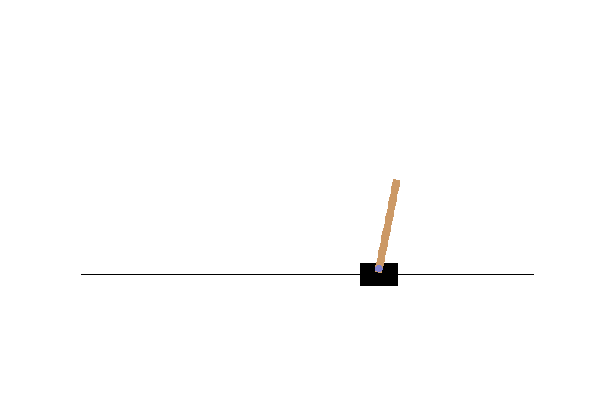
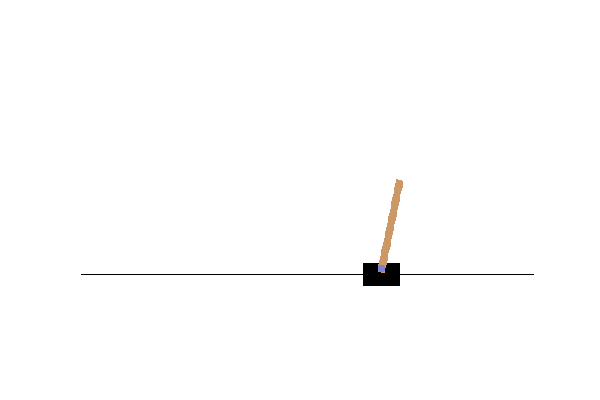
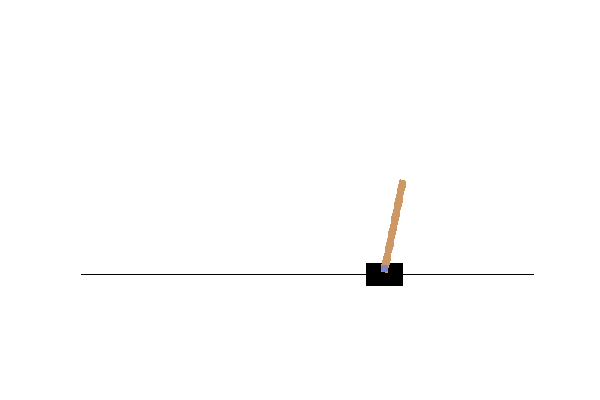
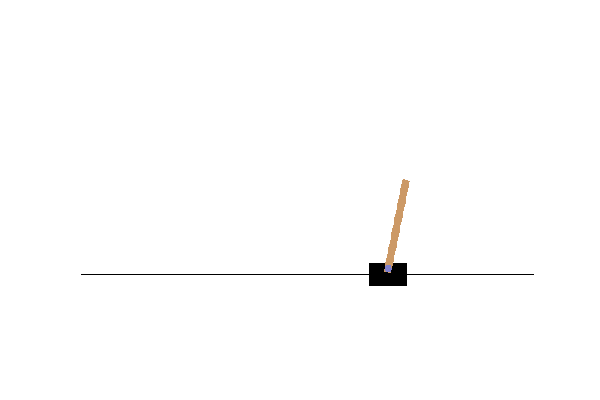
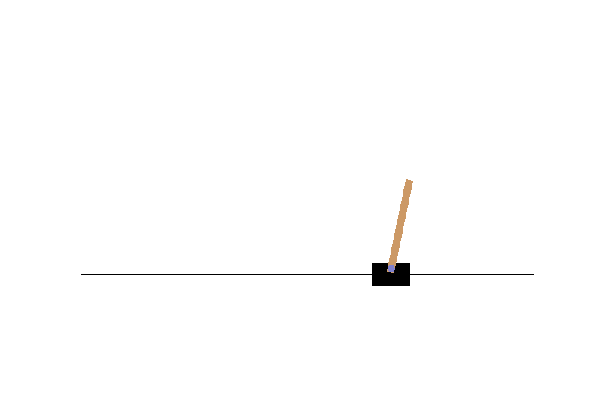
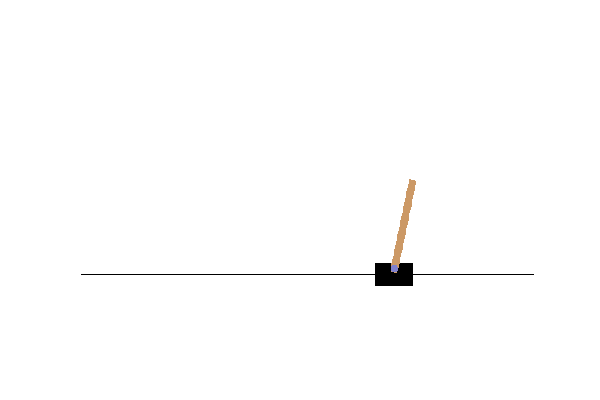

In [17]:
observation = env.reset()
term = False
predicted_q = []
frames = []

### Play till we are dead
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)

### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

## Video 4: Reinforcement learning tricks


There are some things which make your network perform better. In this video I will introduce two of them. 
### Epsilon annealing
Last video we let our agent perform random actions and tried to learn from this. As you can see in the resulting video the agent performs pretty well at the start, but has trouble after several frames...

This is why we can ask the agent every frame to select an action. It works best if you start by randomly exploring so the agent learns what's good and bad, but later let the agent try to perform himself. 

Even later on it might be beneficial to add randomness to the actions of the agent. Sometimes your agent can get stuck in a very "safe" situation... Randomly exploring will break this eventually which makes it possible to get a perfect score!

What we will implement is called "epsilon-annealing". Every frame, with a probability of epsilon $\epsilon$ the agent performs a random action. At the start the value of epsilon is set to 1.0, but after a while it gets annealed to its minimum value (in our case: 0.1). 

### Limiting the replay memory
As you can imagine with this strategy the agent will get better and better. It's thus good if we select the most recent memories of actions in which the agent came pretty far. Neural networks don't like it if you keep feeding the same data, so make sure the length of the replay memory is pretty long...



In [26]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/normal/'+str(logging_dir_n),sess.graph)
logging_dir_n +=1
sess.run(tf.global_variables_initializer())

In [27]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
decay_factor = 0.001
MIN_EPSILON = 0.1
MAX_LEN_REPLAY_MEMORY = 10000 # replay memory of most recent frames.

In [28]:

observation = env.reset()

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select action
    if random.random() < epsilon: 
        action = env.action_space.sample()
    else:
        pred_q = sess.run(predictedreward, 
                      feed_dict={networkstate:[observation]})
        action = np.argmax(pred_q)

    ### Anneal epsilon
    epsilon = max(epsilon-decay_factor, MIN_EPSILON)
    
    newobservation, reward, terminal, info = env.step(action)
    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    learn(replay_memory)
    

    ### If our memory is too big: remove the first element
    if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
            replay_memory = replay_memory[1:]


### Evaluation
Time for the evaluation again! Let's see if epsilon-annealing and a shorter replay memory helped us!

Frames: 108



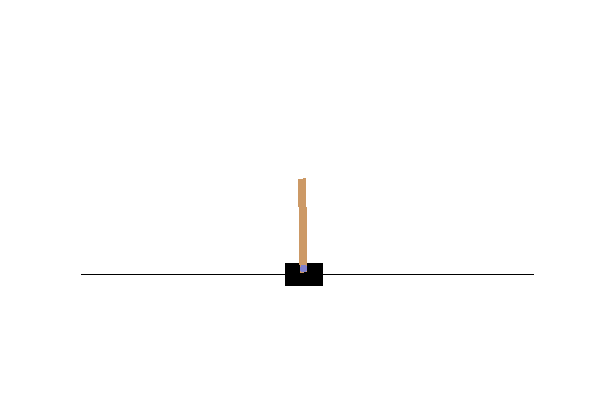
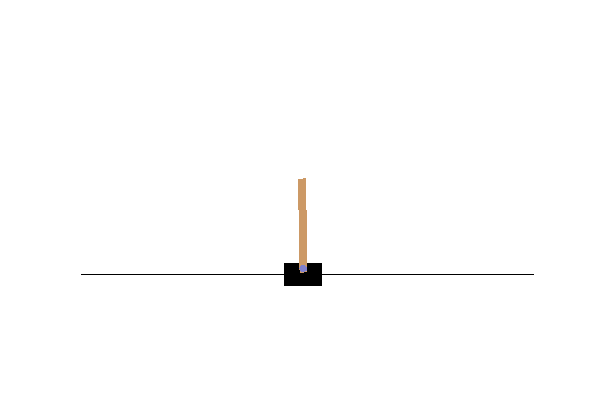
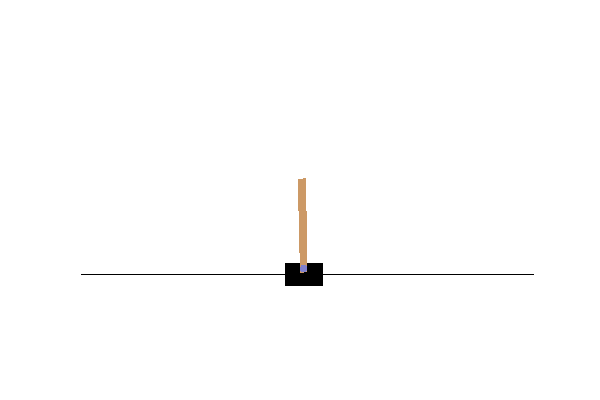
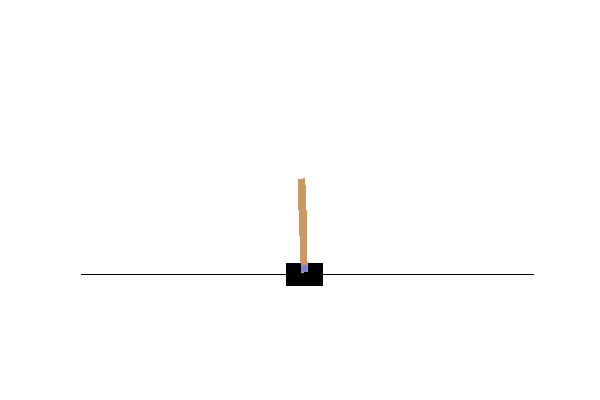
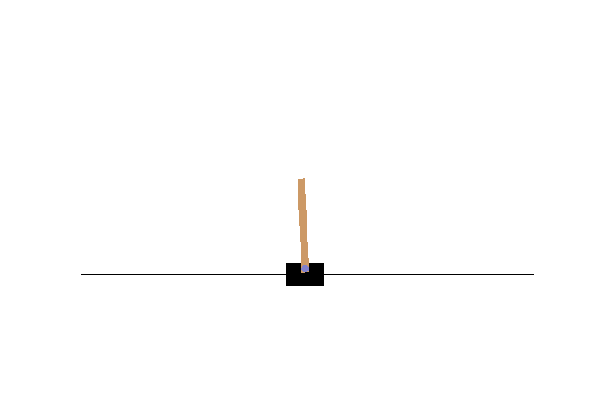
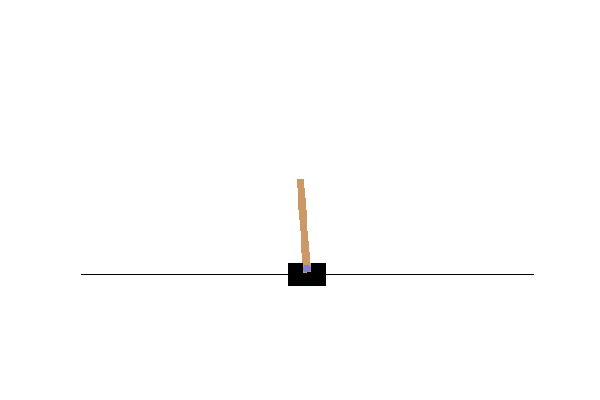
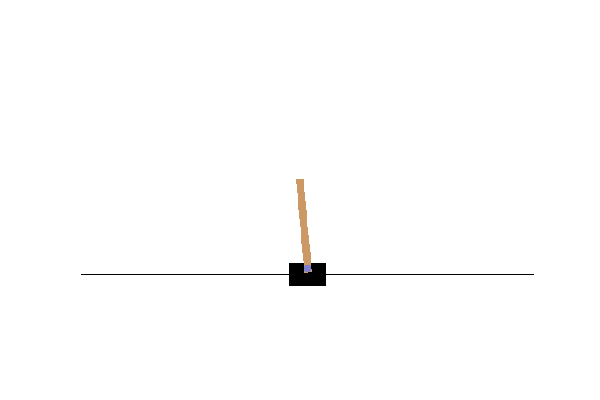
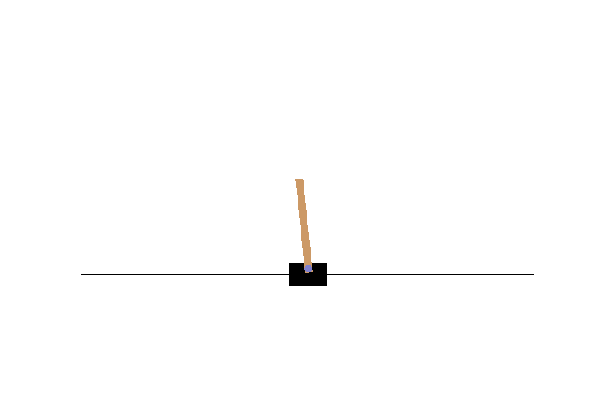
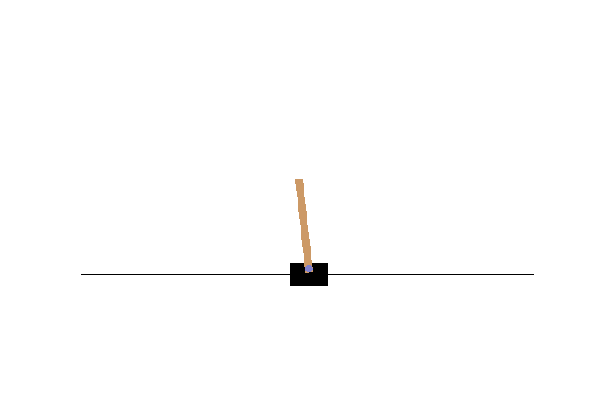
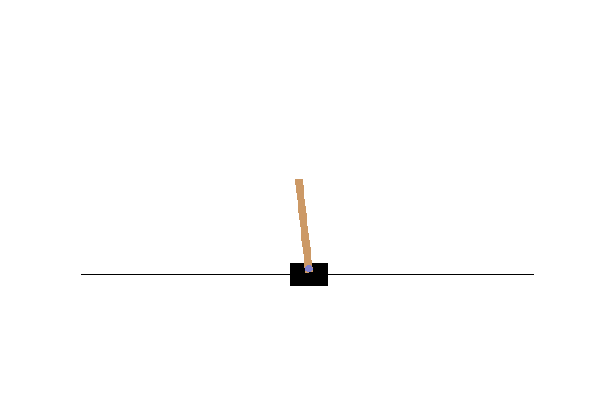
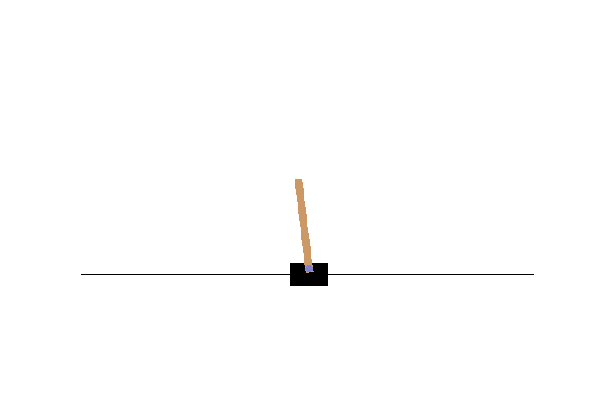
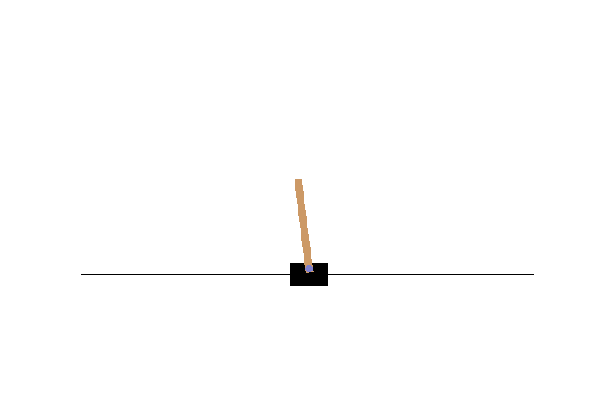
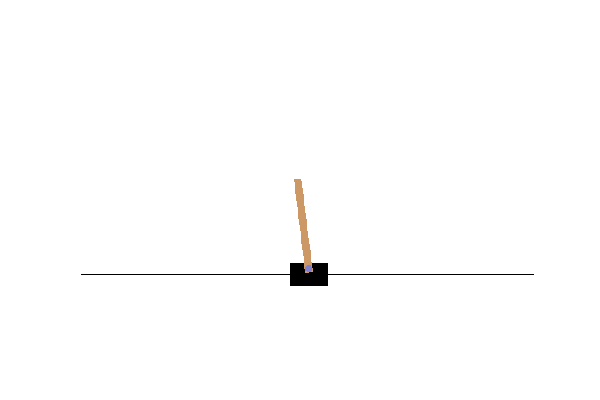
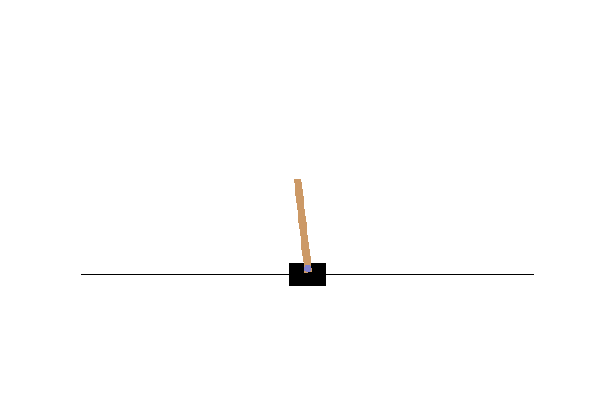
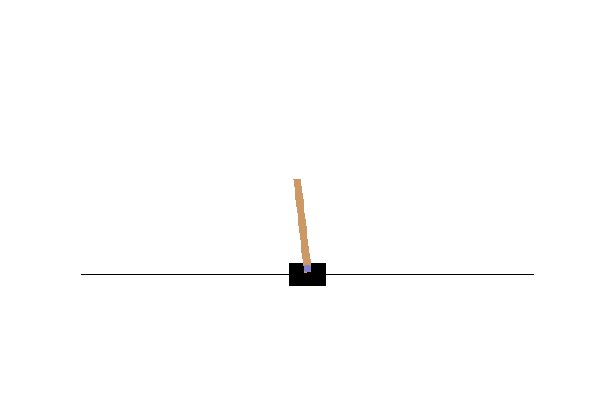
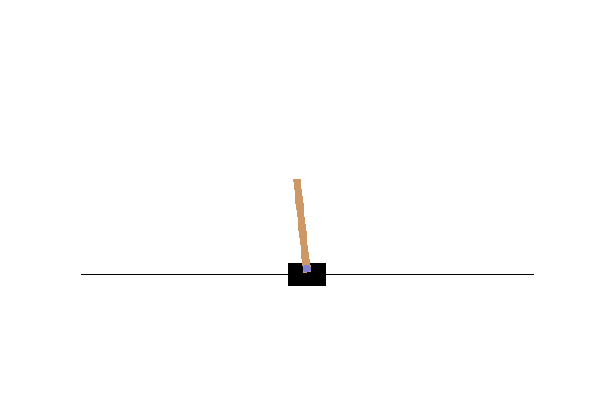
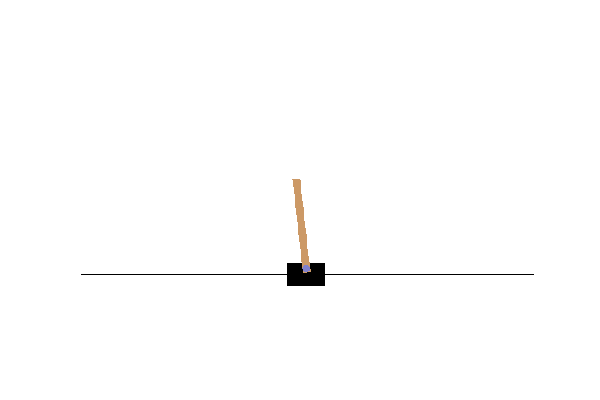
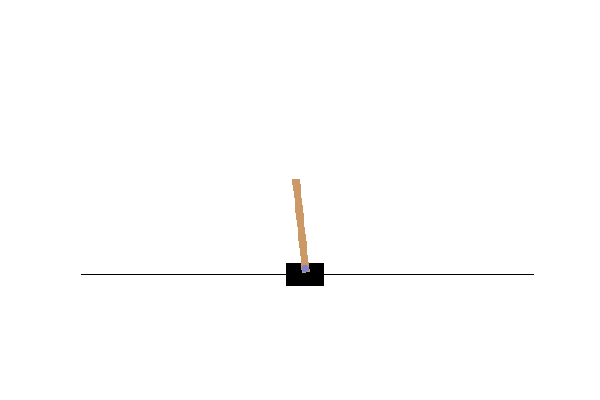
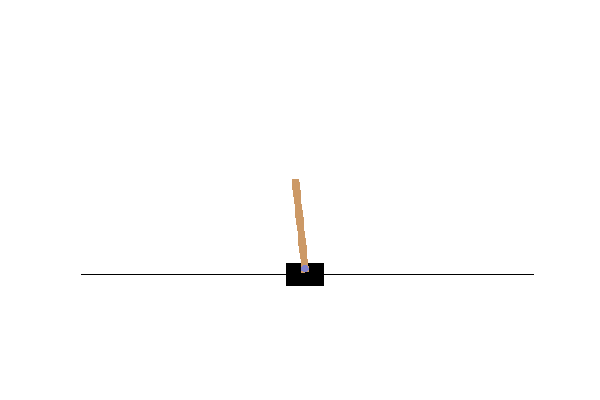
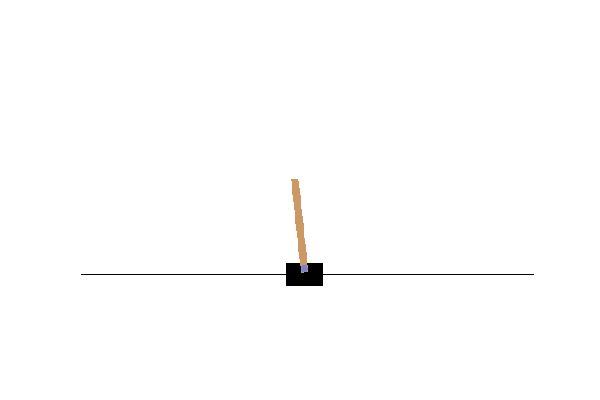
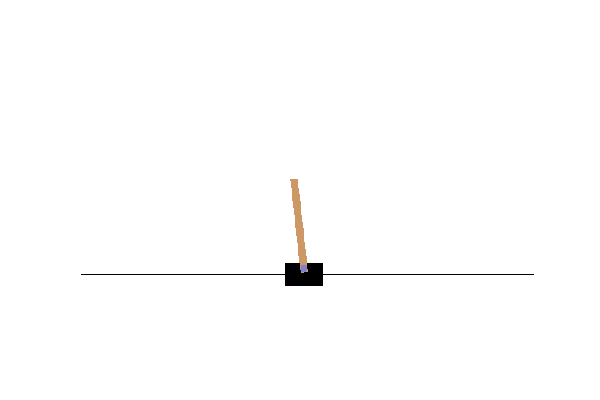
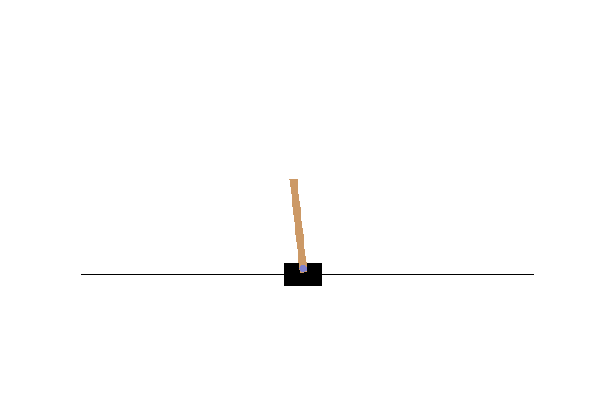
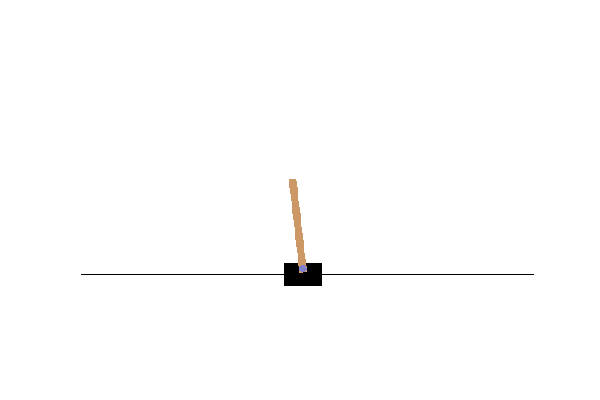
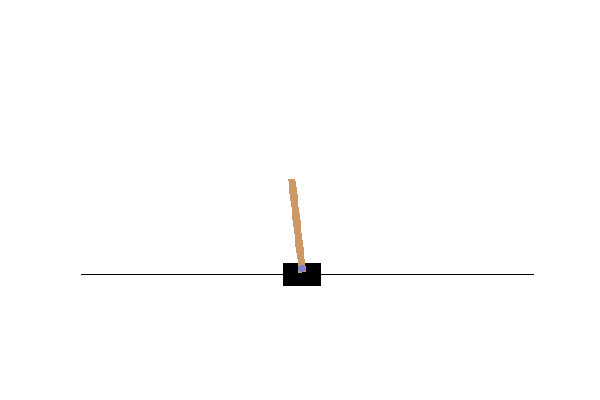
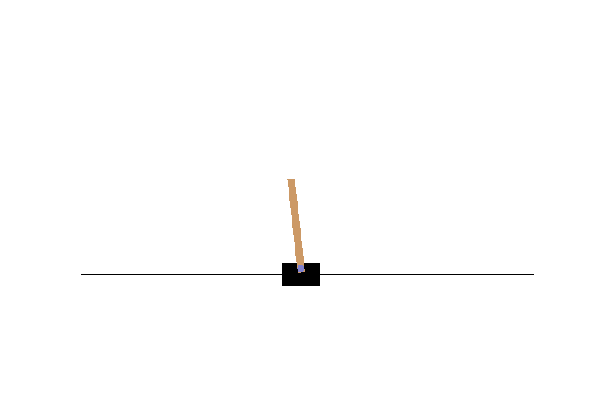
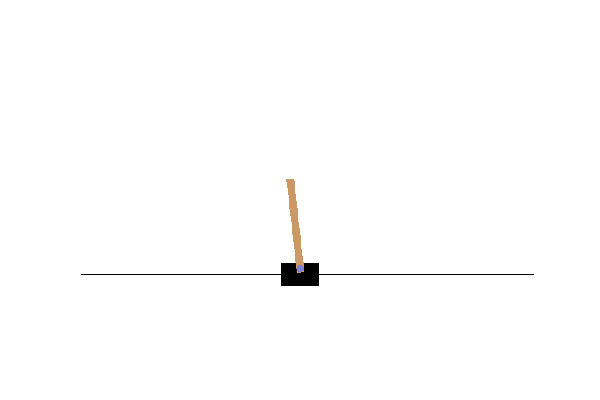
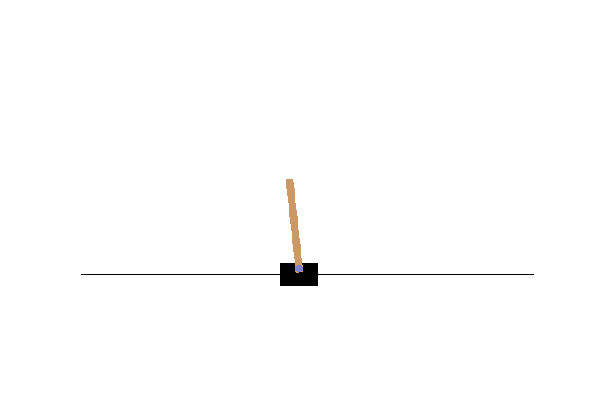
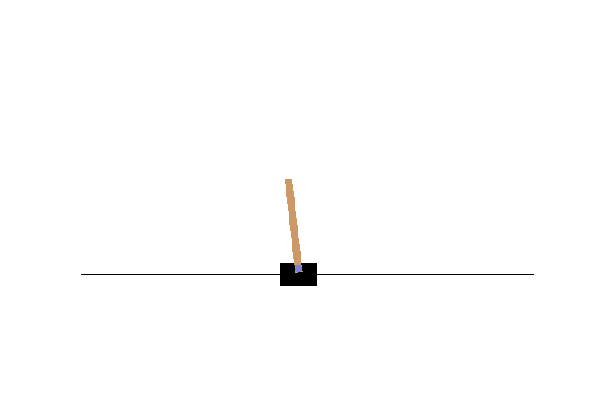
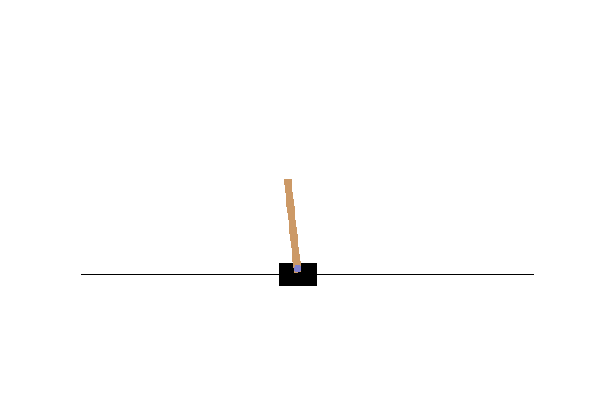
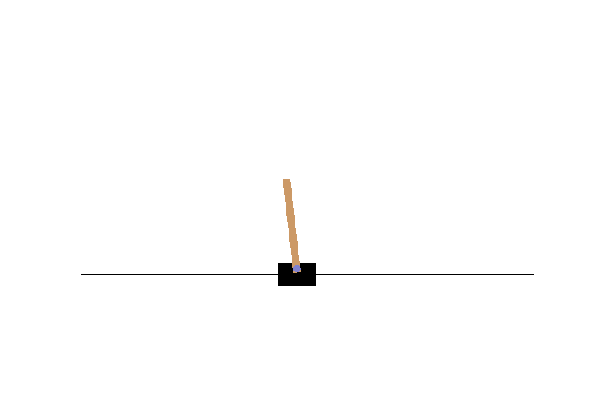
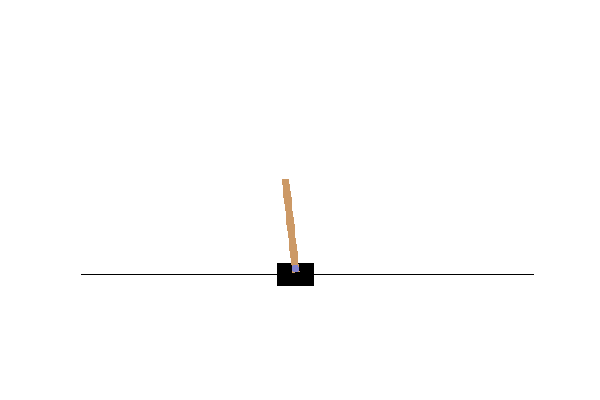
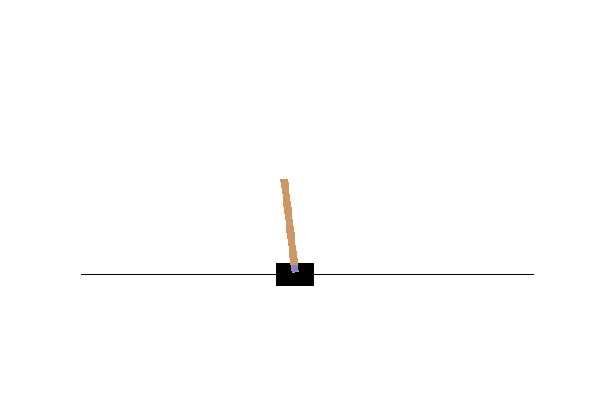
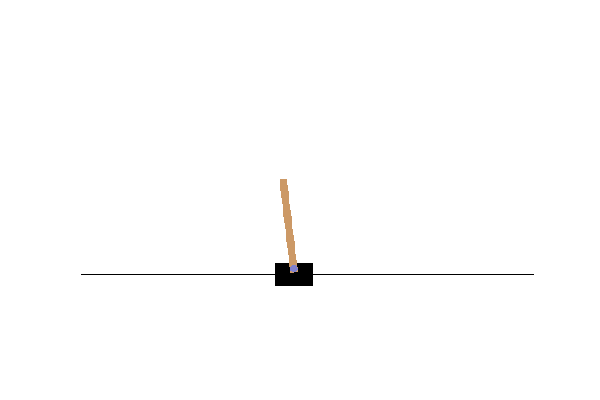
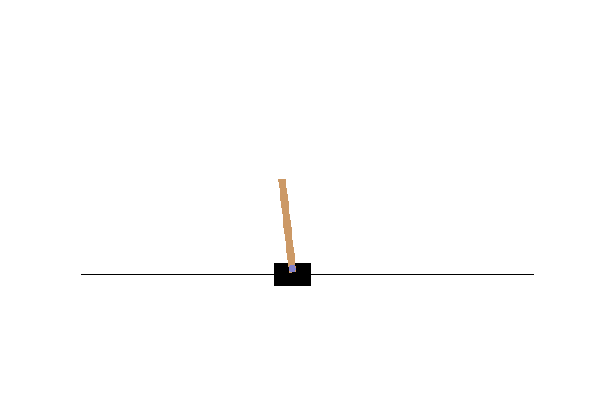
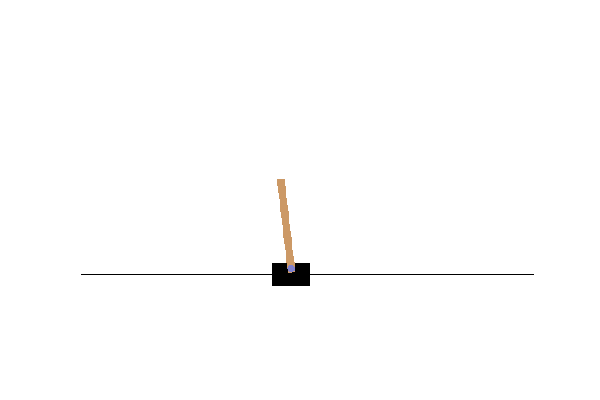
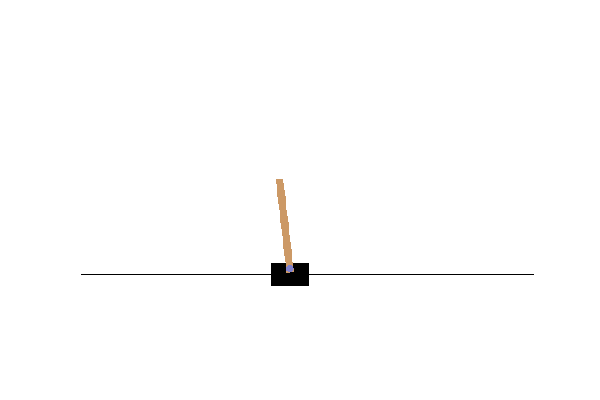
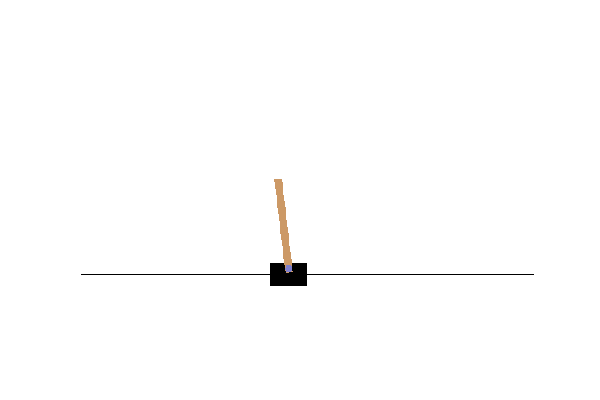
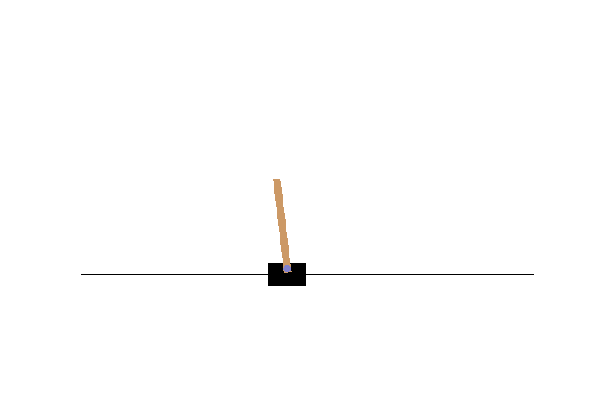
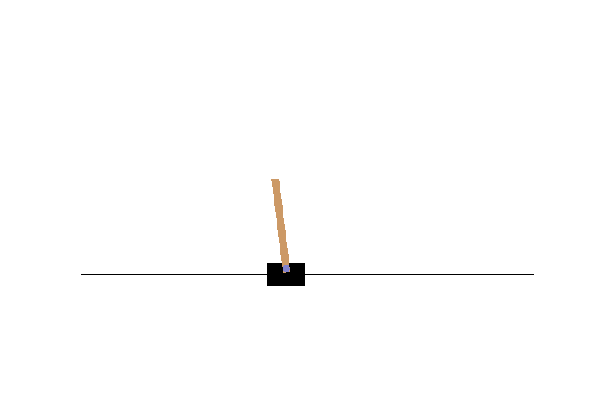
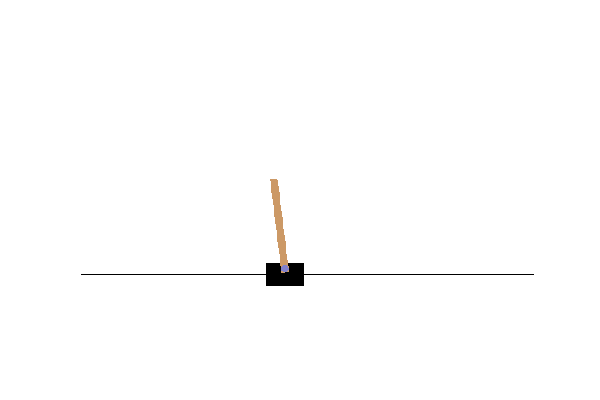
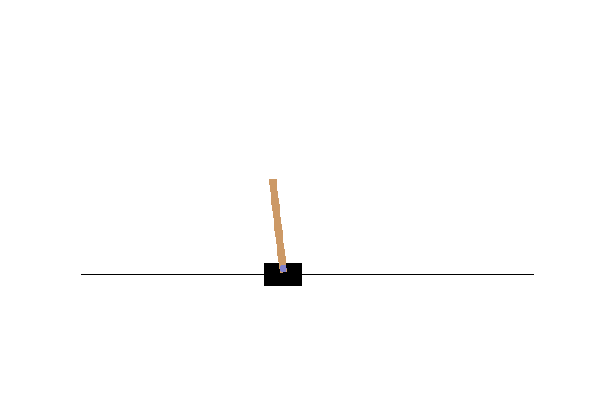
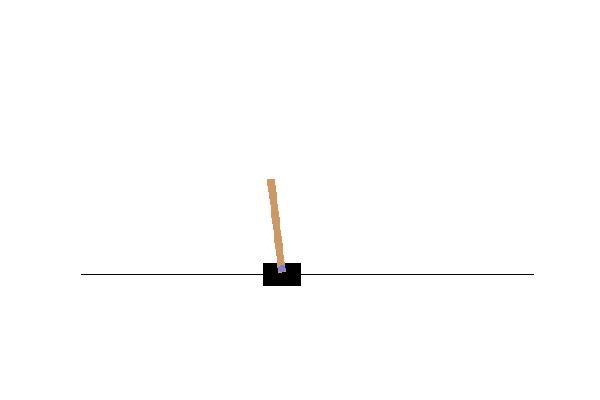
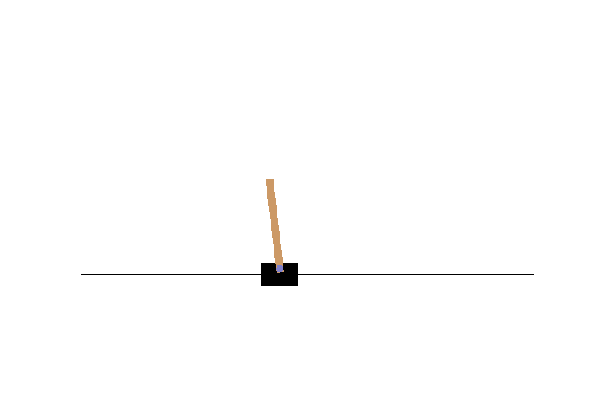
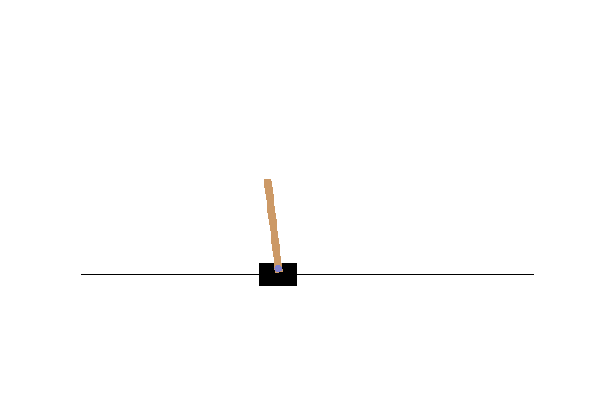
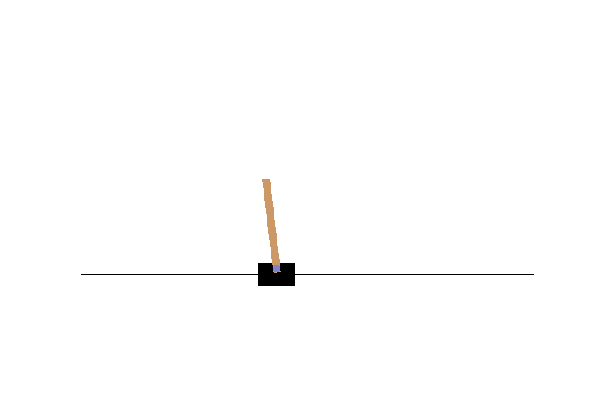
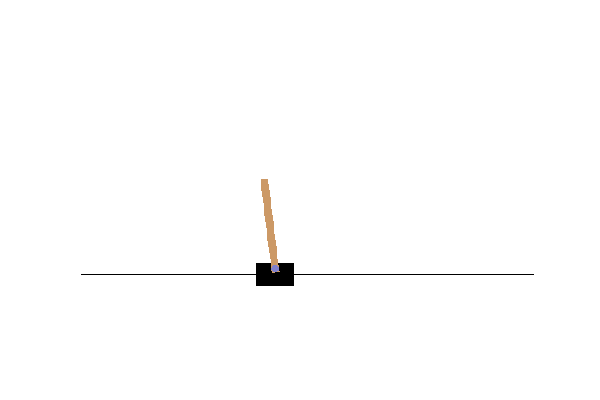
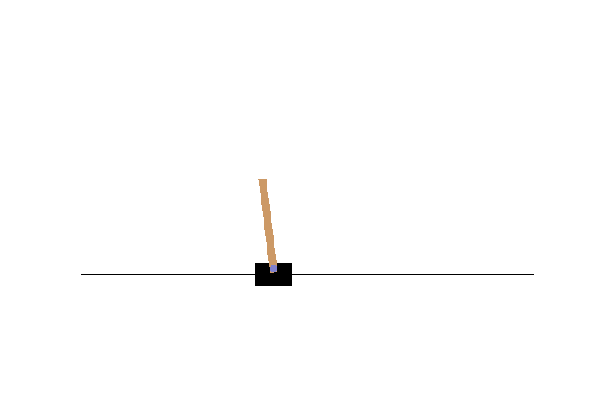
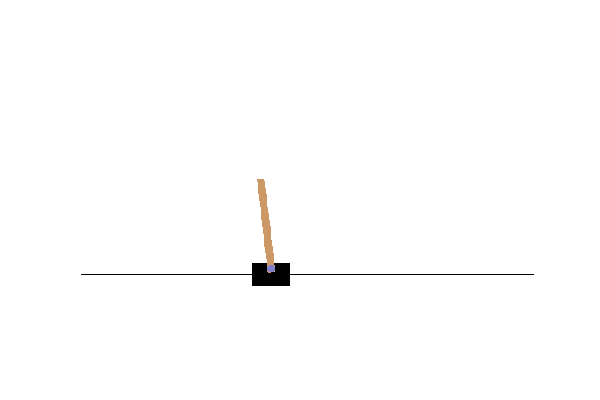
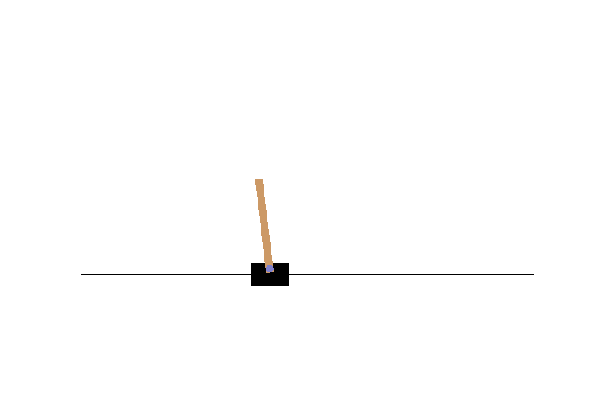
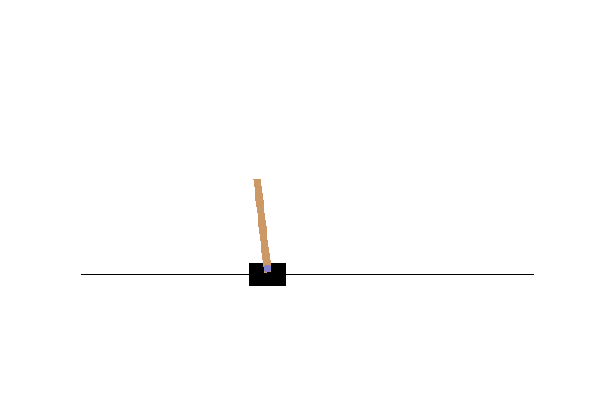
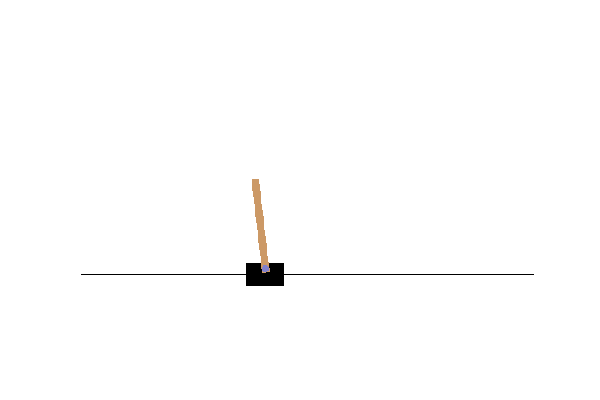
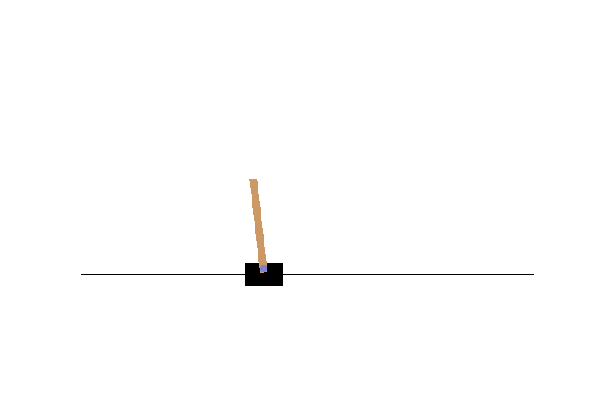
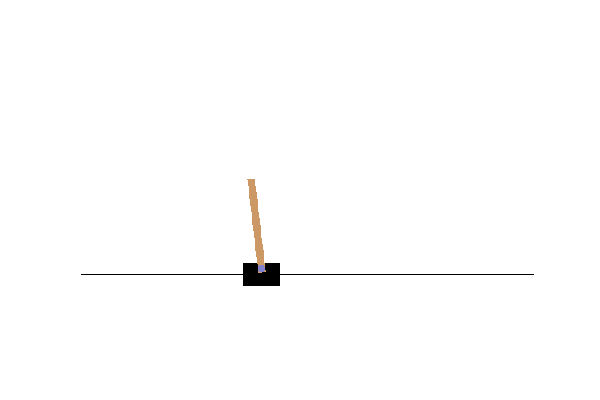
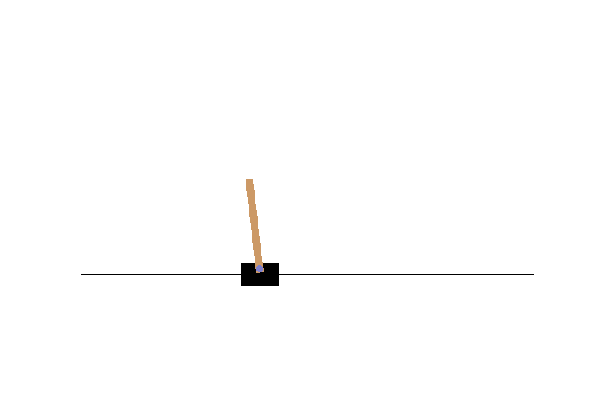
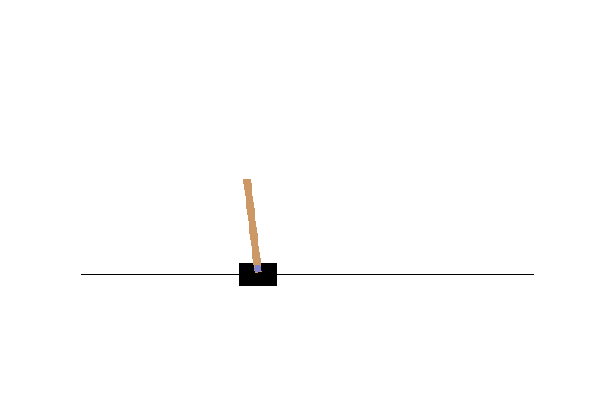
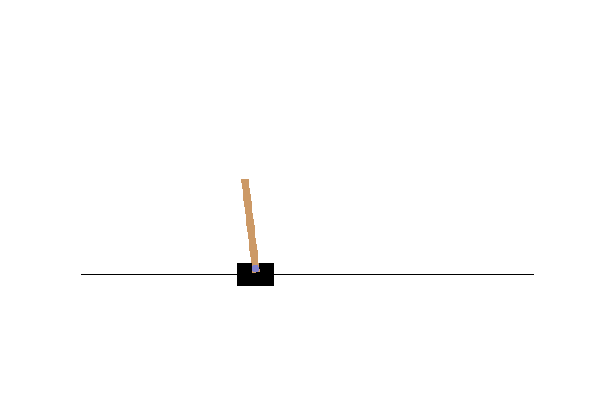
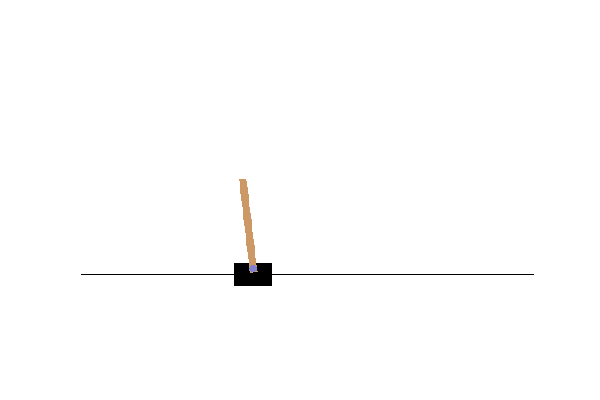
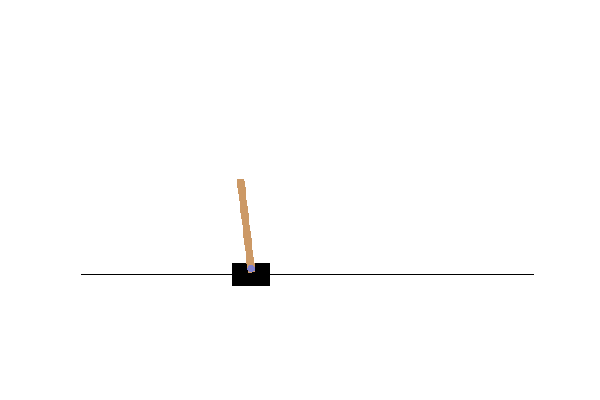
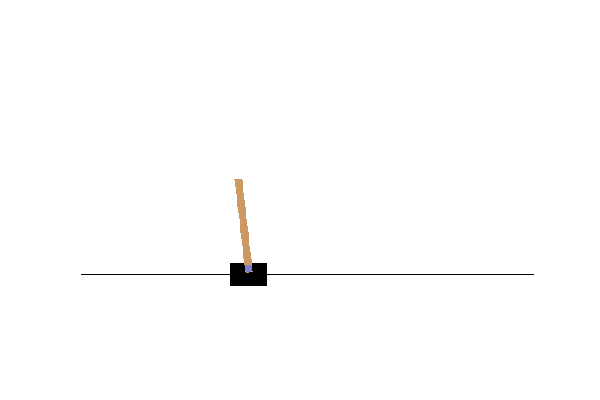
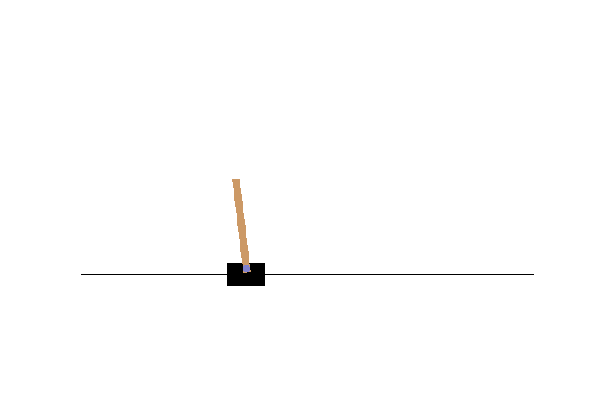
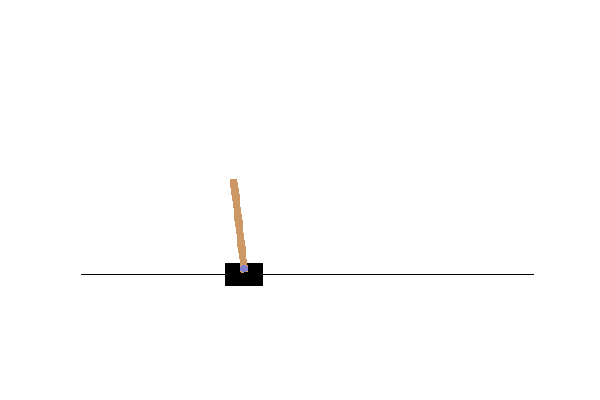
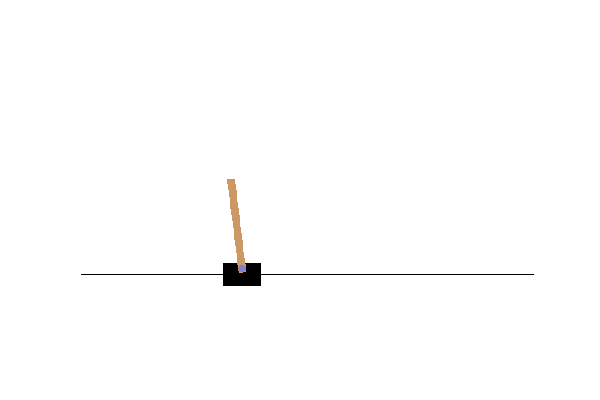
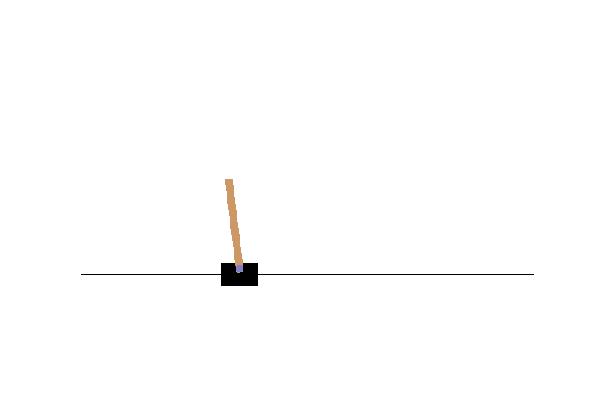
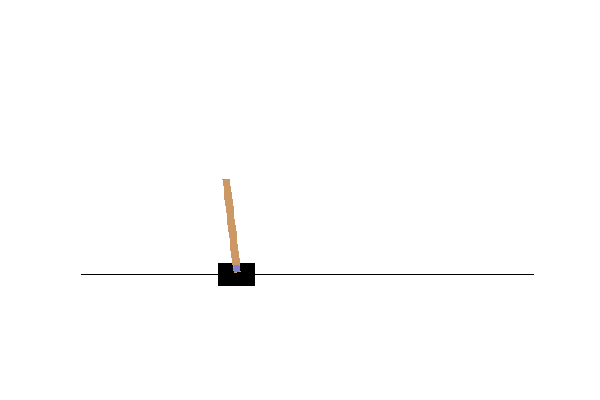
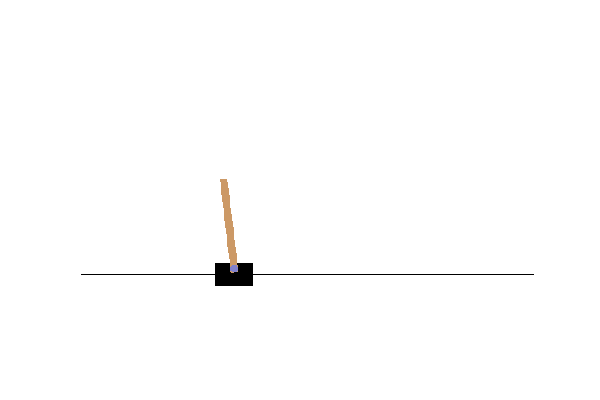
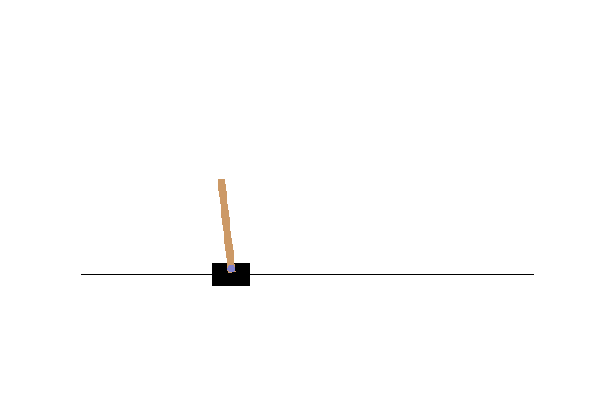
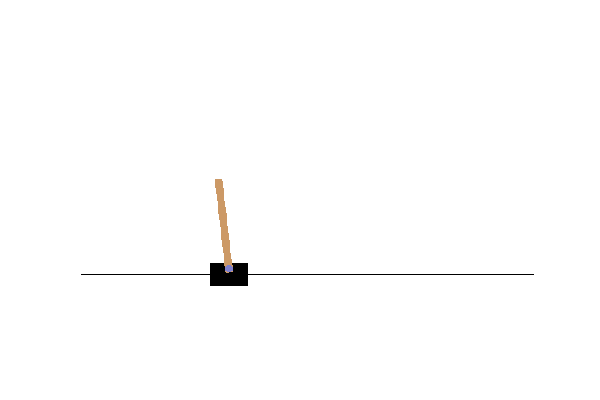
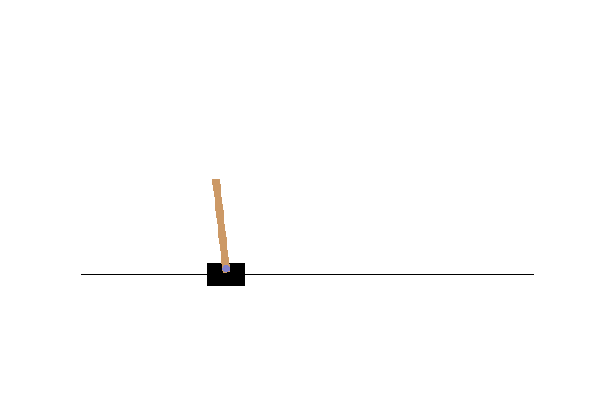
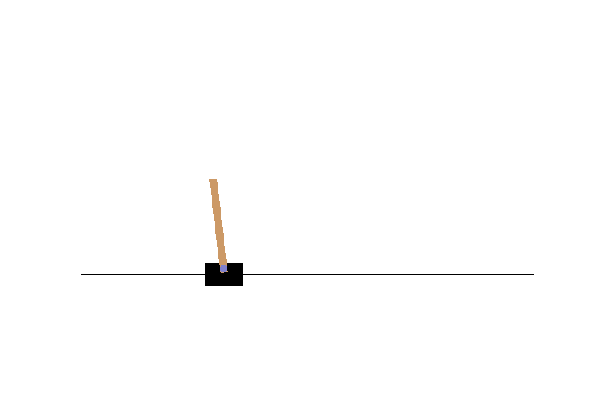
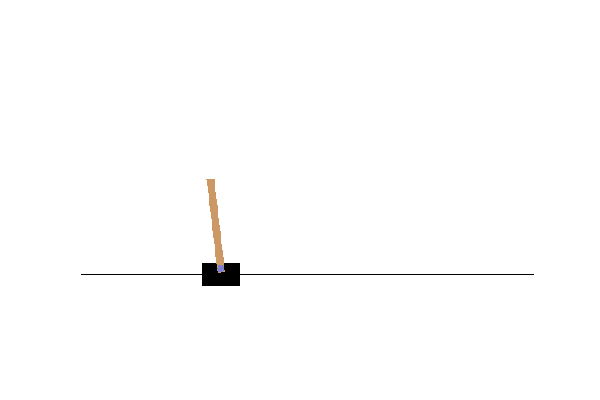
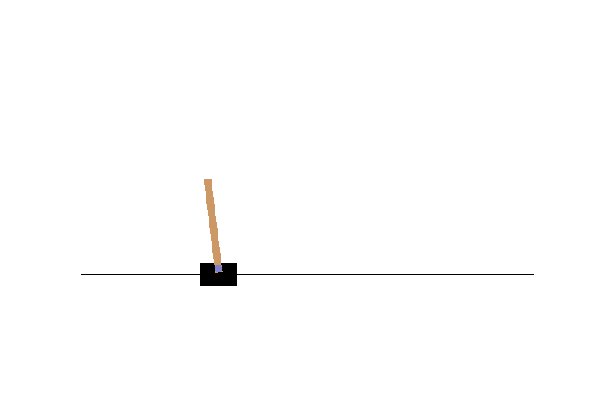
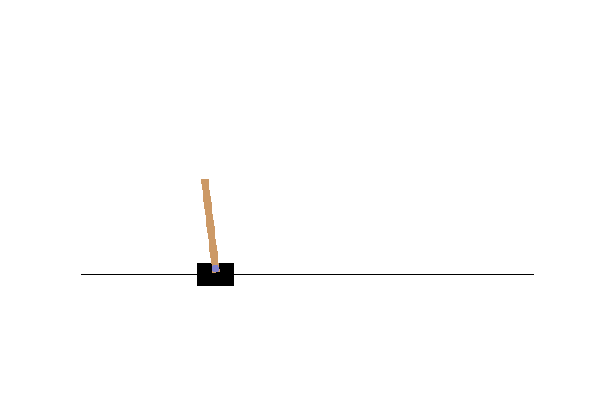
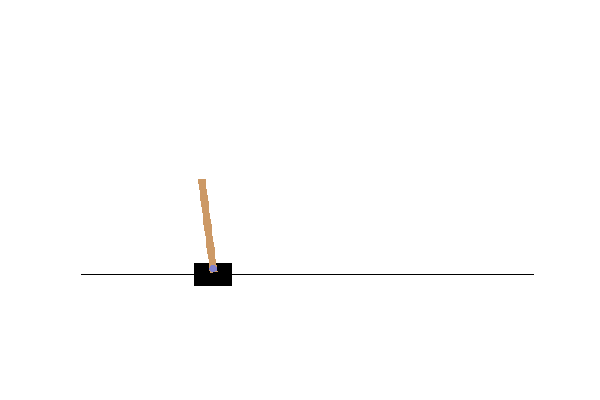
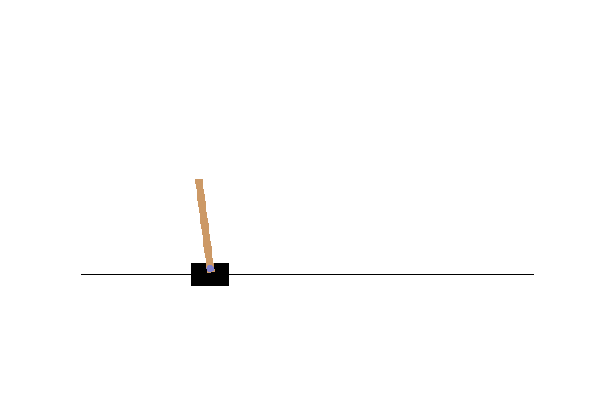
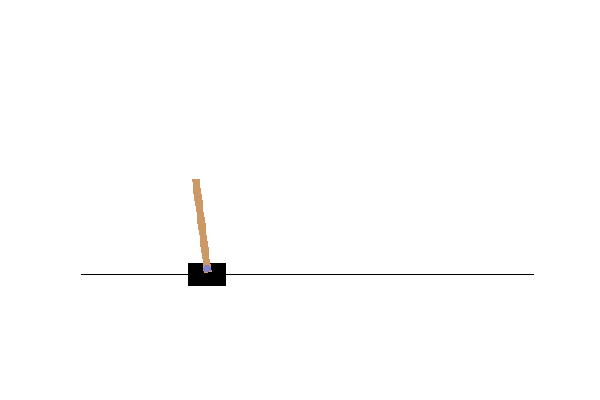
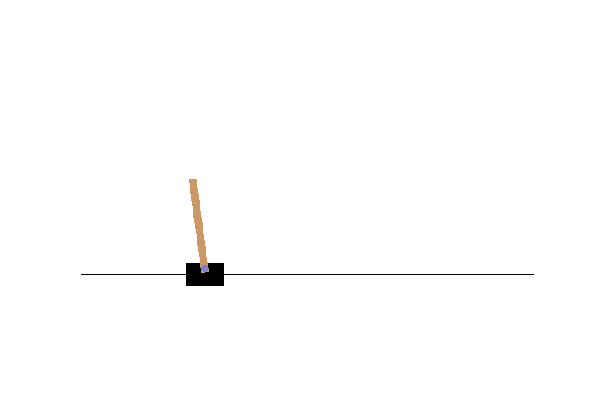
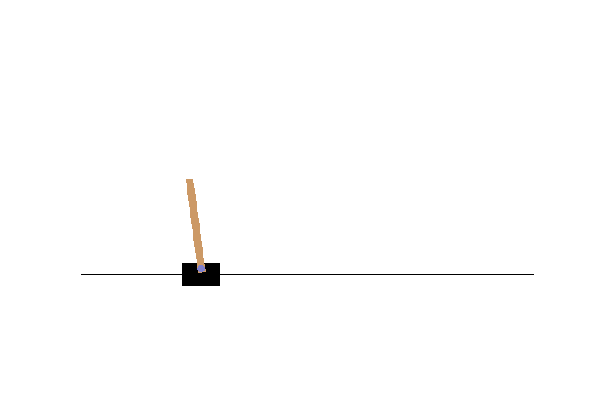
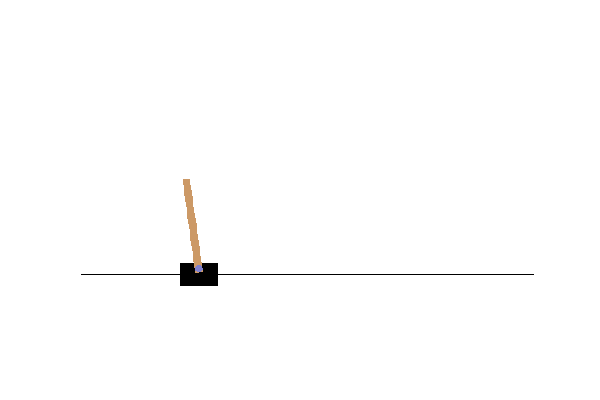
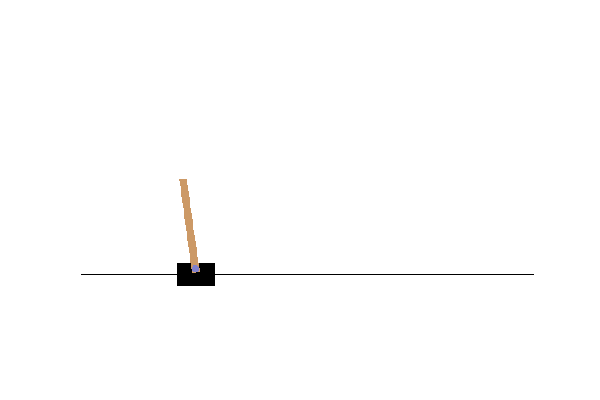
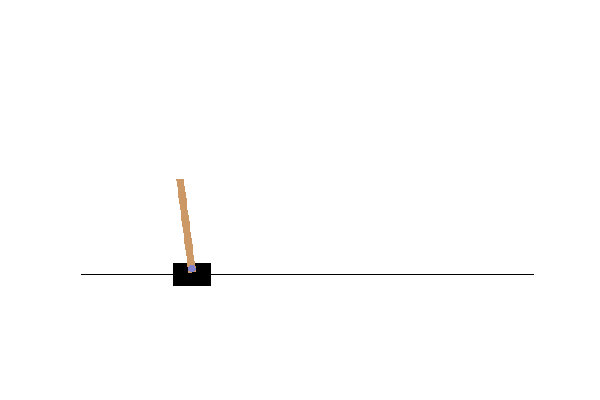
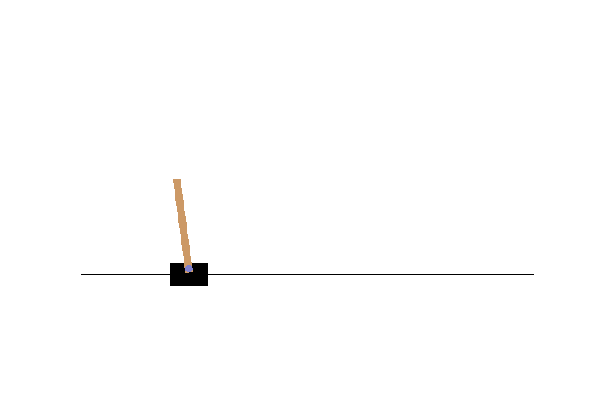
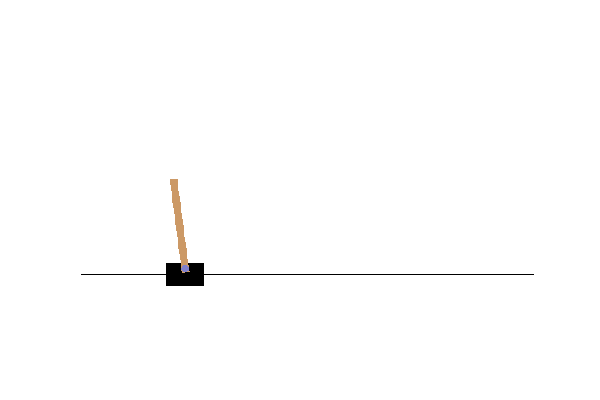
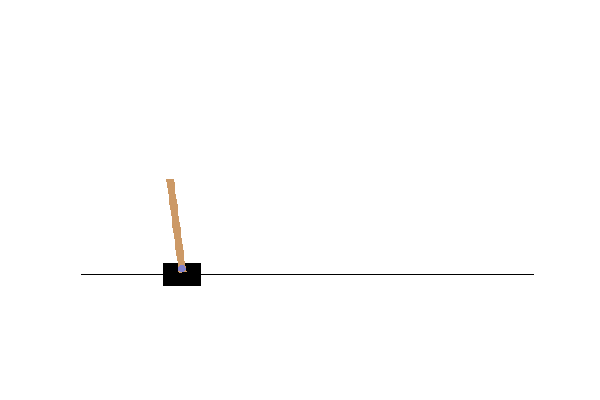
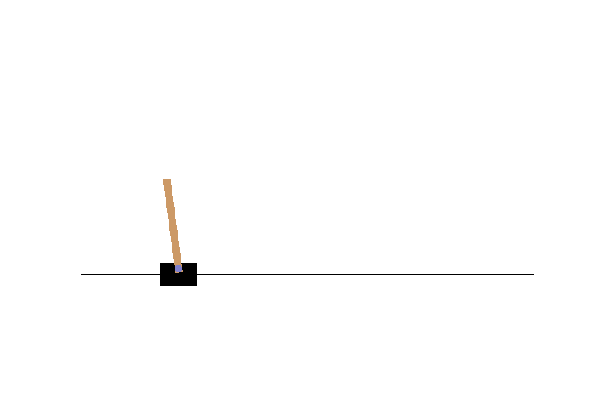
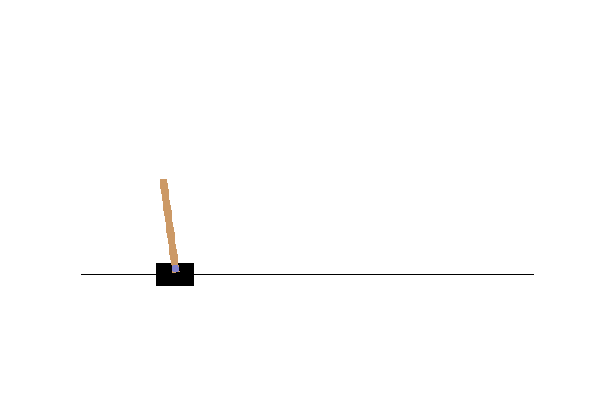
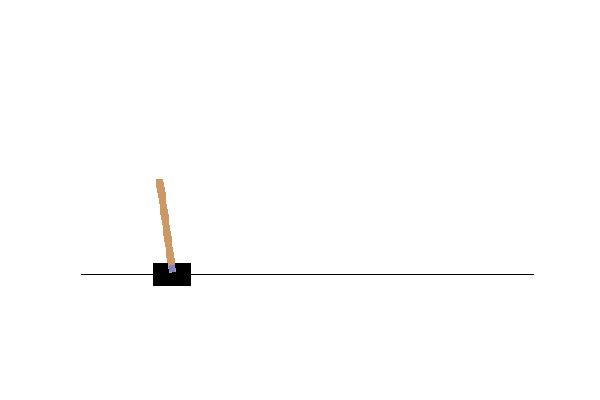
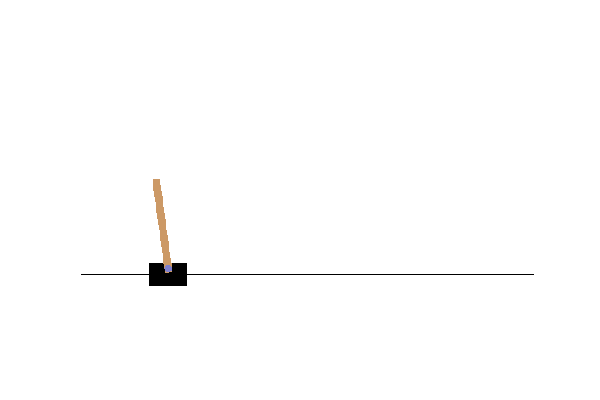
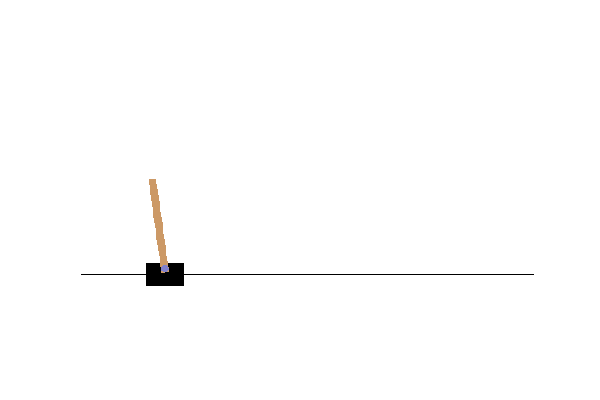
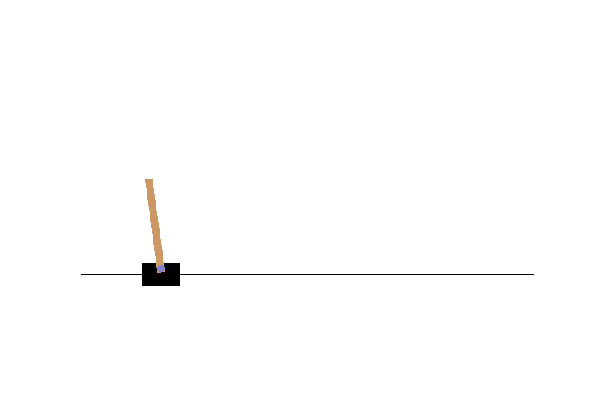
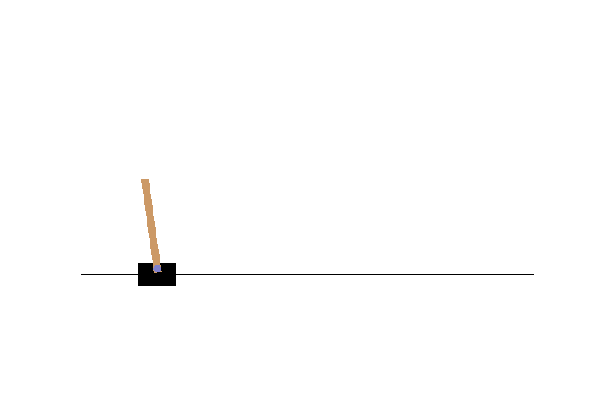
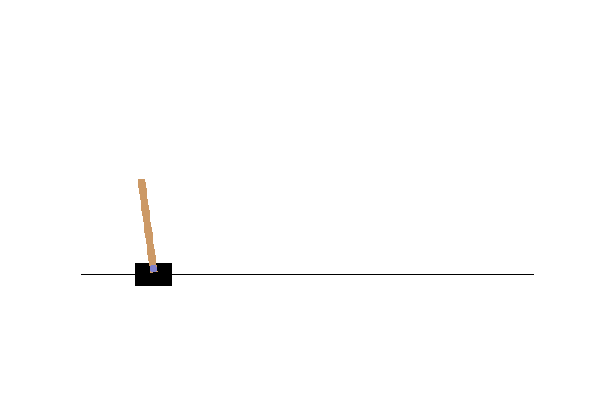
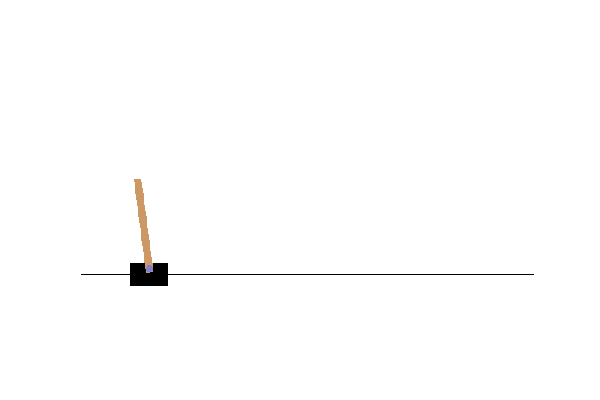
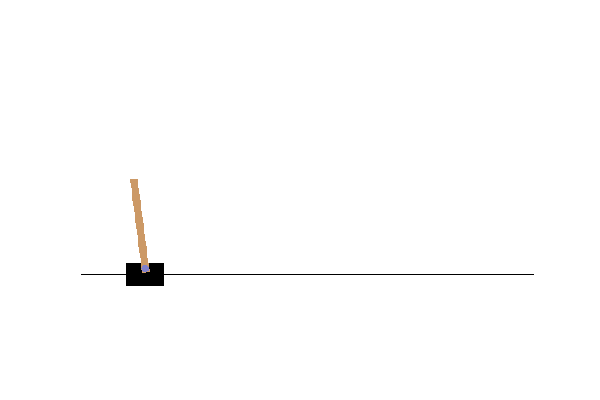
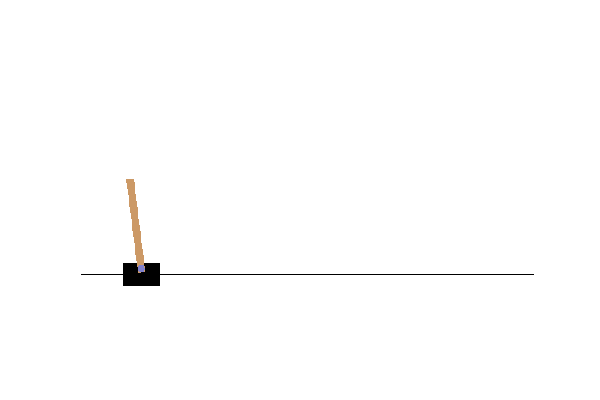
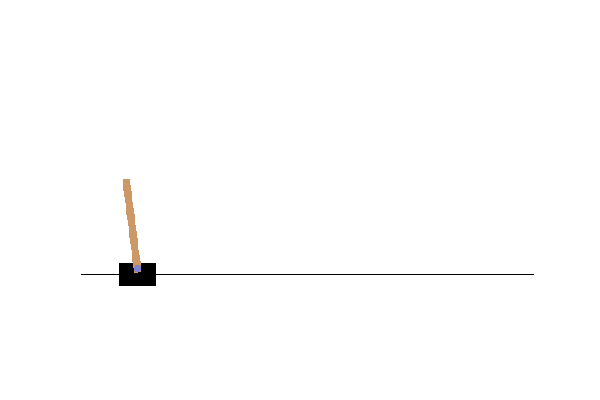
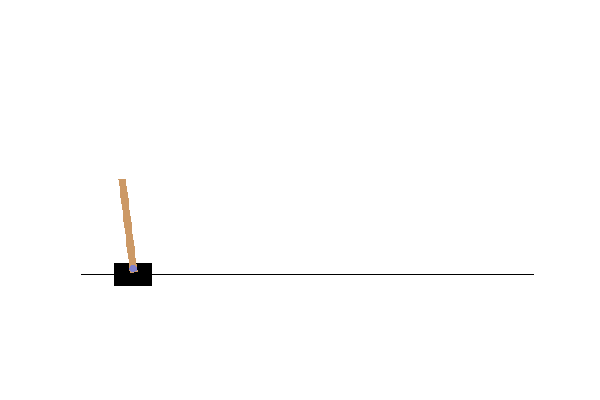
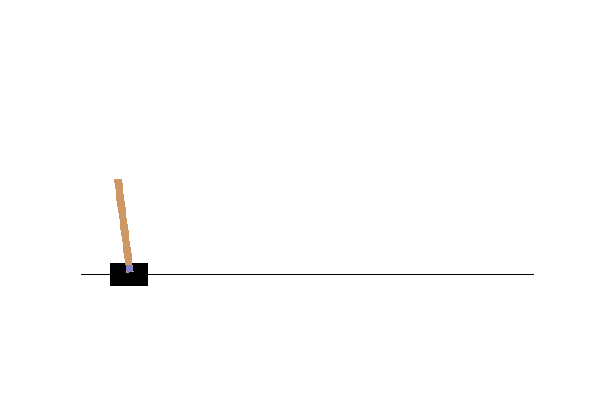
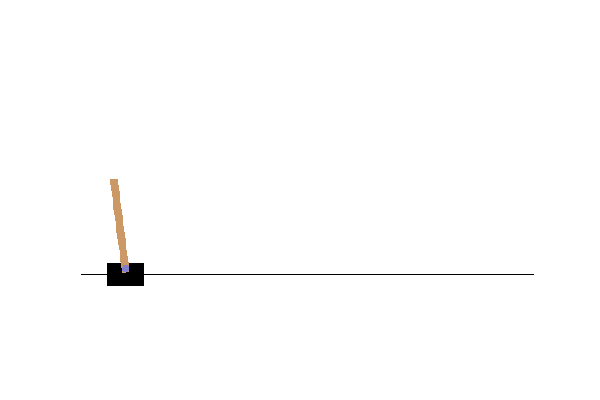
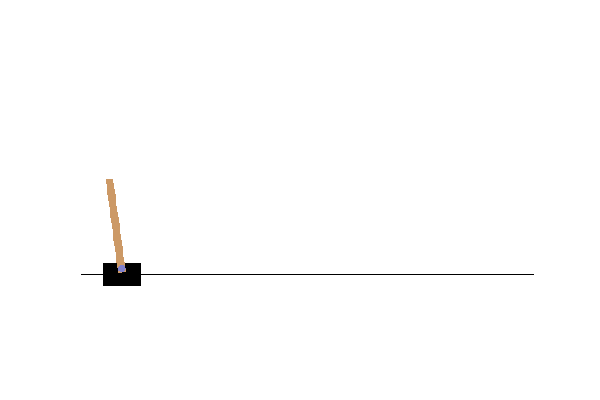
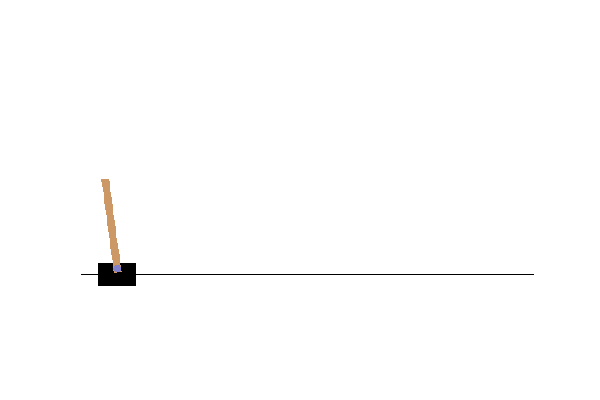
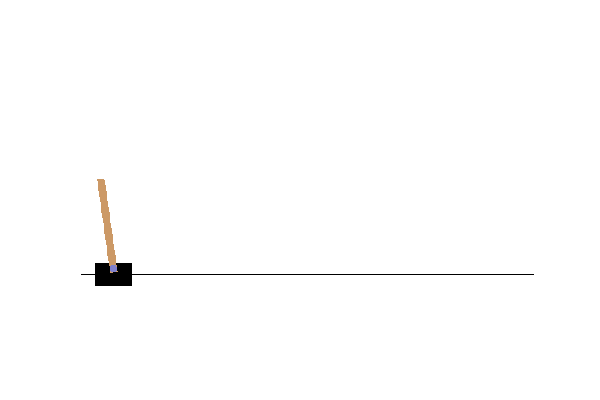
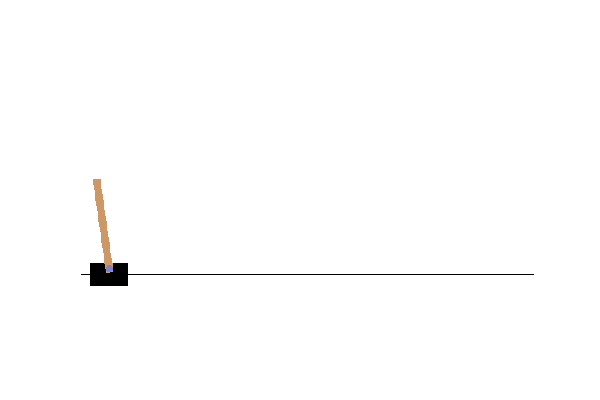
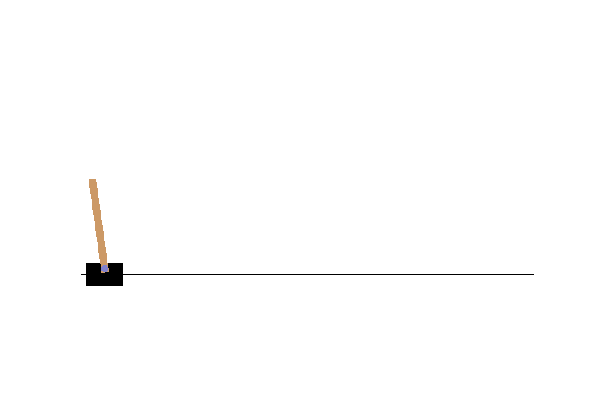
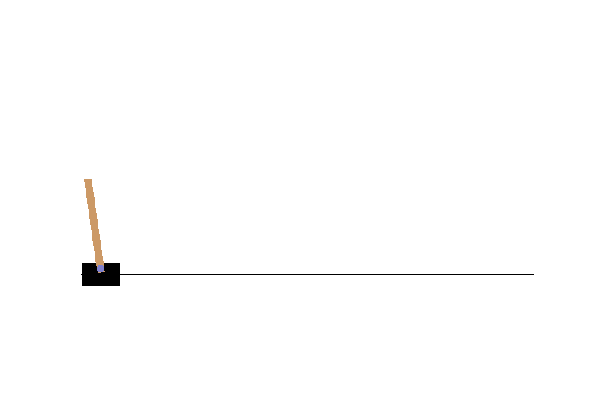
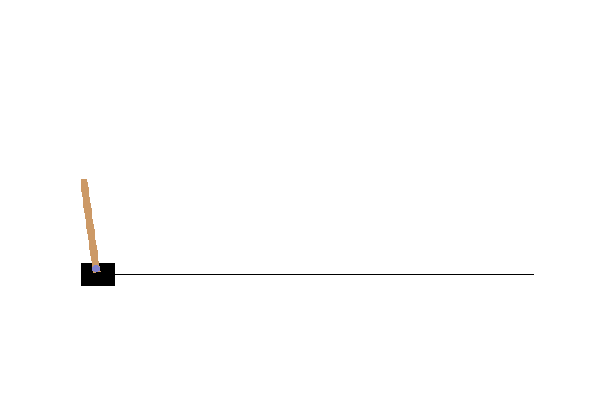
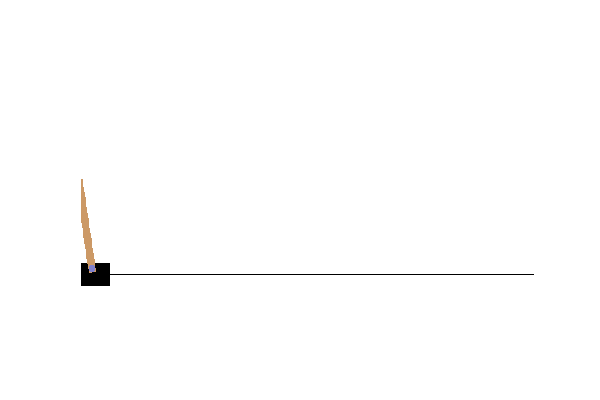
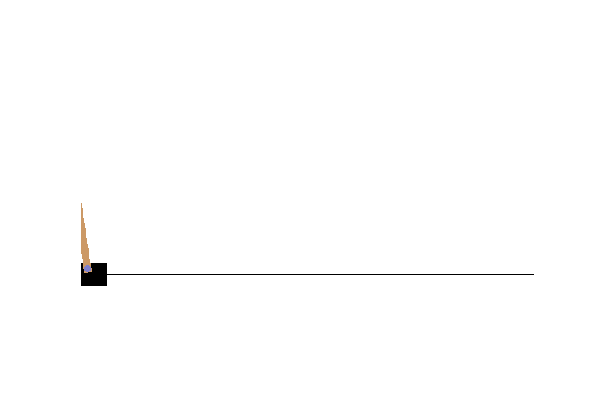
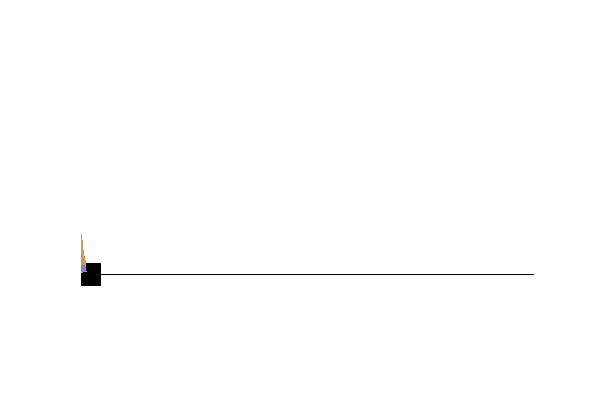

In [25]:
observation = env.reset()
term = False
predicted_q = []
frames = []

### Play till we are dead
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)

### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

### Conclusion
Take a look at the image above to see how your agent performs! This is a deep neural network who learned to control an agent using reinforcement learning!

## Video 5: Introduction to the Atari environment
Now we were able to solve the cartpole environment it's time to explore other interesting environments. A list with environments available in the OpenAI gym [can be found on this website](https://gym.openai.com/envs/). If you like videogames like me you are probably interested in the Atari environment....

Before you dive into these environments it's important to note that these problems are SUPER difficult. It's hard to define exactly what an agent has to do using traditional computer-vision and manually implemented rules. Imagine how hard it is for a neural network to learn what's good and what's bad while only having access to a system in which it gets rewards every time it does something right. In many environments the reward for an action is VERY delayed. In the game breakout you have to start moving in the right direction while the ball is still going up, otherwise you will miss it when it comes down. As you only get a reward when the ball hits a block you get your reward for moving correctly A LOT of frames later than you performed the action...

Now you know how difficult this environment is I will walk you through te code that is able to solve it. I will go over some interesting things in the code and explain why they are there. Progress is logged to TensorBoard so you can keep up with what your network is learning. 

Note that training this neural network can take a VERY long time. In my case I left my computer on for a whole day! To allow you to simply restart your whole Jupyter notebook I made a separate notebook you should now open called "Section 5 atari video". 